In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.stats import norm
import os, sys
import scipy.io as sio
from sklearn.cluster import SpectralClustering

import keras
from keras.layers import Input, Dense, Lambda, Reshape, Flatten, Dropout
from keras.layers import Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Implement Class

In [2]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        #acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        
        #loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        
        if loss_type == 'epoch':
            #val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            
            #val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

class Scaler(keras.layers.Layer):
    def __init__(self, tau=0.5, **kwargs):
        super(Scaler, self).__init__(**kwargs)
        self.tau = tau
    
    def build(self, input_shape):
        super(Scaler, self).build(input_shape)
        self.scale = self.add_weight(
            name='scale', shape=(input_shape[-1],), initializer='zeros'
        )
    
    def call(self, inputs, mode='positive'):
        if mode == 'positive':
            scale = self.tau + (1 - self.tau) * K.sigmoid(self.scale)
        
        else:
            scale = (1 - self.tau) * K.sigmoid(-self.scale)
        
        return inputs * K.sqrt(scale)
    
    def get_config(self):
        config = {'tau': self.tau}
        base_config = super(Scaler, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class Sampling(keras.layers.Layer):
    def __init__(self, latent_dim=128, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def build(self, input_shape):
        super(Sampling, self).build(input_shape)

    def call(self, inputs):
        z_mean, z_log_var = inputs
#         epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), seed=42)
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim))

        return z_mean + K.exp(z_log_var / 2) * epsilon

    def get_config(self):
        base_config = super(Sampling, self).get_config()
        config = {'latent_dim': self.latent_dim}
        return dict(list(base_config.items()) + list(config.items()))

## Parameters

In [3]:
###########change dataset here##########
dataset = 'AWA2'
########################################

batch_size = 128
epochs = 1000

train_dir = './data/{}/IMG/train'.format(dataset)
val_dir = './data/{}/IMG/val'.format(dataset)
test_dir = './data/{}/IMG/test'.format(dataset)
image_size = 224
# attr_type = 'b','c','cmm','cms'
attr_type = 'cms'
feature_type = 'ft'

classname = pd.read_csv('./data/{}/classes.txt'.format(dataset), header=None, sep='\t')

if dataset == 'SUN':
    class_attr_shape = (102, )
    class_attr_dim = 102
    class_num = 717
    seen_class_num = 645
    unseen_class_num = 72
elif dataset == 'CUB':
    class_attr_shape = (312, )
    class_attr_dim = 312
    class_num = 200
    seen_class_num = 150
    unseen_class_num = 50
elif dataset == 'AWA2':
    class_attr_shape = (85, )
    class_attr_dim = 85
    class_num = 50
    seen_class_num = 40
    unseen_class_num = 10
elif dataset == 'plant':
    class_attr_shape = (35, )
    class_attr_dim = 35
    class_num = 38
    seen_class_num = 25
    unseen_class_num = 13

## Loading data

In [4]:
data_train = np.load('./data/{}/feature_label_attr/train/train_feature_{}.npy'.format(dataset,feature_type))
attr_train = np.load('./data/{}/feature_label_attr/train/train_attr_{}.npy'.format(dataset,attr_type))
label_train = np.load('./data/{}/feature_label_attr/train/train_label.npy'.format(dataset))

data_val = np.load('./data/{}/feature_label_attr/val/val_feature_{}.npy'.format(dataset,feature_type))
attr_val = np.load('./data/{}/feature_label_attr/val/val_attr_{}.npy'.format(dataset,attr_type))
label_val = np.load('./data/{}/feature_label_attr/val/val_label.npy'.format(dataset))

In [5]:
print(data_train.shape)
print(attr_train.shape)
print(data_val.shape)
print(attr_val.shape)

(24264, 2048)
(24264, 85)
(6070, 2048)
(6070, 85)


## Model

### Encoder

In [6]:
x_inputs = Input(shape=(2048, ))
x = x_inputs
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
z_mean = Dense(class_attr_dim, activation='relu')(x)
z_var = Dense(class_attr_dim, activation='relu')(x)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
y_inputs = Input(shape=class_attr_shape)

### Sampling

In [8]:
# scaler = Scaler()
# z_mean = scaler(z_mean, mode='positive')
# z_var = scaler(z_var, mode='negative')
sampling = Sampling(class_attr_dim)
z = sampling([z_mean,z_var])

### Decoder 

In [9]:
ce_inputs = Input(shape=class_attr_shape)
x = ce_inputs
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
outputs= Dense(2048, activation='relu')(x)

### Modeling

In [10]:
encoder = Model(x_inputs, z)
decoder = Model(ce_inputs, outputs)
x_out = decoder(z)

vae = Model(inputs=[x_inputs, y_inputs],outputs=[x_out])

### Model Loss Function

In [11]:
# xent_loss是重構loss
xent_loss = 2.5 * K.sum(K.mean((x_inputs - x_out)**2))

# K.square(z_mean - y) 為latent v ector 向每個class的均值看齊 
kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean - y_inputs) - K.exp(z_var), axis=-1)

vae_loss = K.mean(xent_loss +  0.01 * kl_loss)

### Start train

In [12]:
vae.add_loss(vae_loss)
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vae.compile(optimizer='rmsprop')

vae.summary()

history = LossHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.0001)


vae.fit(
    [data_train, attr_train],
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([data_val, attr_val], None),
    callbacks=[history,early_stopping]
)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2098176     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [13]:
encoder.save('./model/{}/encoder_{}_{}.h5'.format(dataset,feature_type,attr_type))

## make the attr.mat file

In [13]:
image_gen = ImageDataGenerator()
train_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    color_mode="rgb",
    target_size=(image_size,image_size),
    class_mode='sparse',
    seed = 42
)

val_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
    
)

test_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = test_dir,
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
)

Found 24264 images belonging to 40 classes.
Found 6070 images belonging to 40 classes.
Found 6984 images belonging to 10 classes.


## Calculate the averge attr

## Seen

In [73]:
# load encoder
encoder = load_model('./model/{}/encoder_{}_{}.h5'.format(dataset,feature_type,attr_type), custom_objects={'Scaler': Scaler, 'Sampling': Sampling})

In [14]:
predict_attr = encoder.predict(data_train)

# sum 40 class attributes
sum_attr = [[] for i in range(seen_class_num)]
real_attr = [[] for i in range(seen_class_num)]
count_class = [0 for i in range(seen_class_num)]
for idx in range(len(predict_attr)):
    l = label_train[idx]
    if sum_attr[l] == []:
        sum_attr[l] = predict_attr[idx]
        real_attr[l] = attr_train[idx]
    else:    
        sum_attr[l] += predict_attr[idx]
    
    count_class[l] += 1

# averge
for i in range(seen_class_num):
    sum_attr[i] = sum_attr[i] / count_class[i]

sum_attr = np.array(sum_attr)

if attr_type == 'cmm':
    # normalized
    _min = np.min(sum_attr , axis=1)
    _mam = np.max(sum_attr , axis=1)
    for i in range(seen_class_num):
        sum_attr[i] = (sum_attr[i] - _min[i]) / (_mam[i] - _min[i])
if attr_type == 'cms':
    # standerlized
    mean = np.mean(sum_attr , axis=1)
    std = np.std(sum_attr, axis=1)
    for i in range(seen_class_num):
        sum_attr[i] = (sum_attr[i] - mean[i]) / std[i]

## Plot

In [15]:
seen_class = []
for k,v in train_gen.class_indices.items():
    seen_class.append(k)

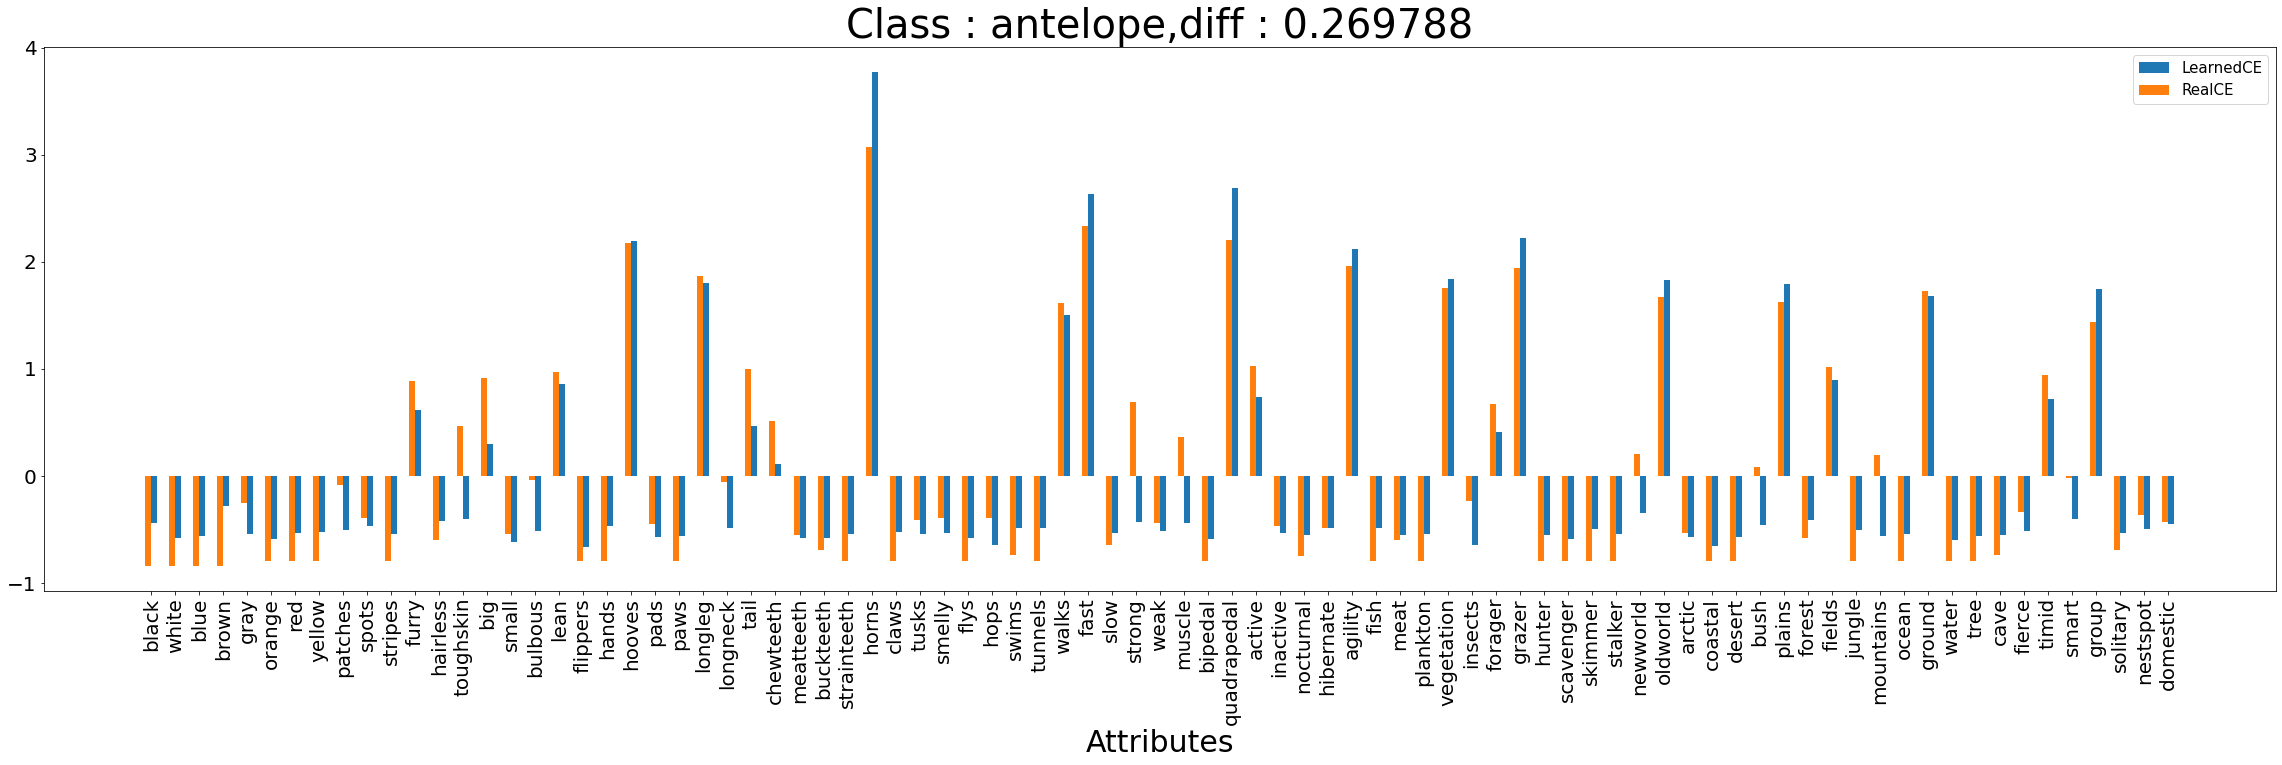

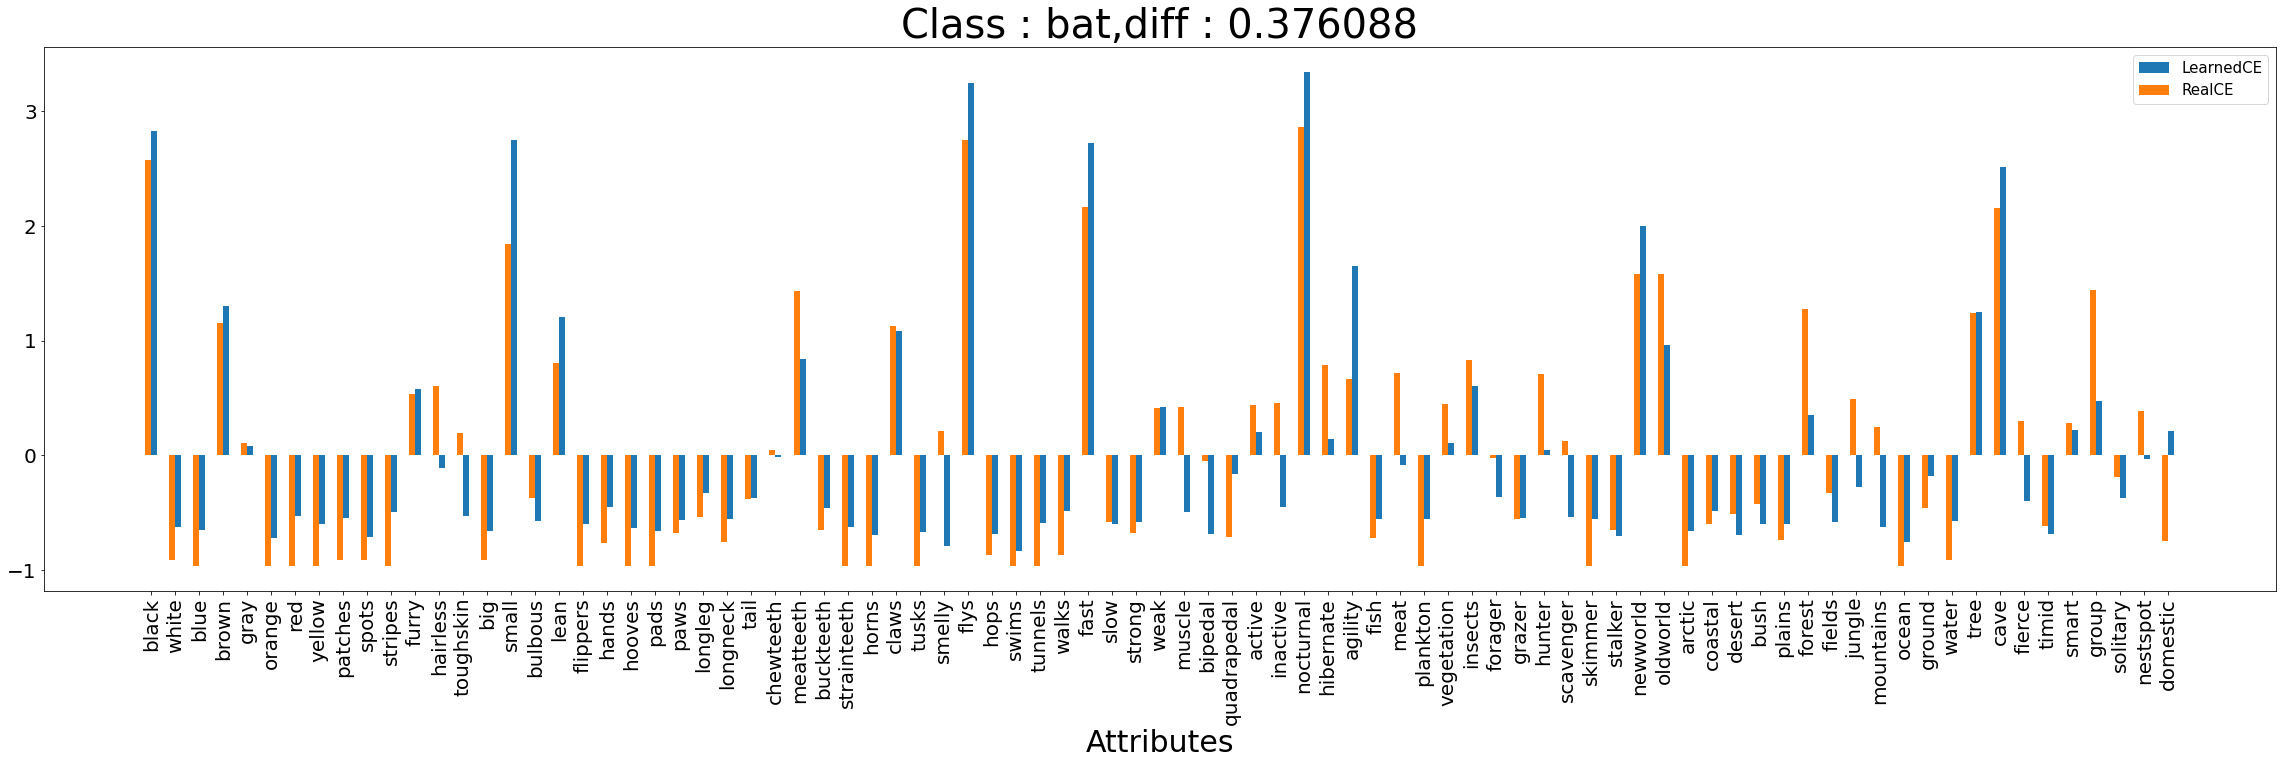

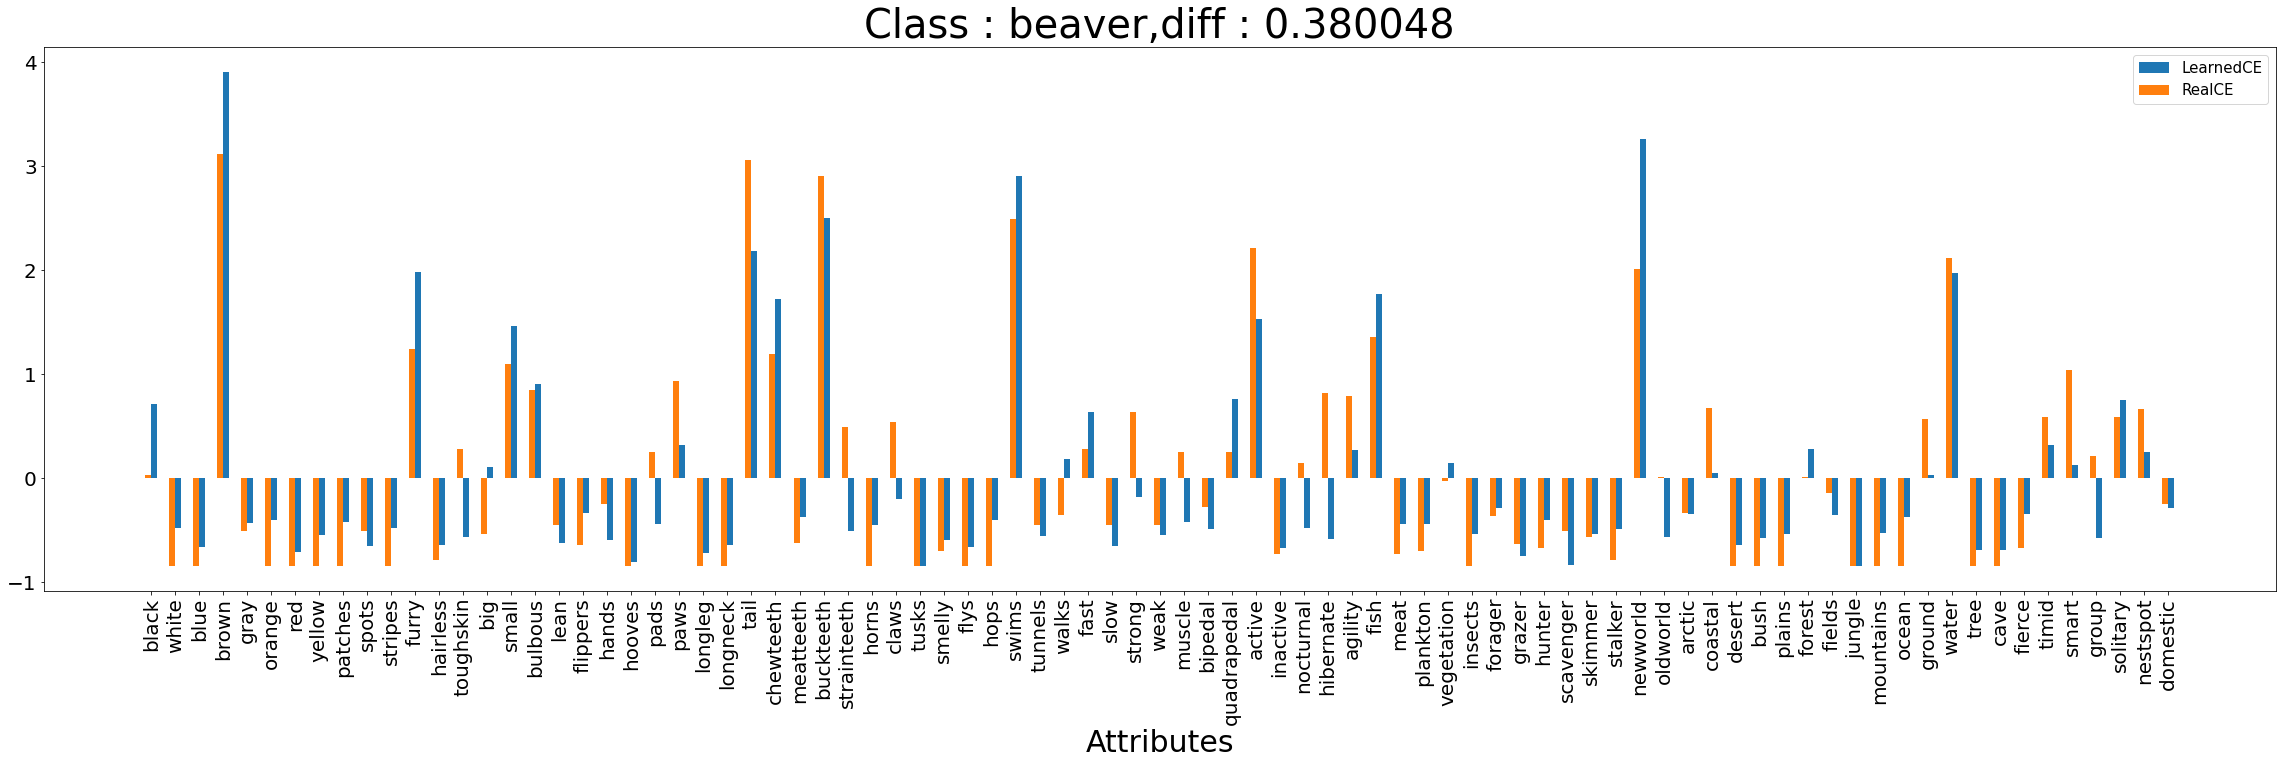

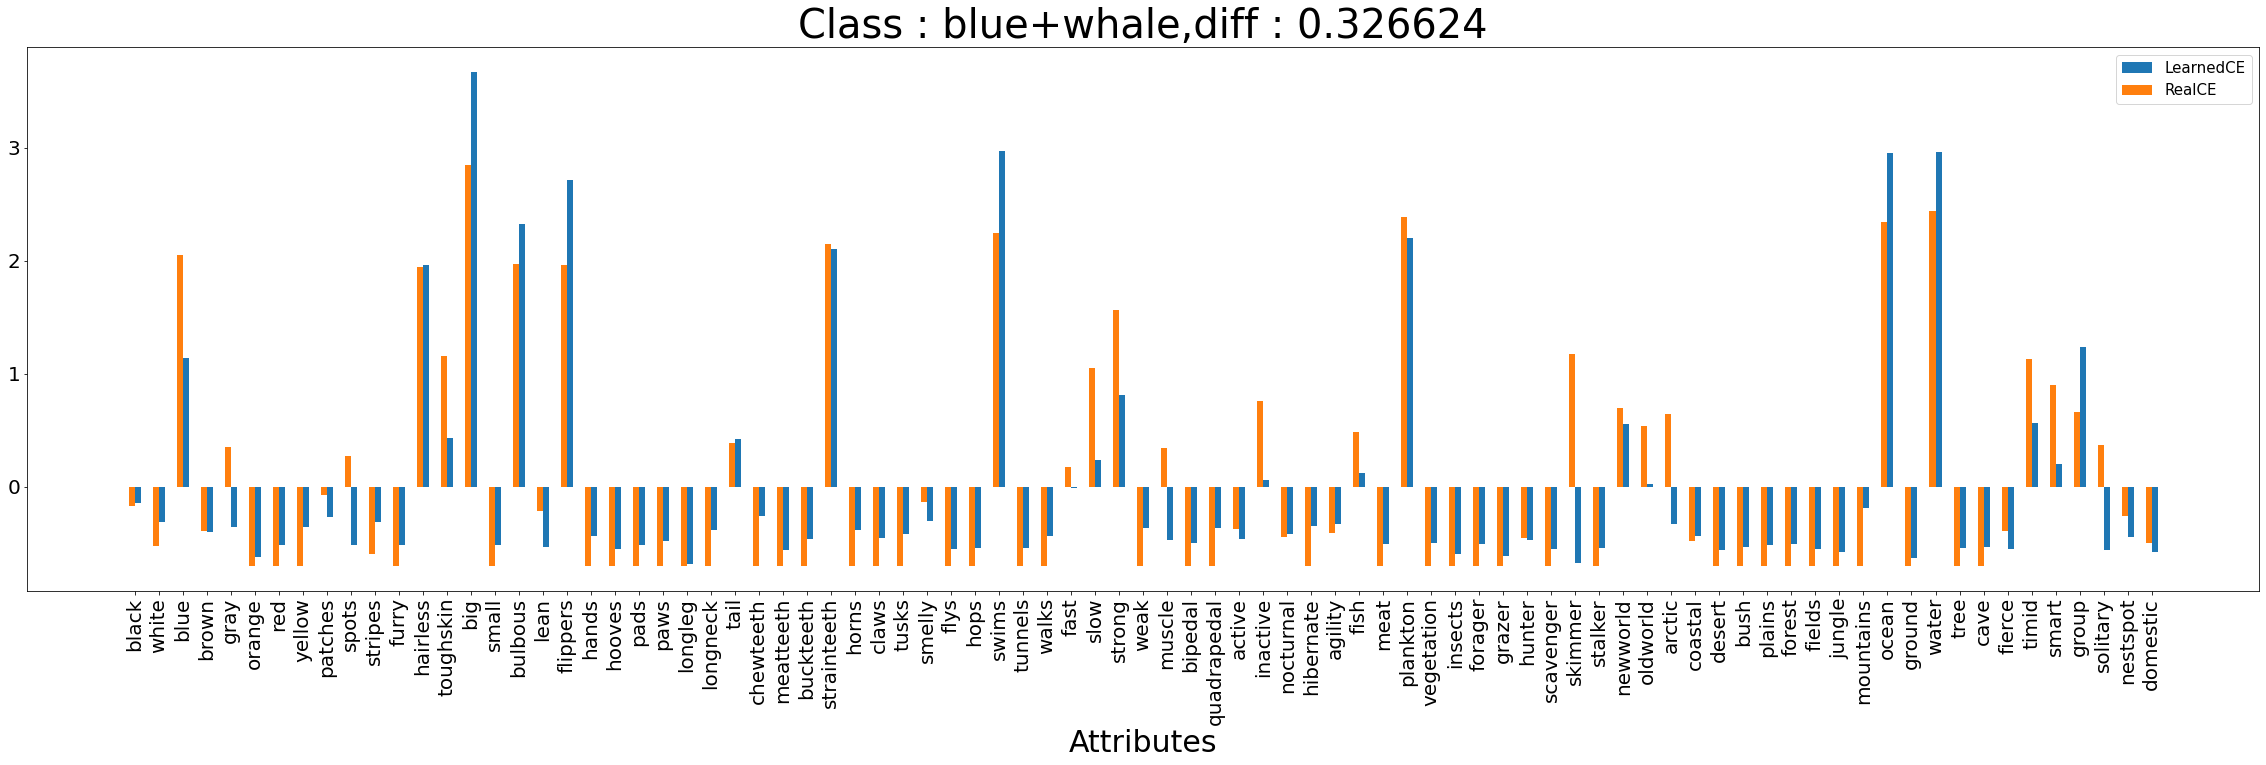

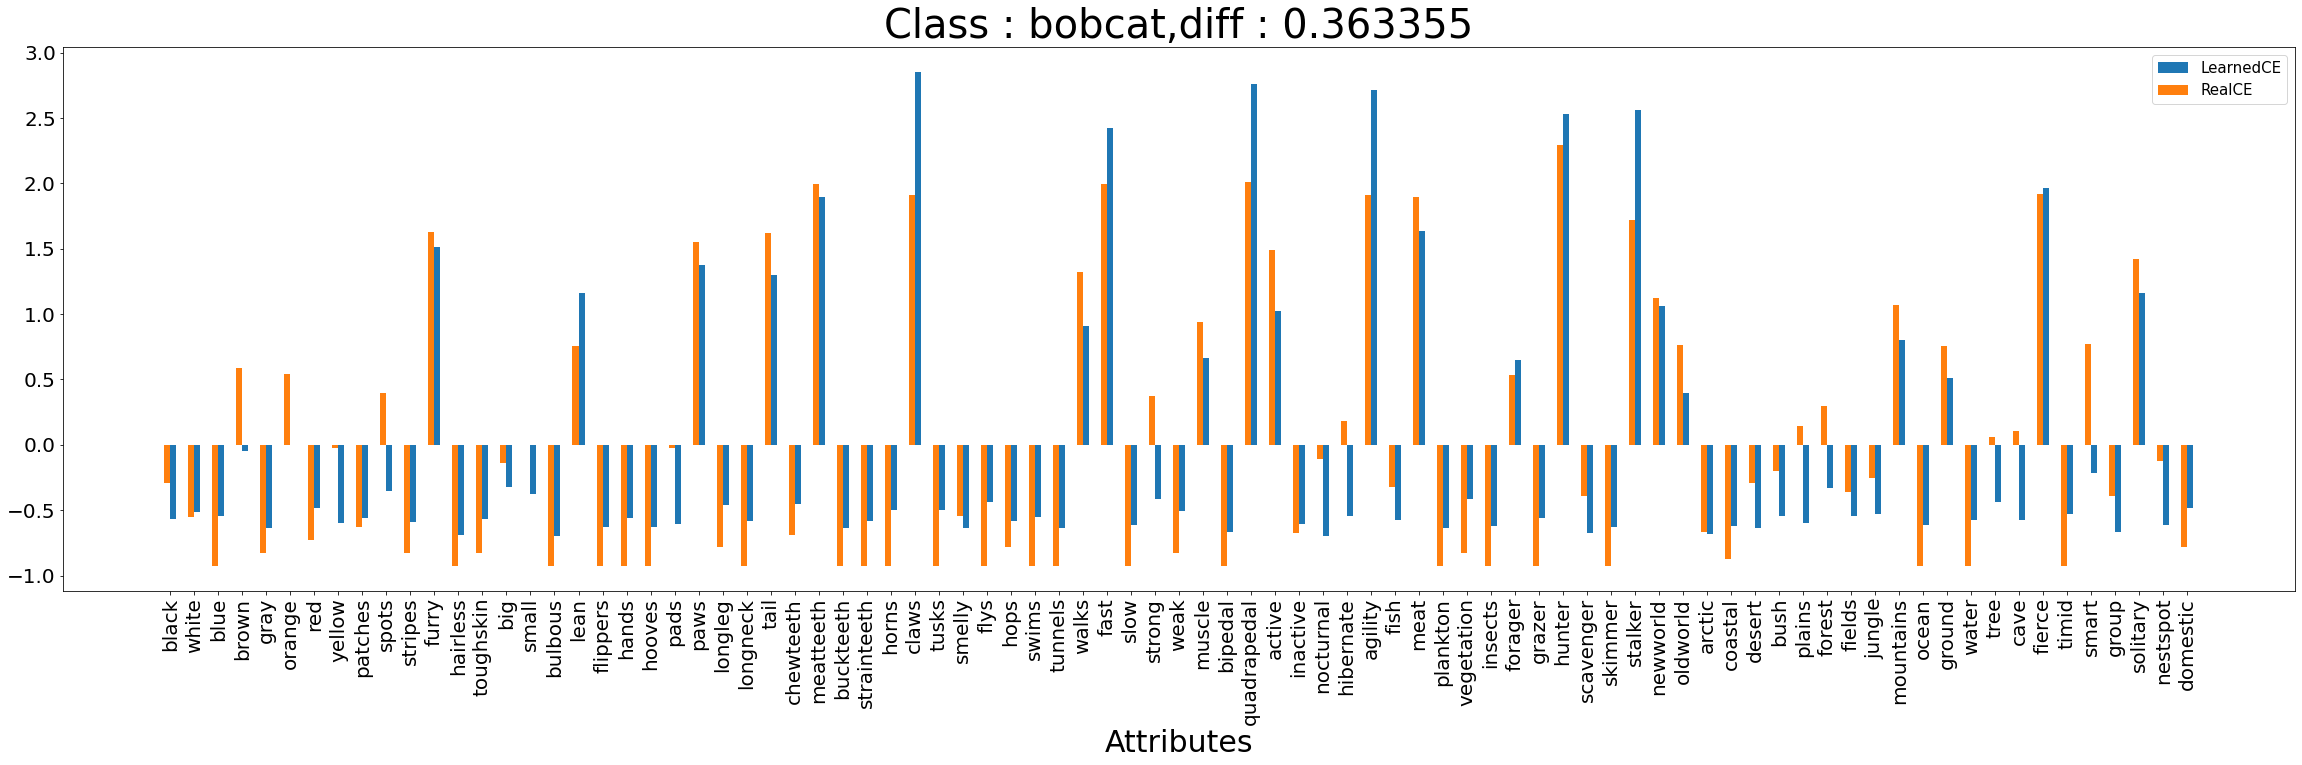

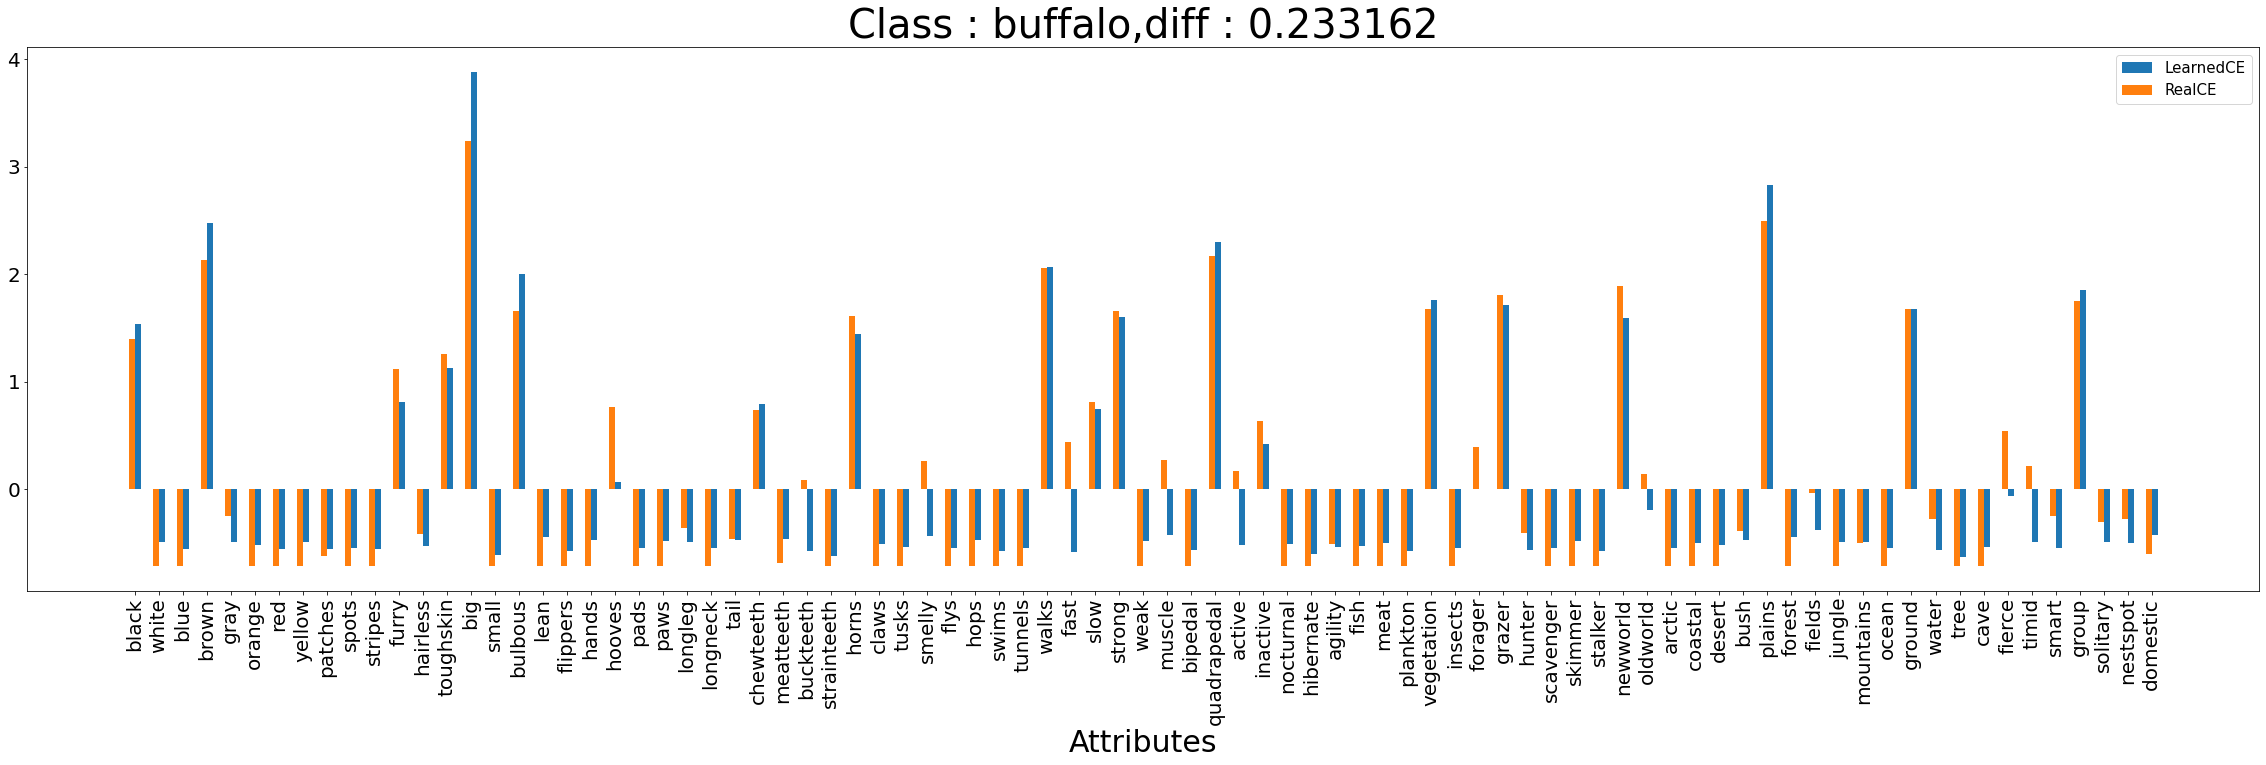

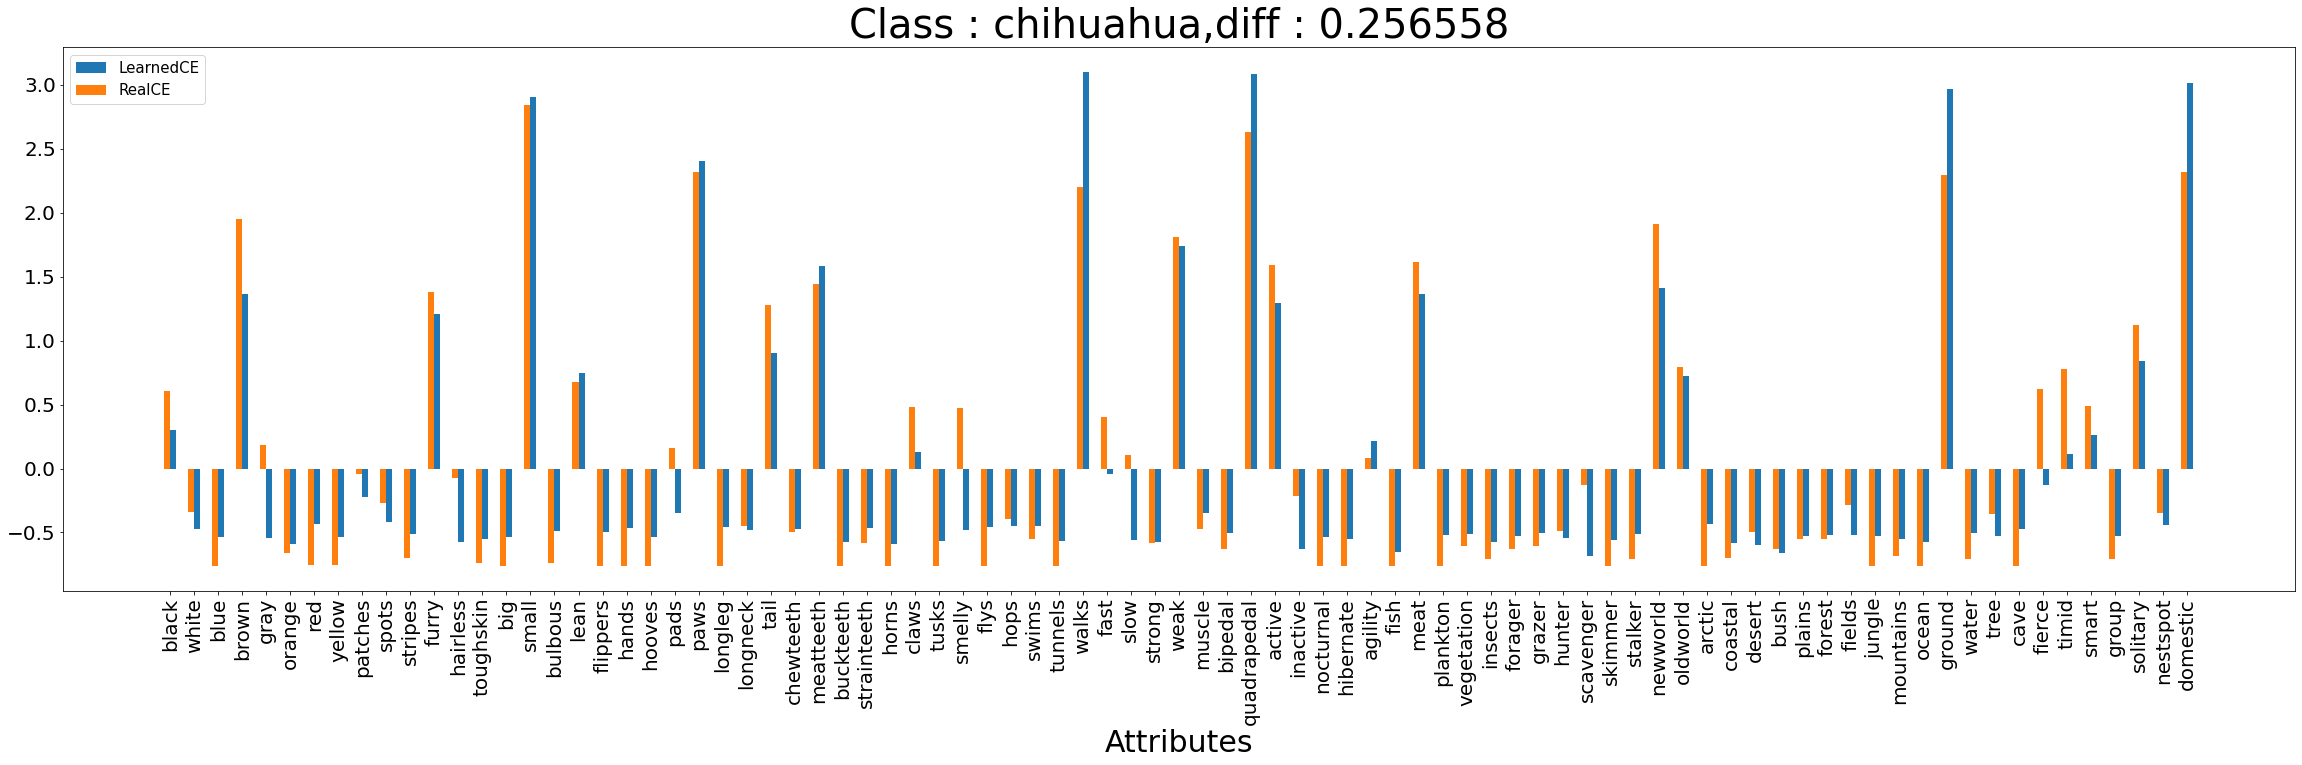

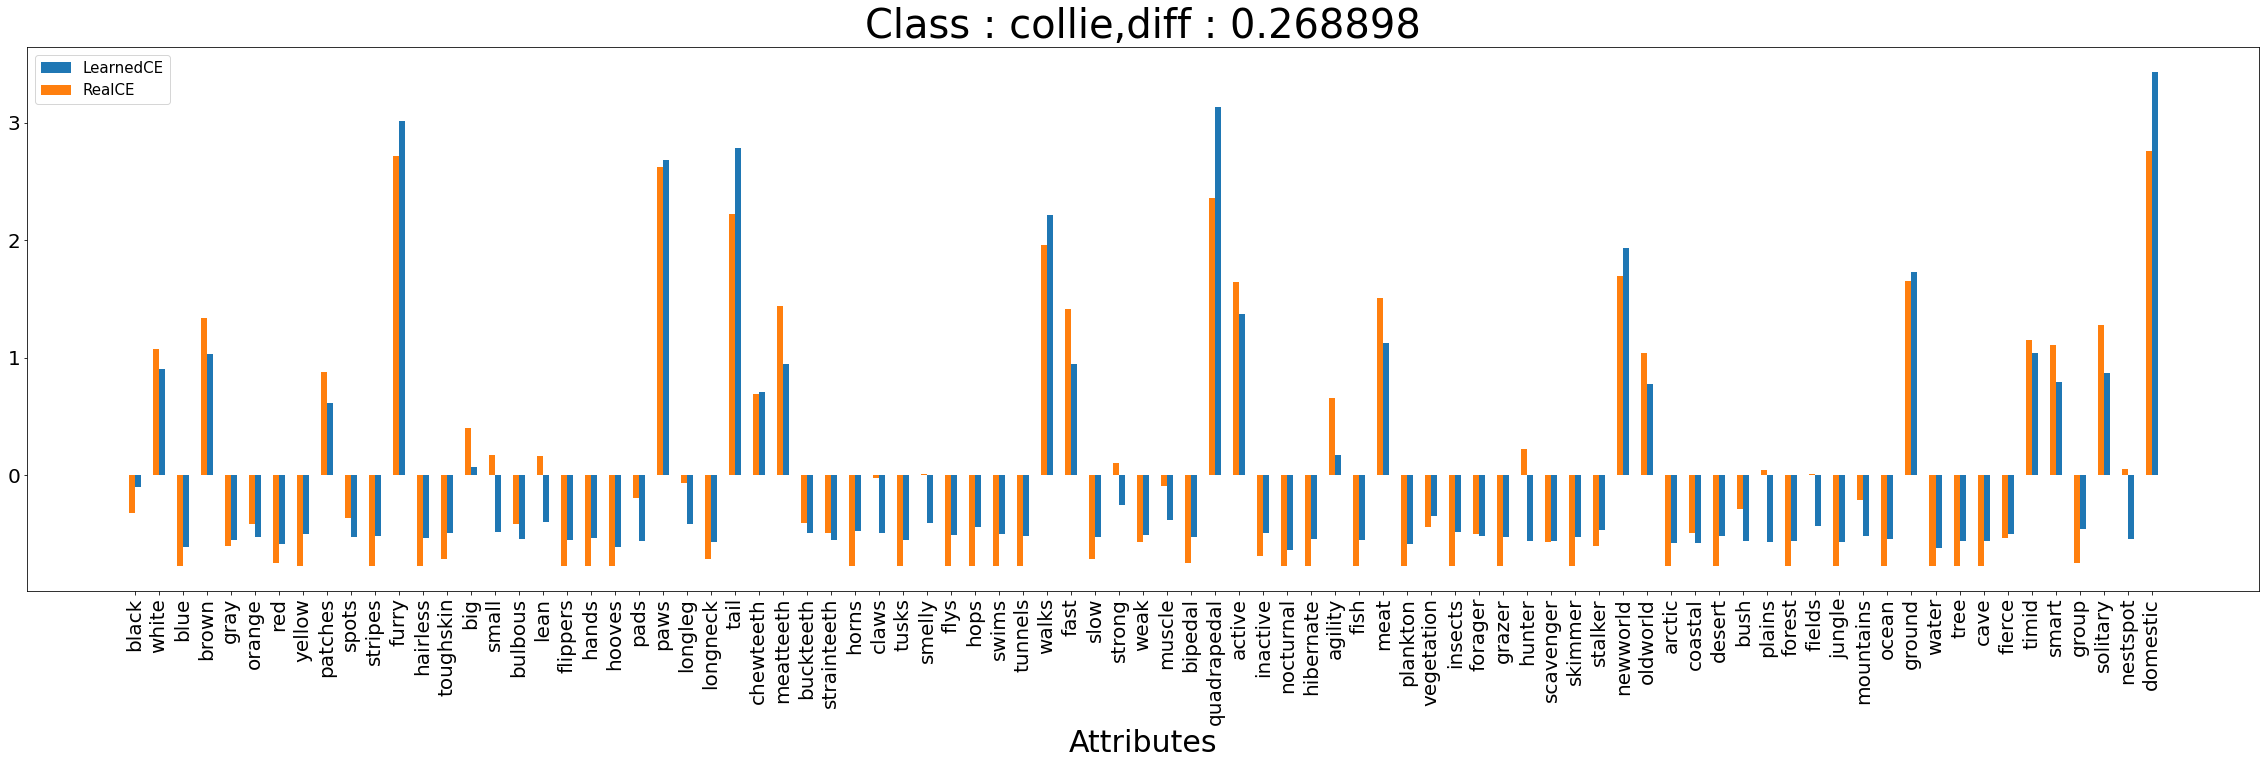

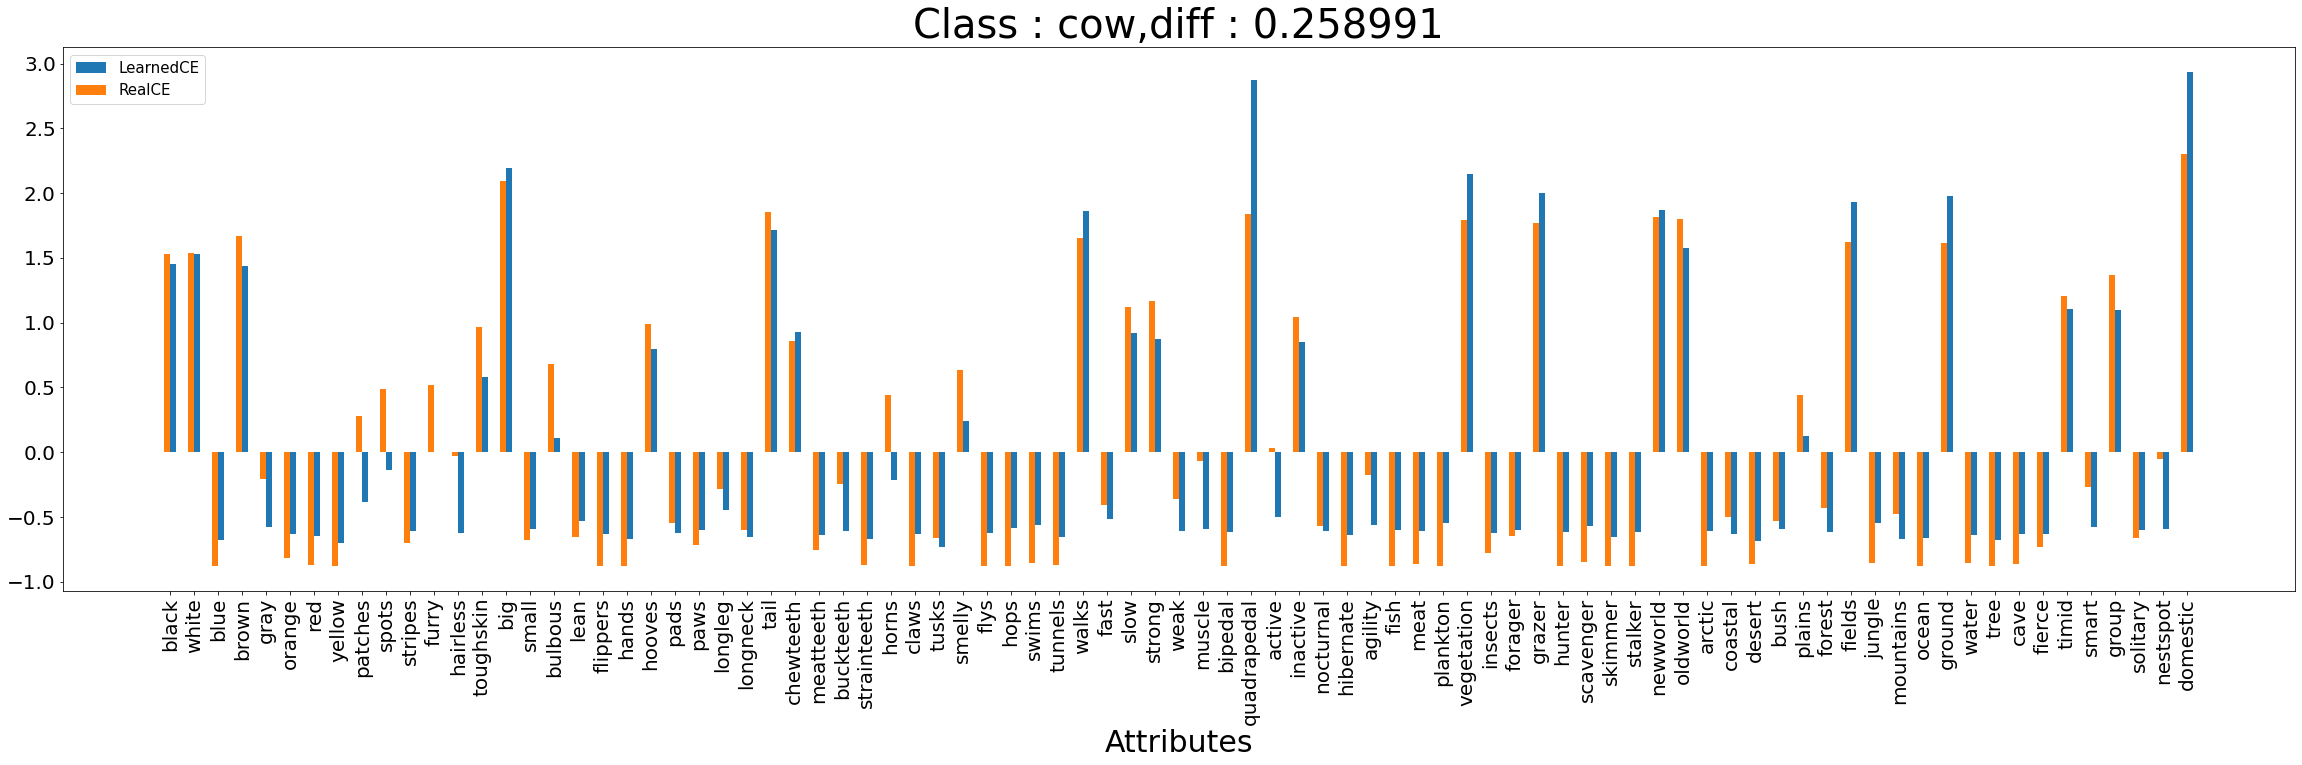

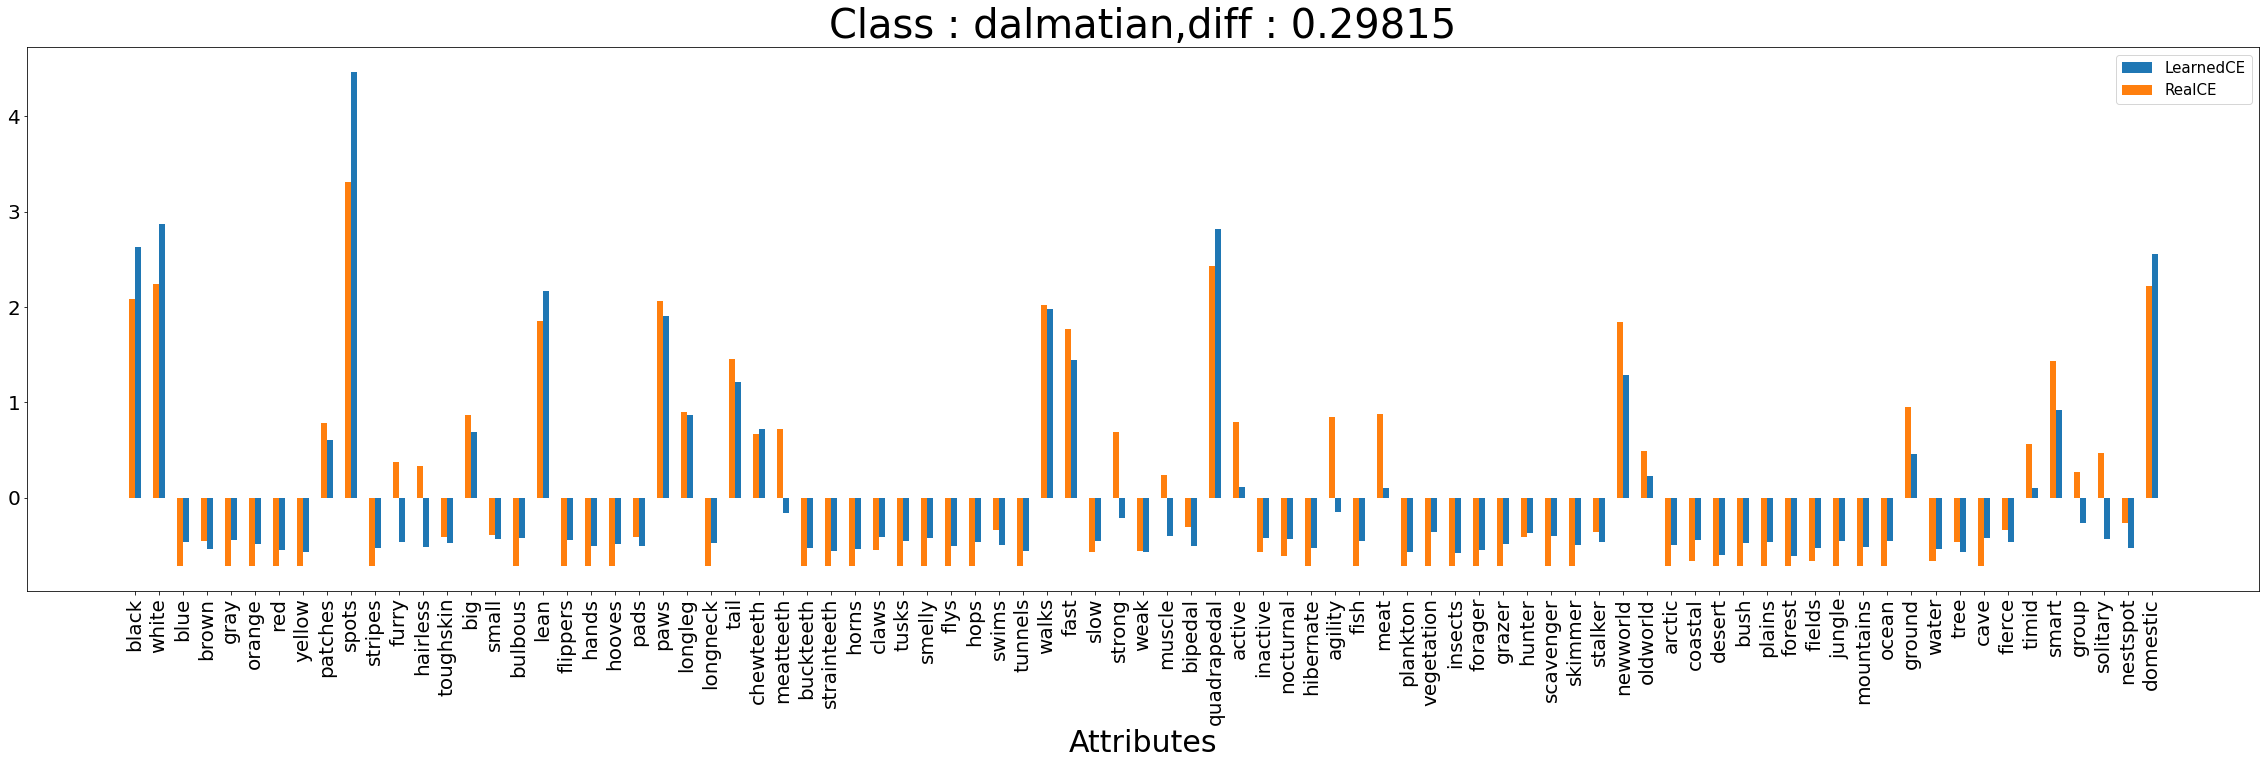

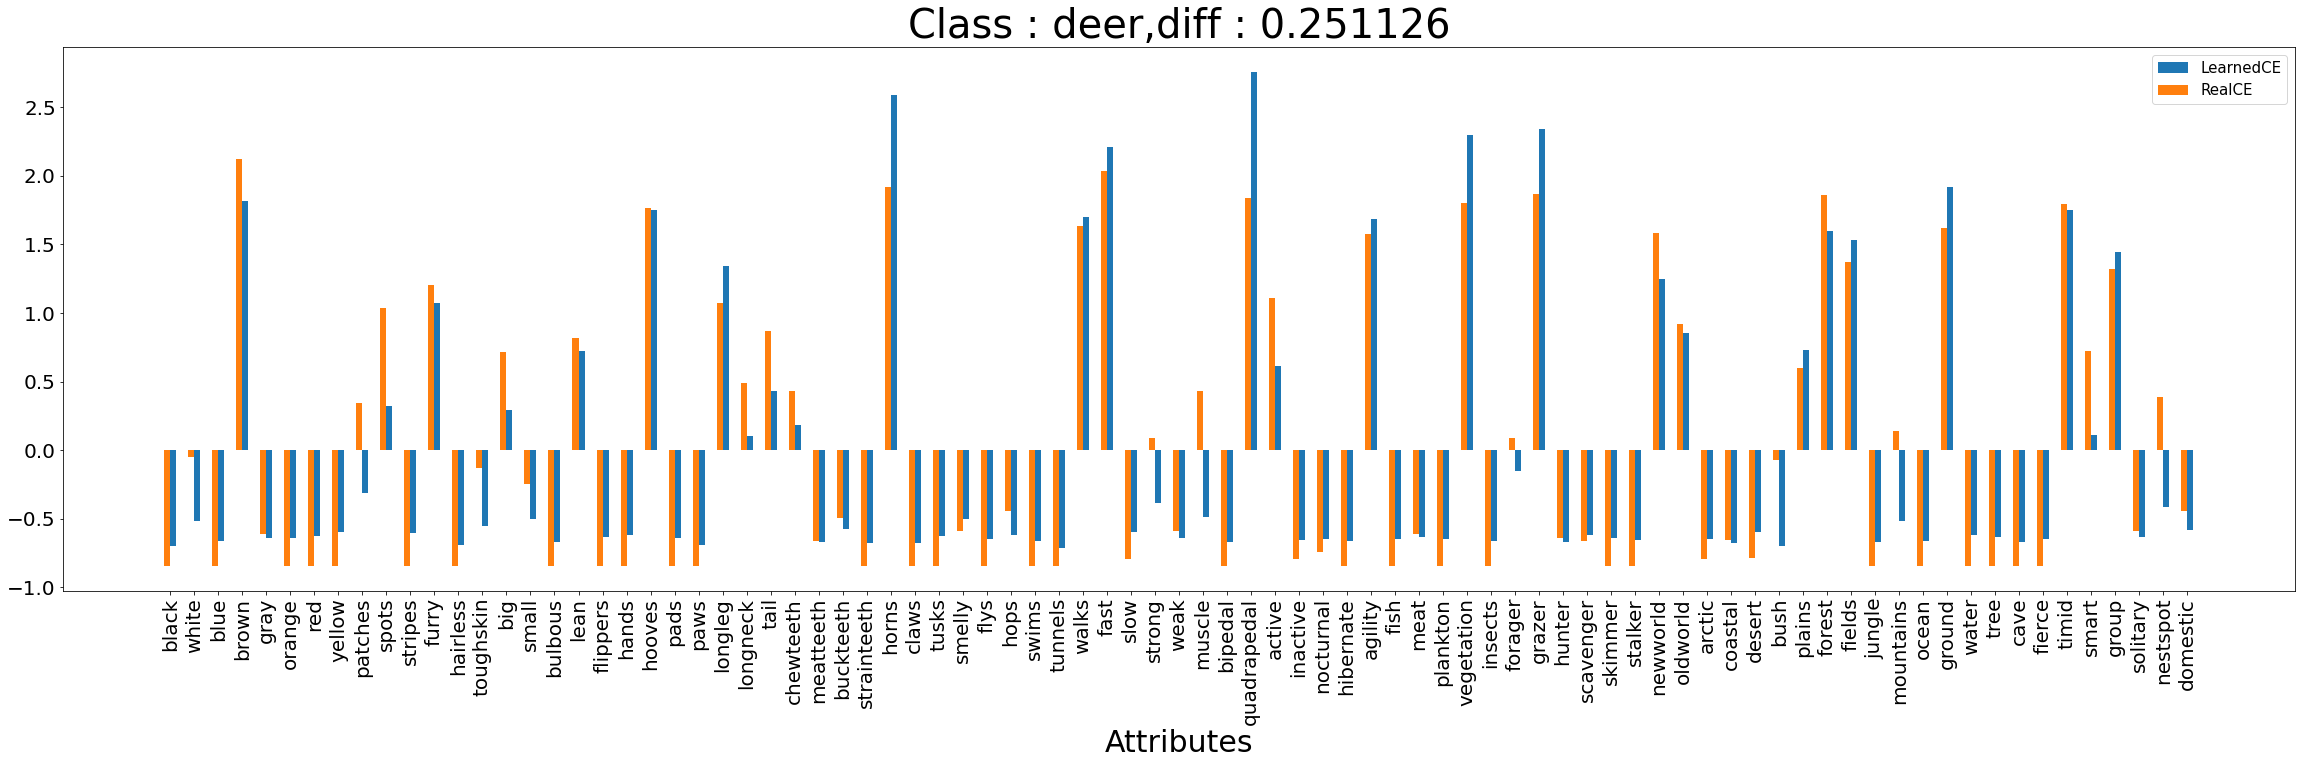

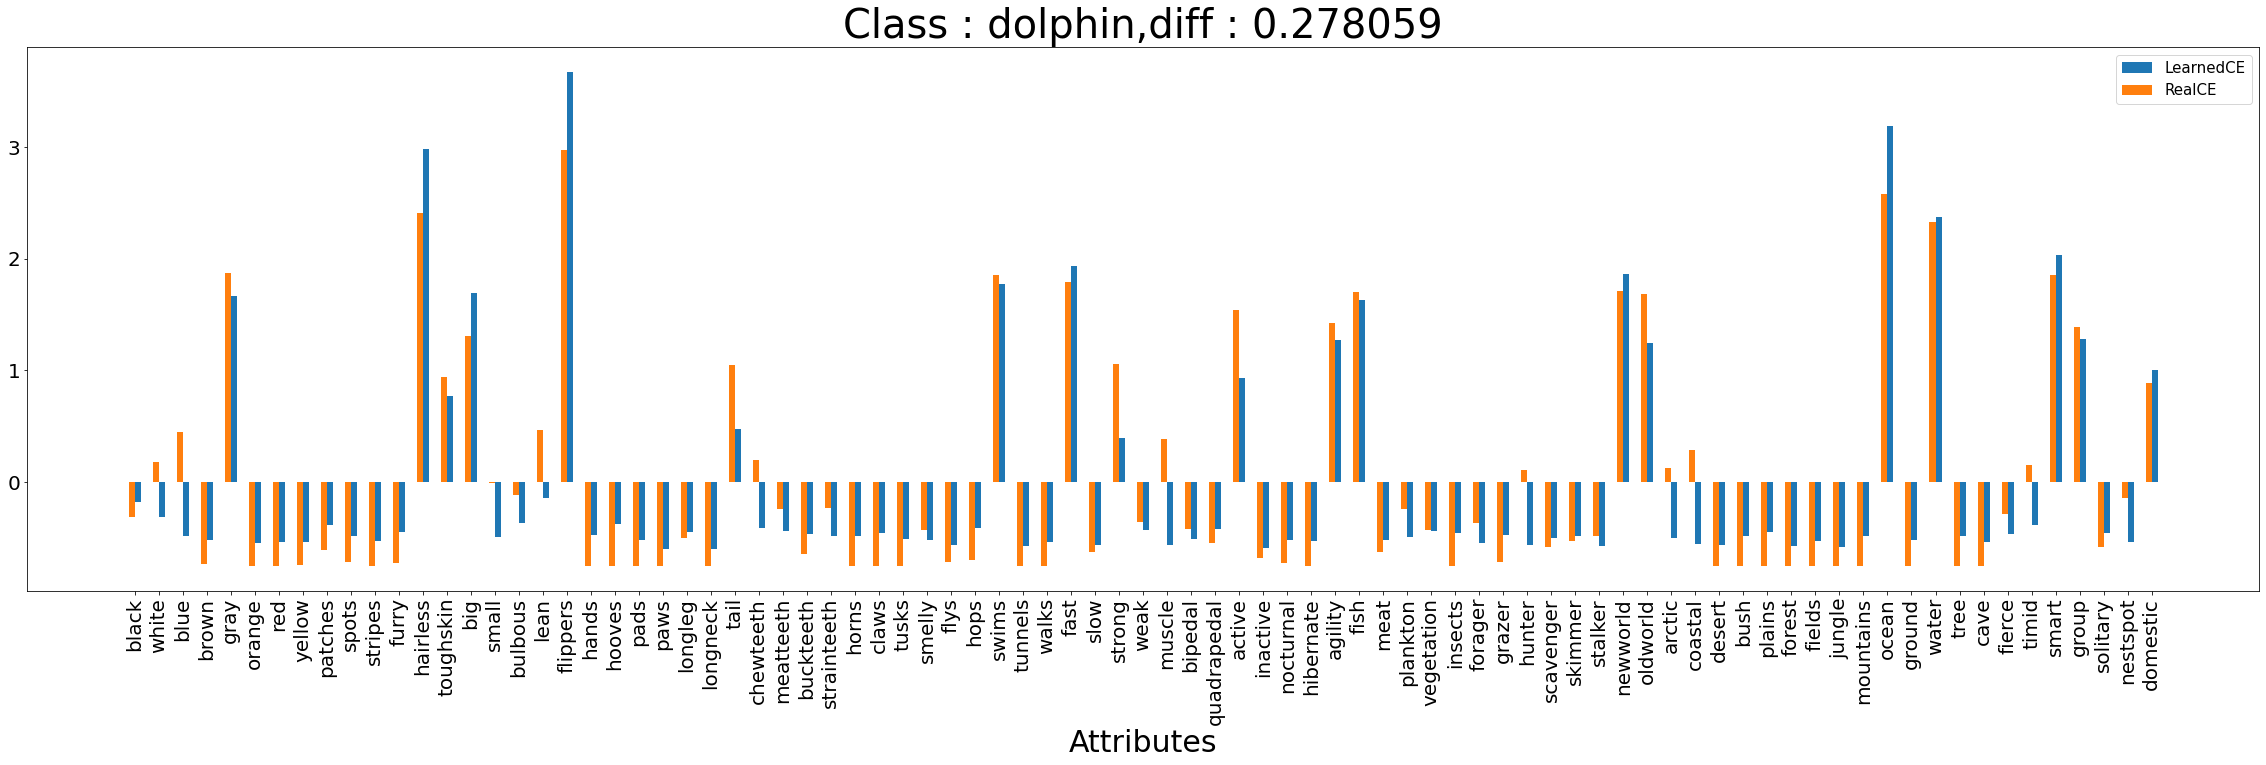

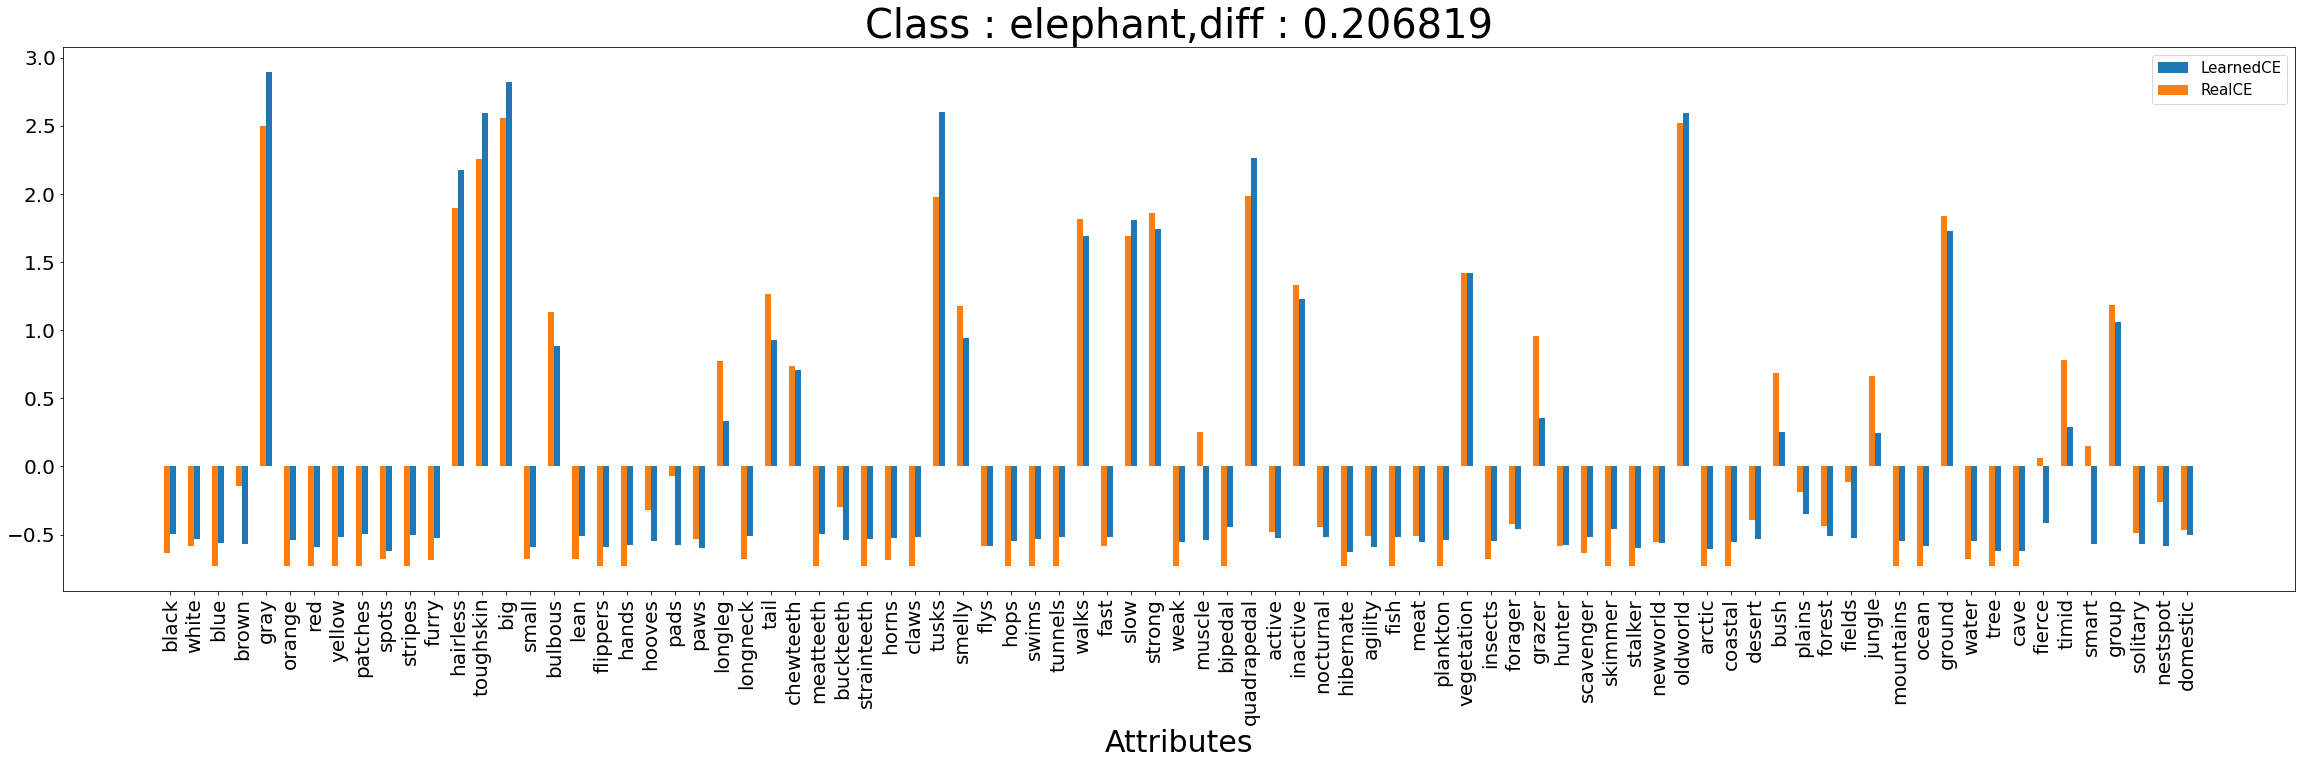

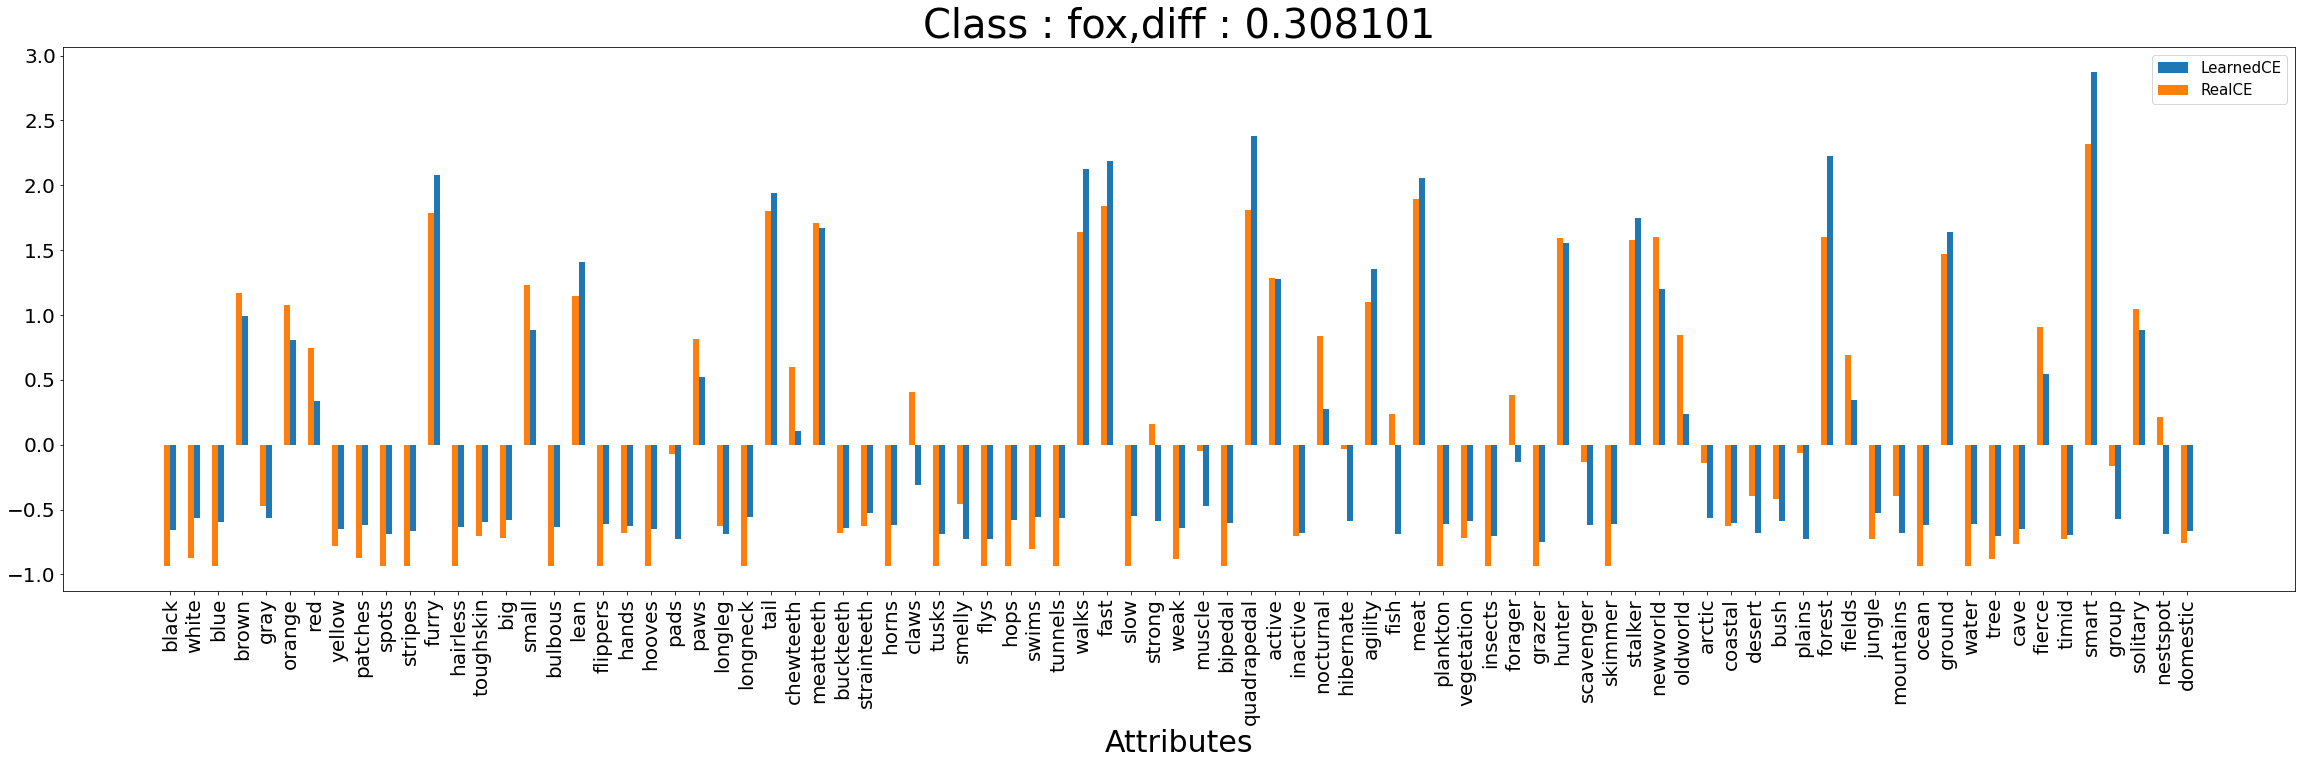

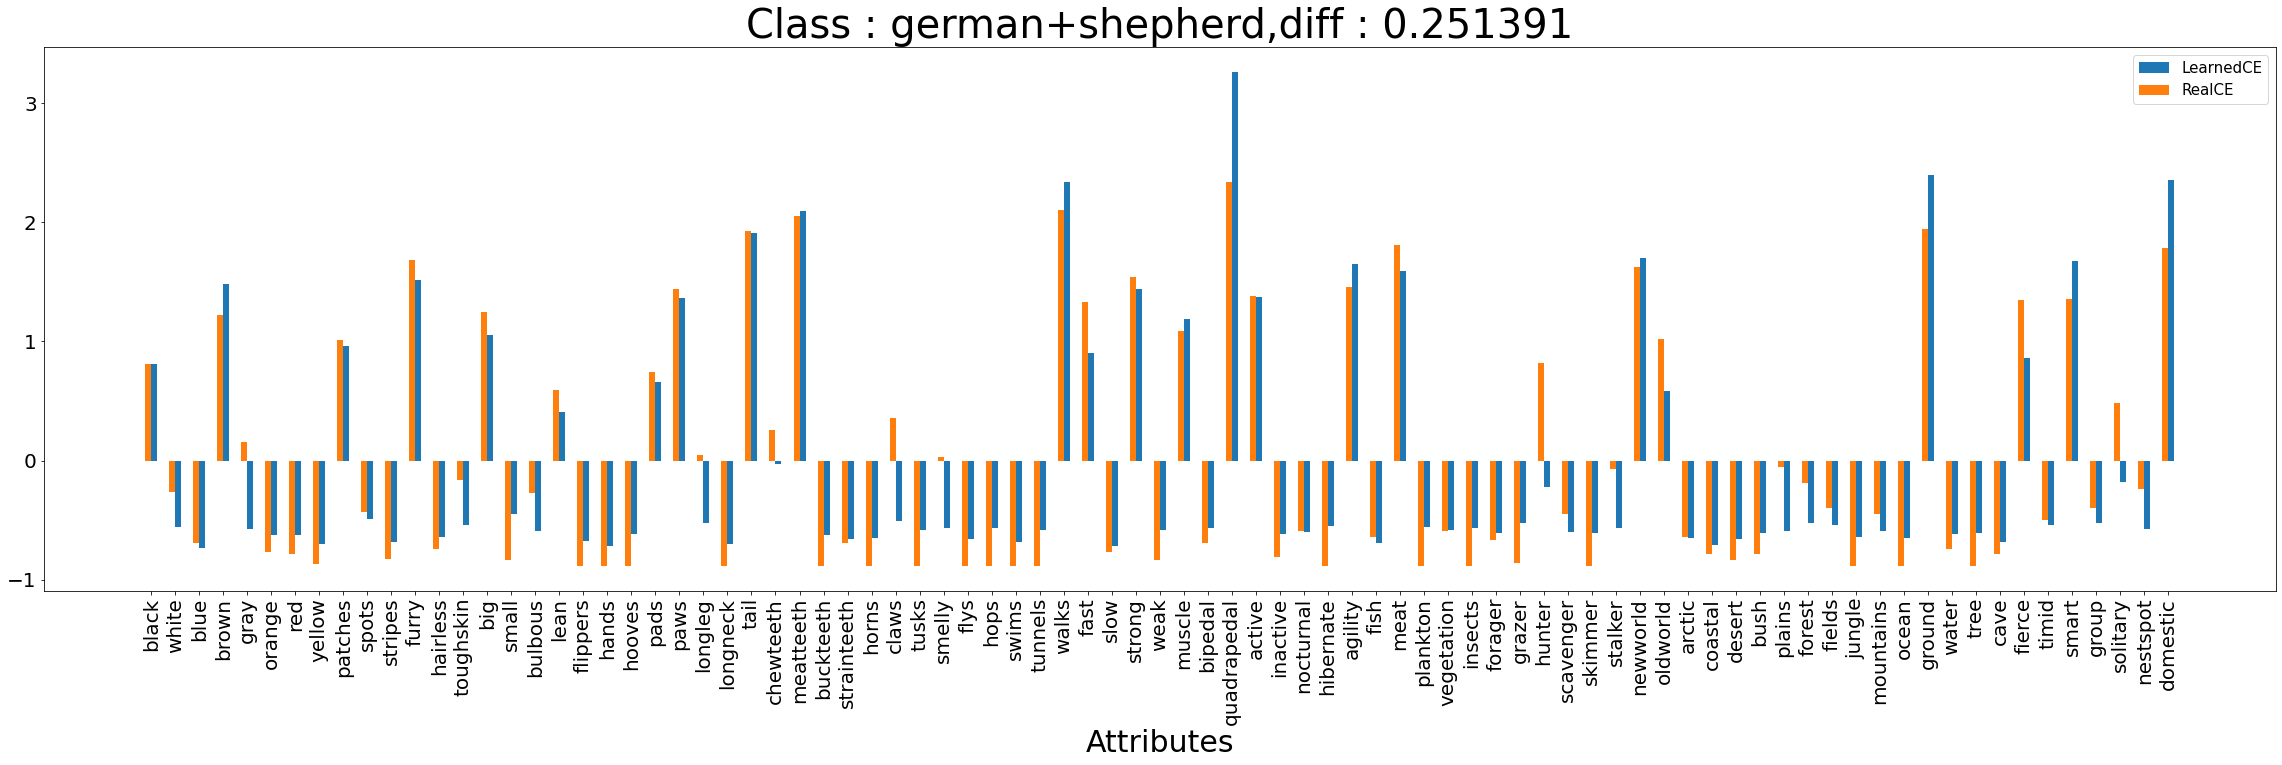

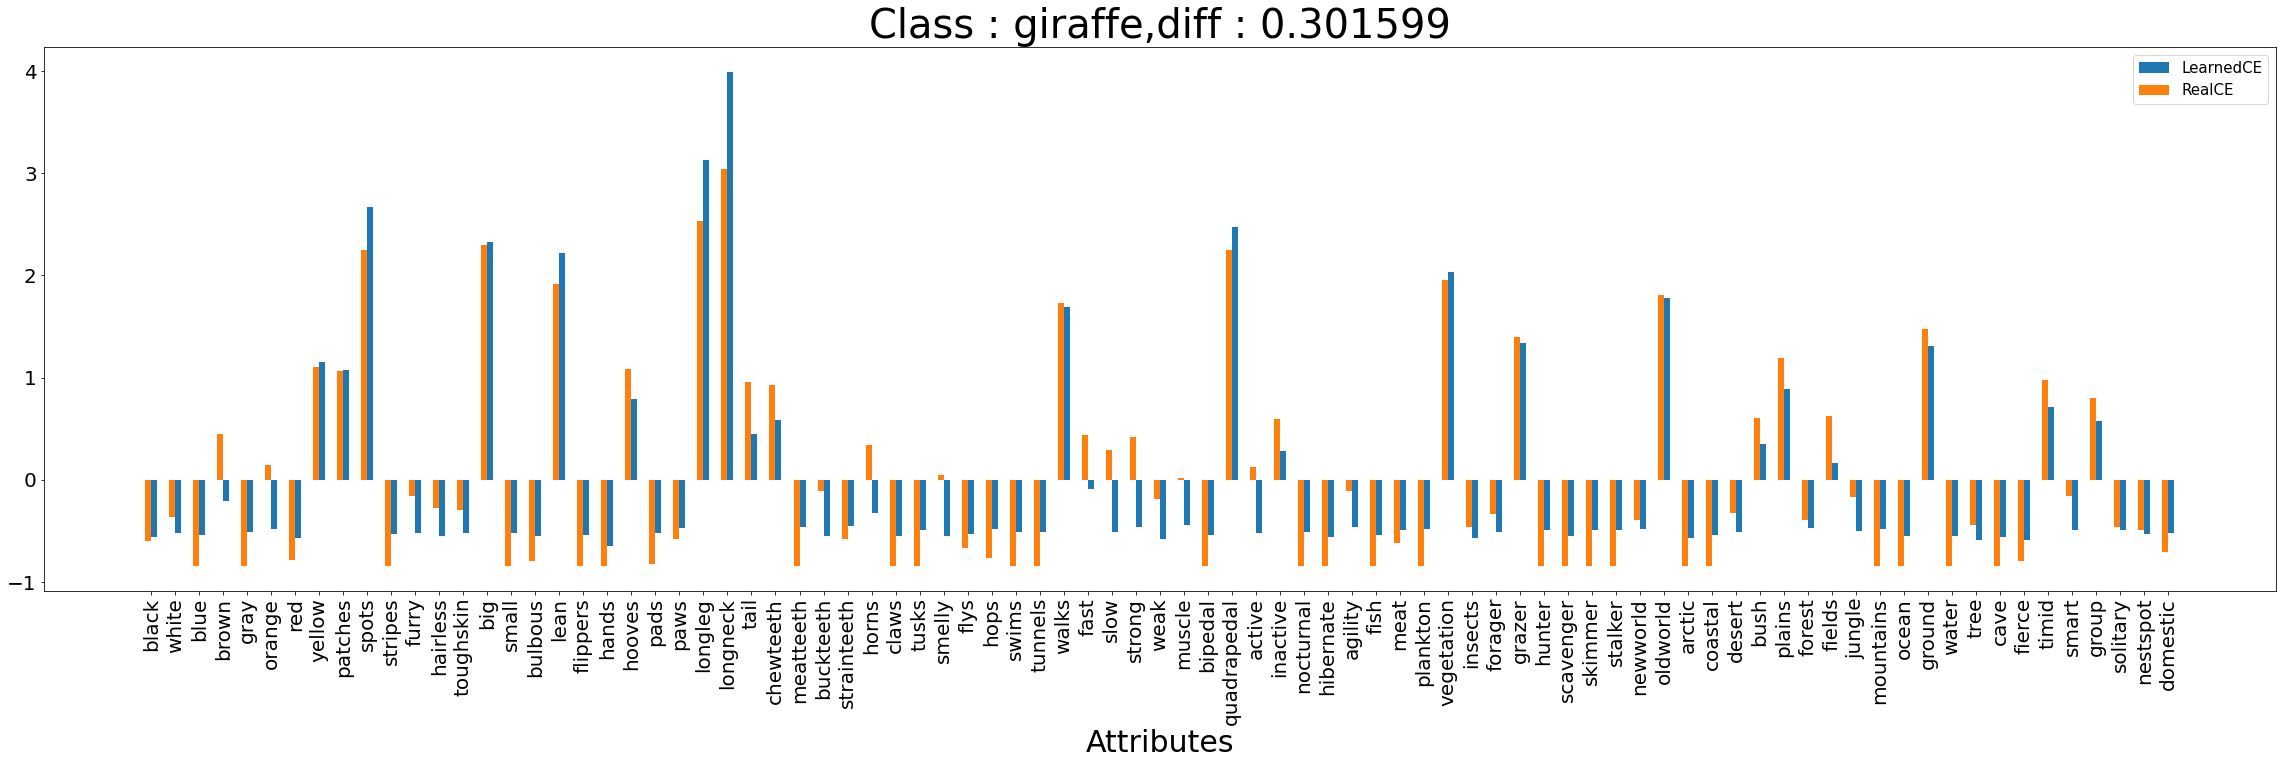

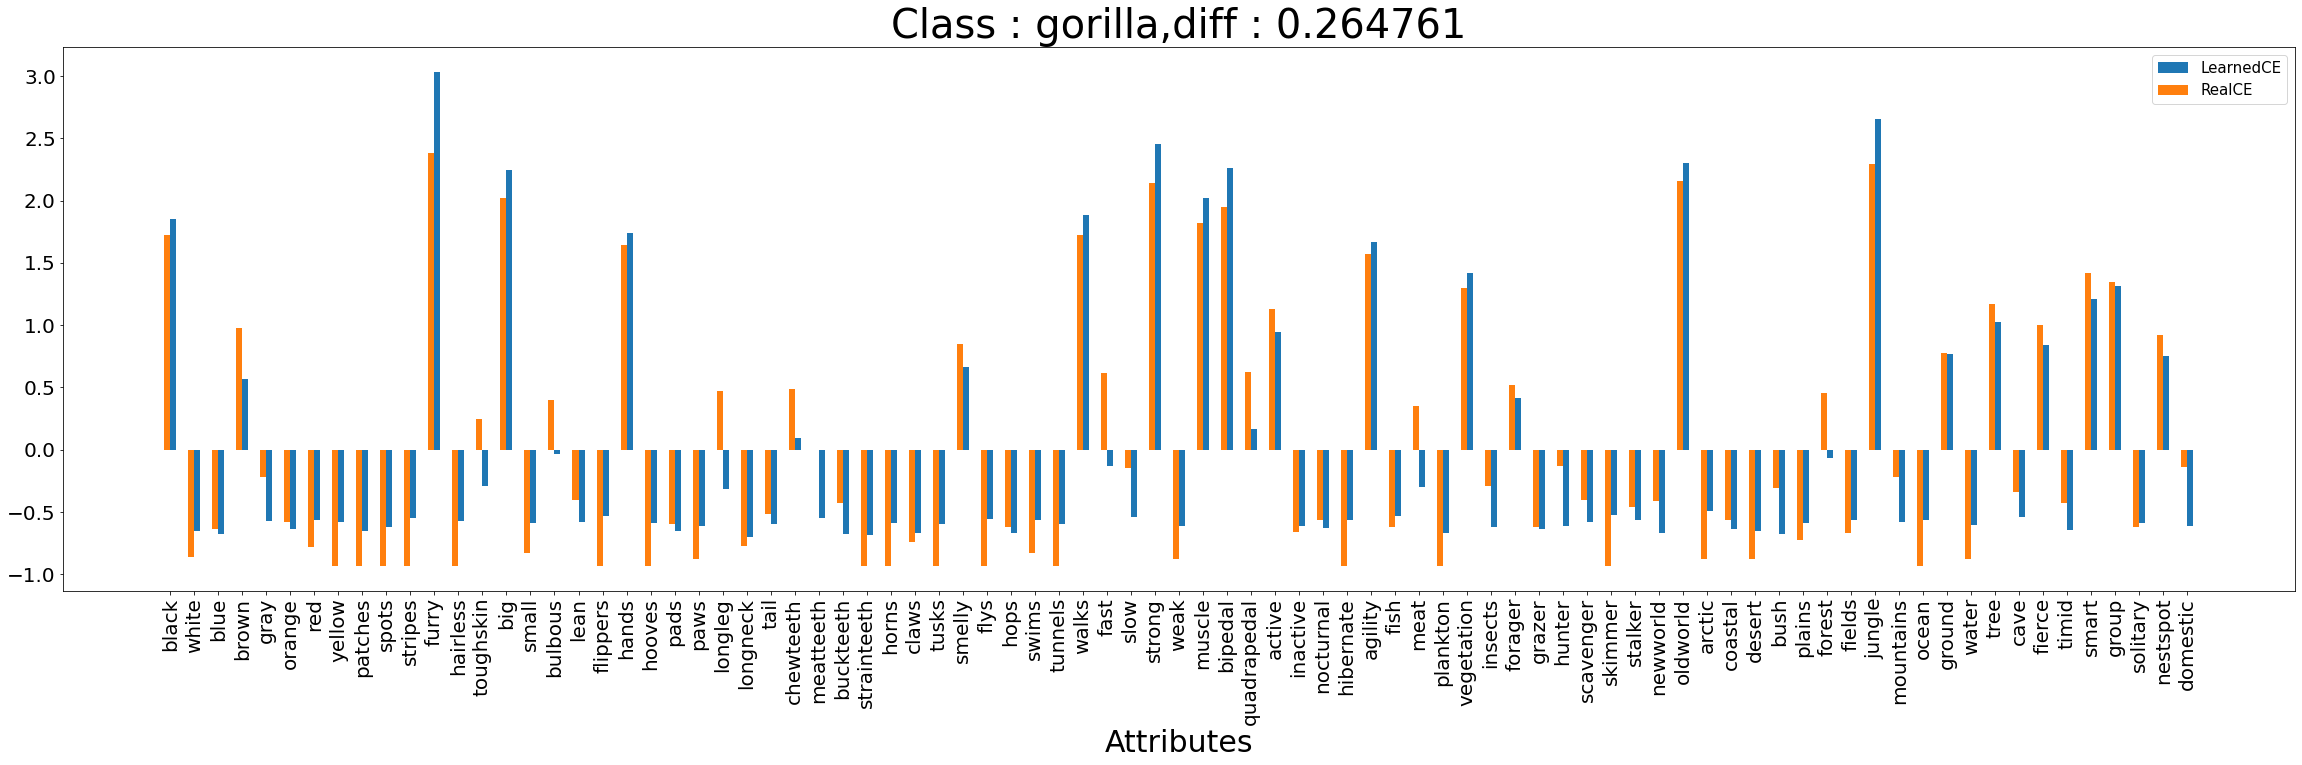

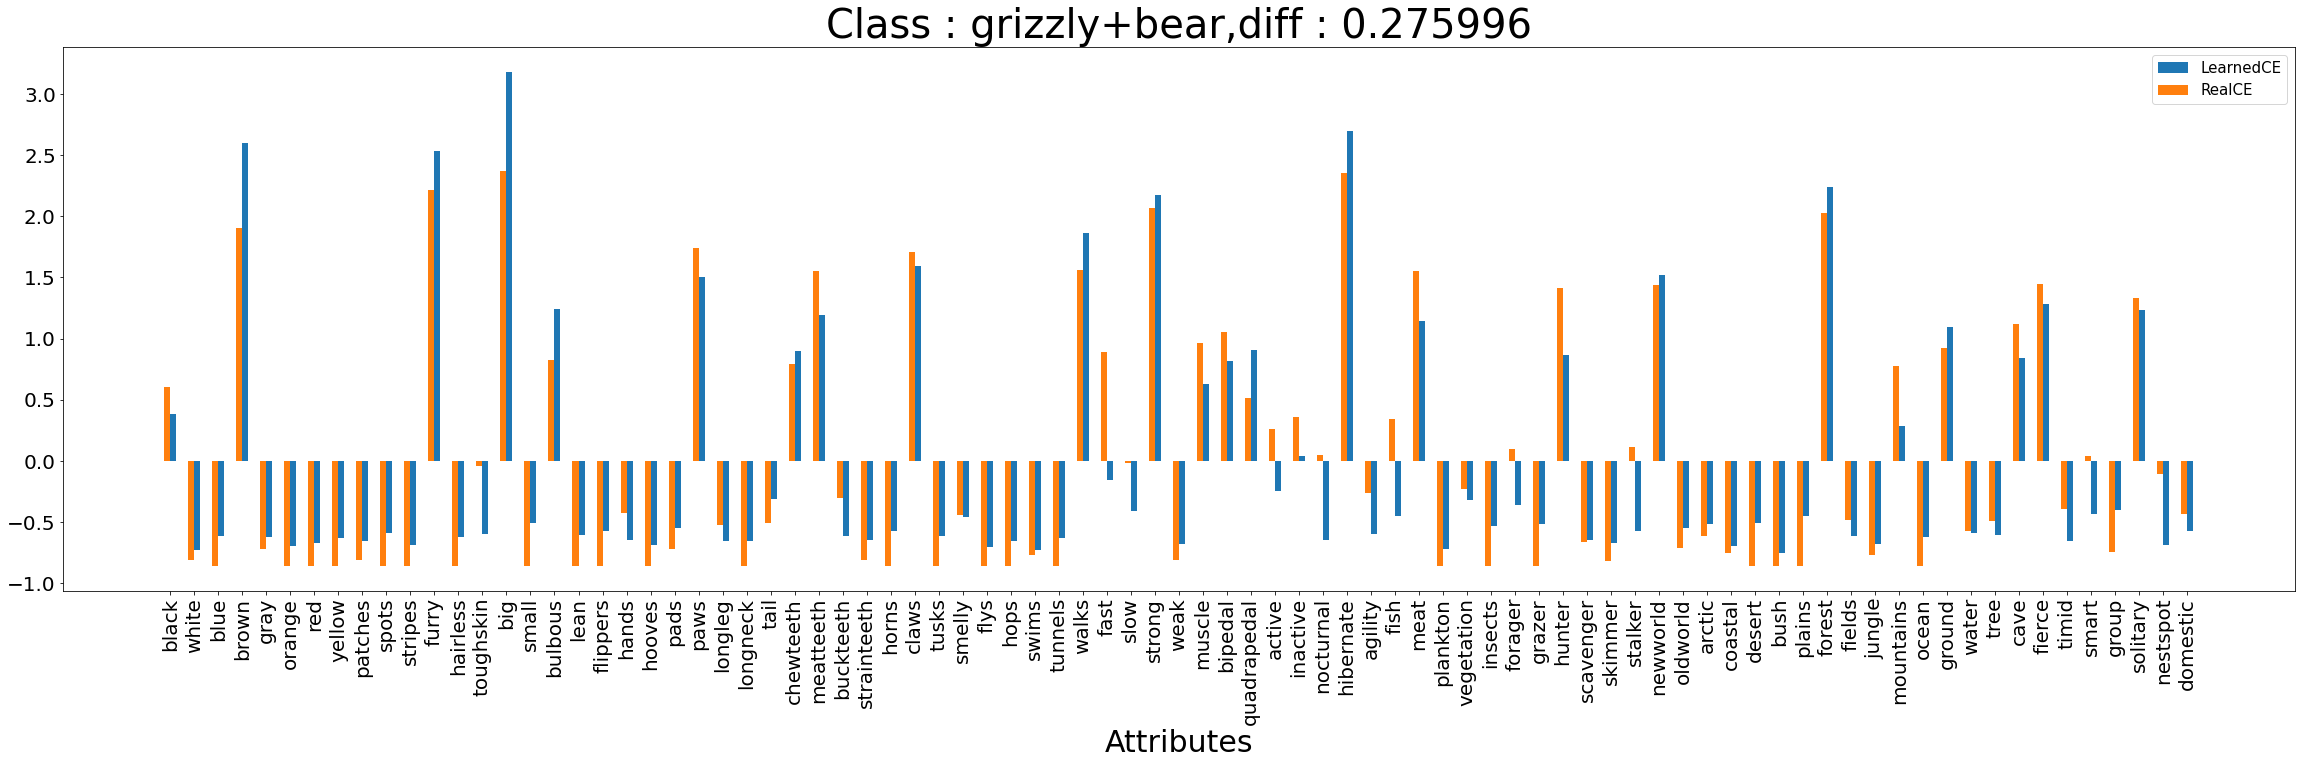

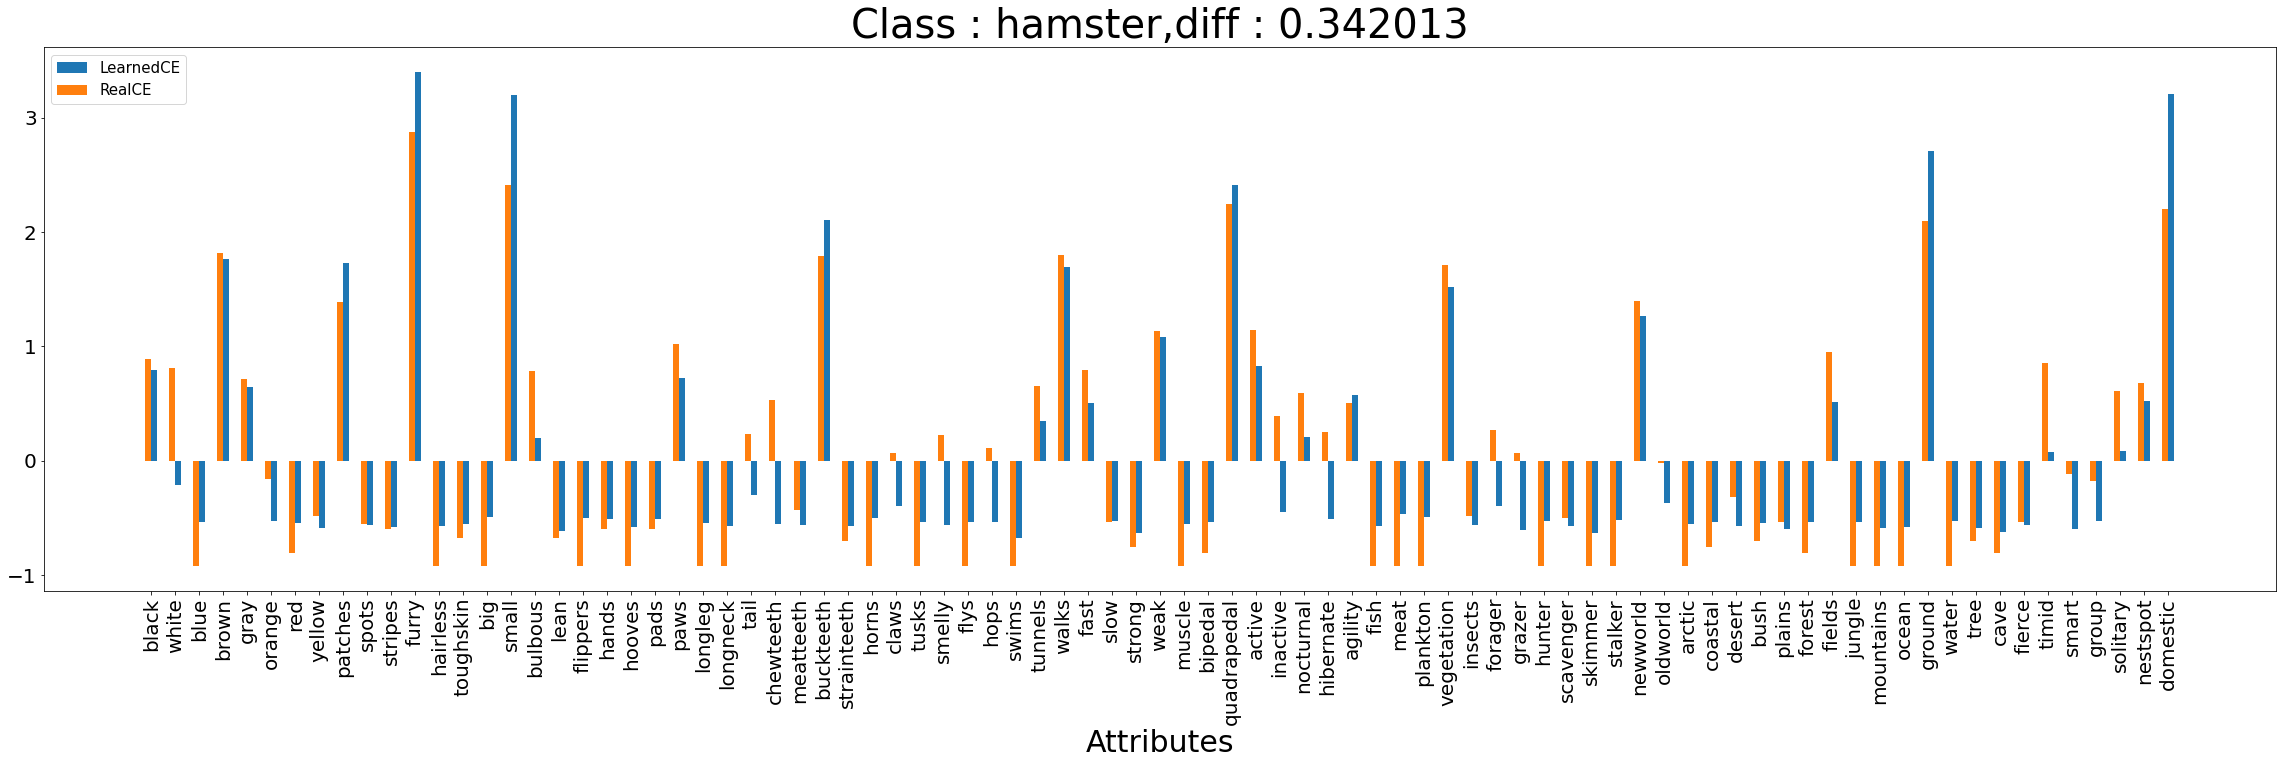

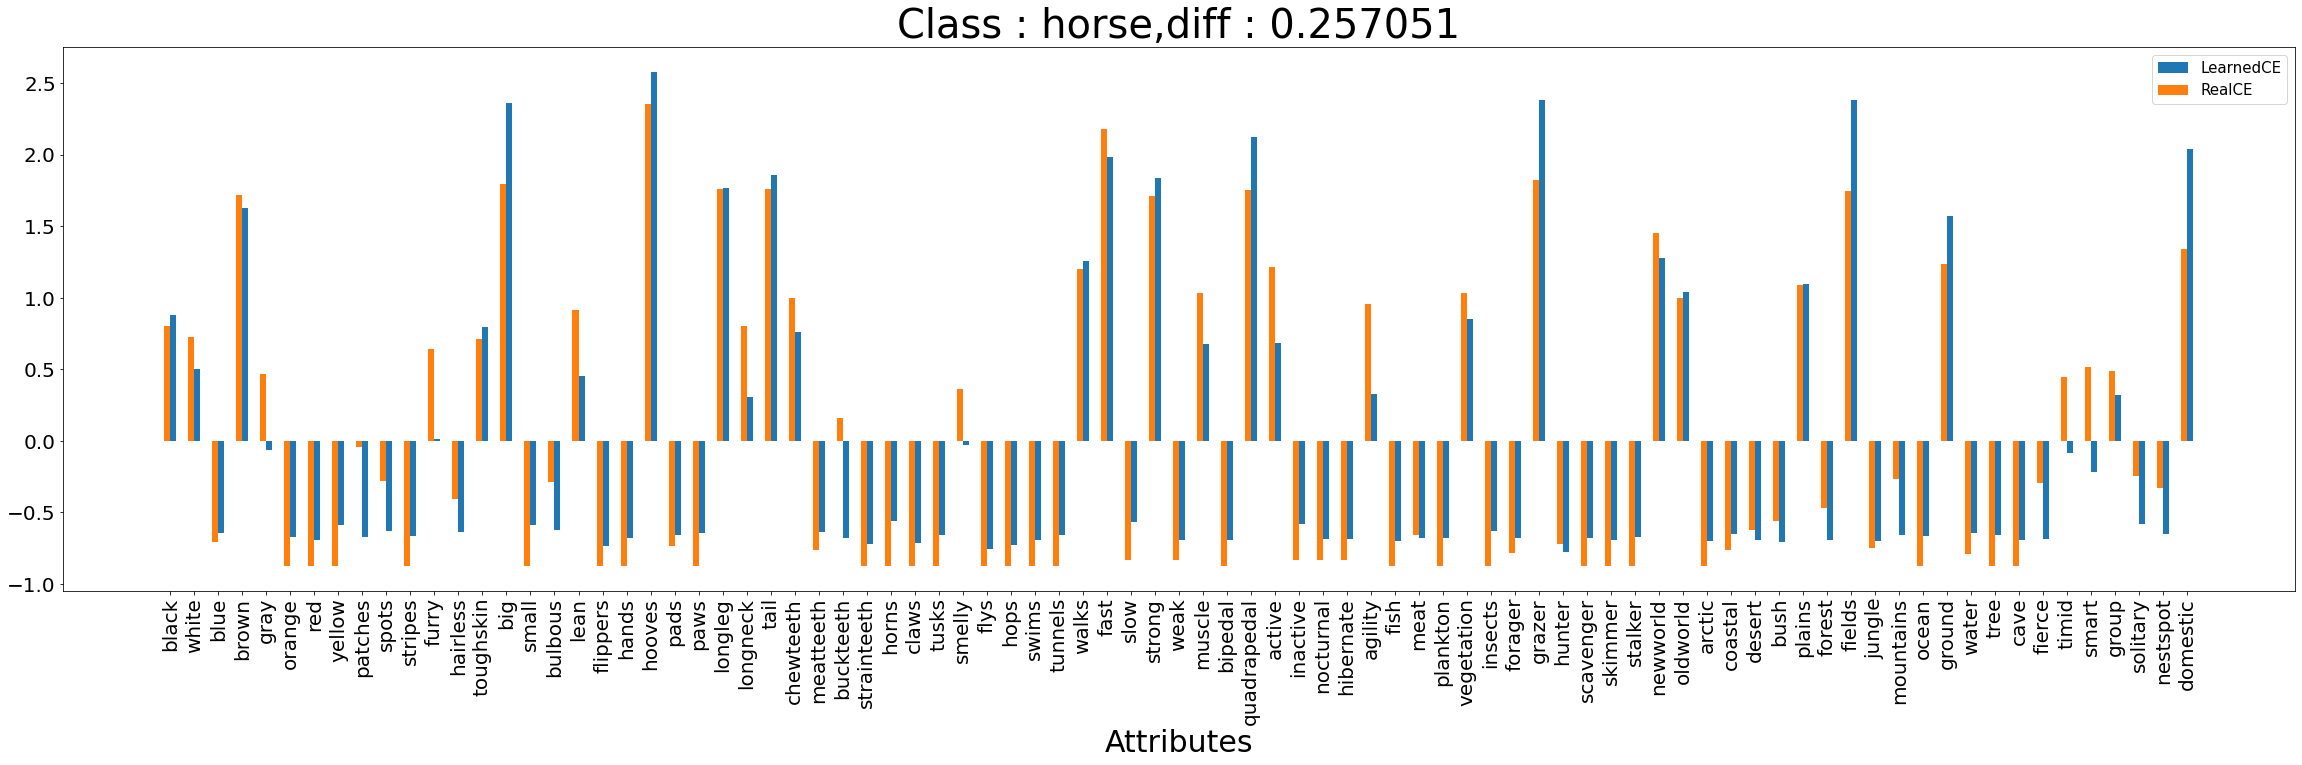

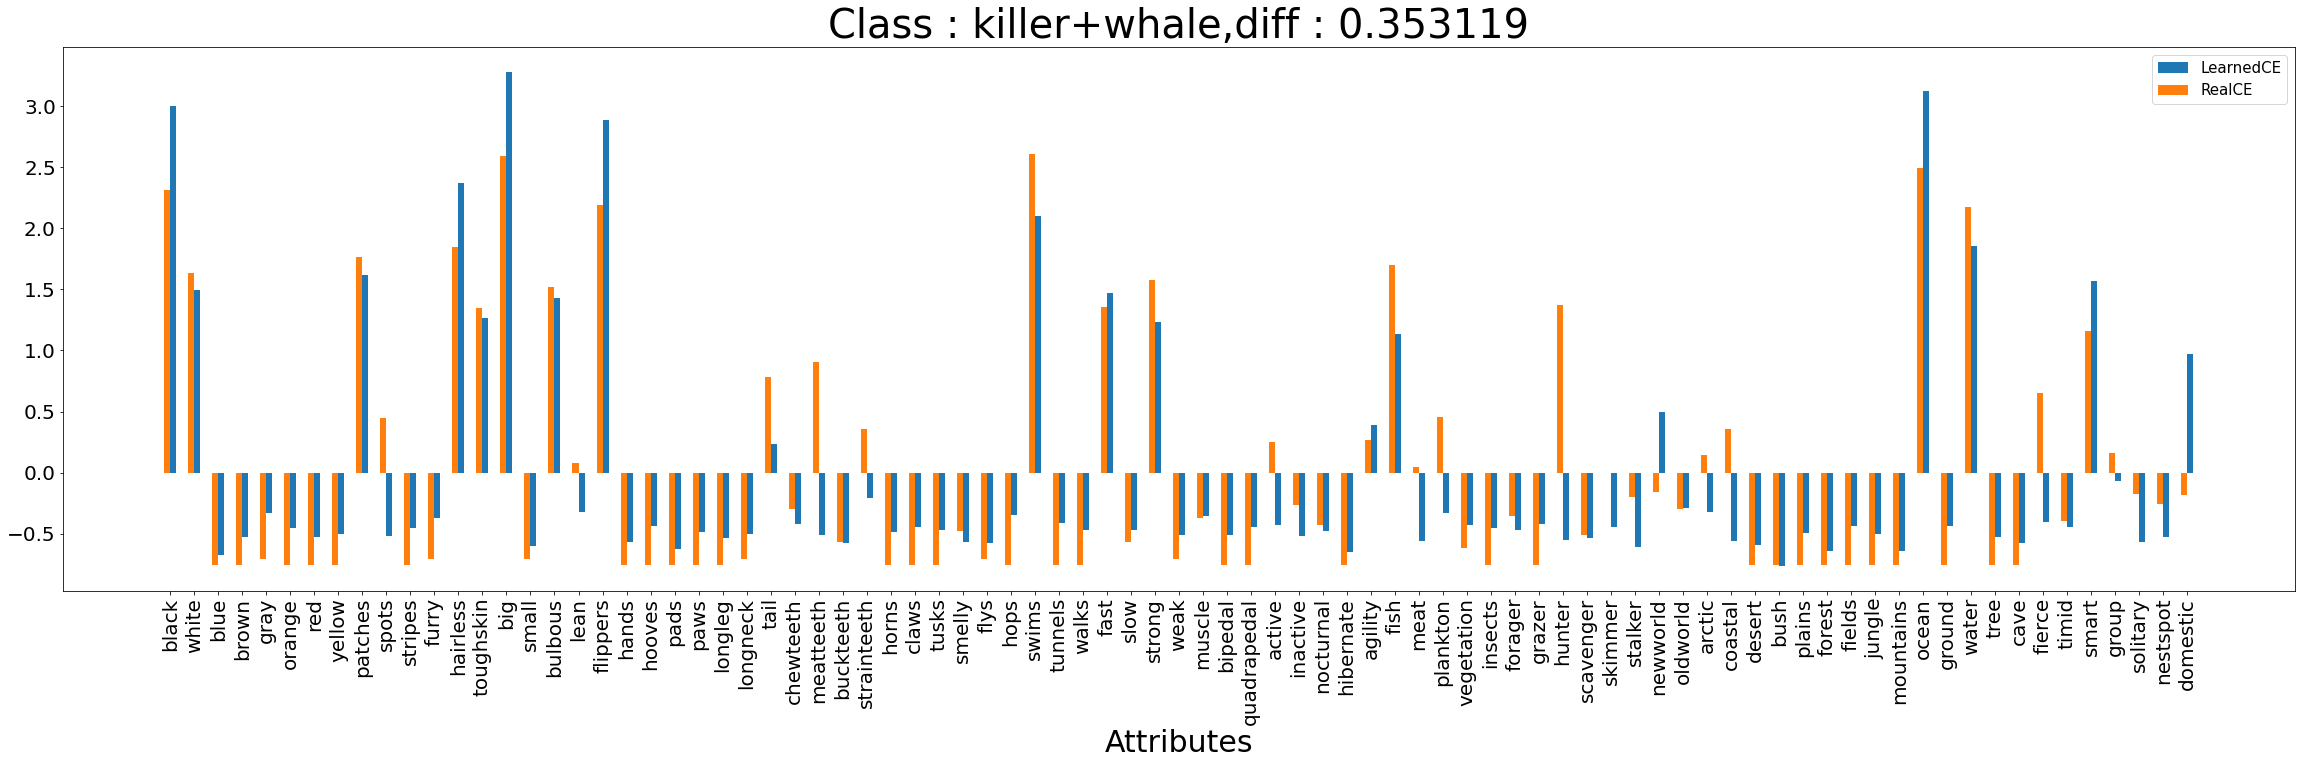

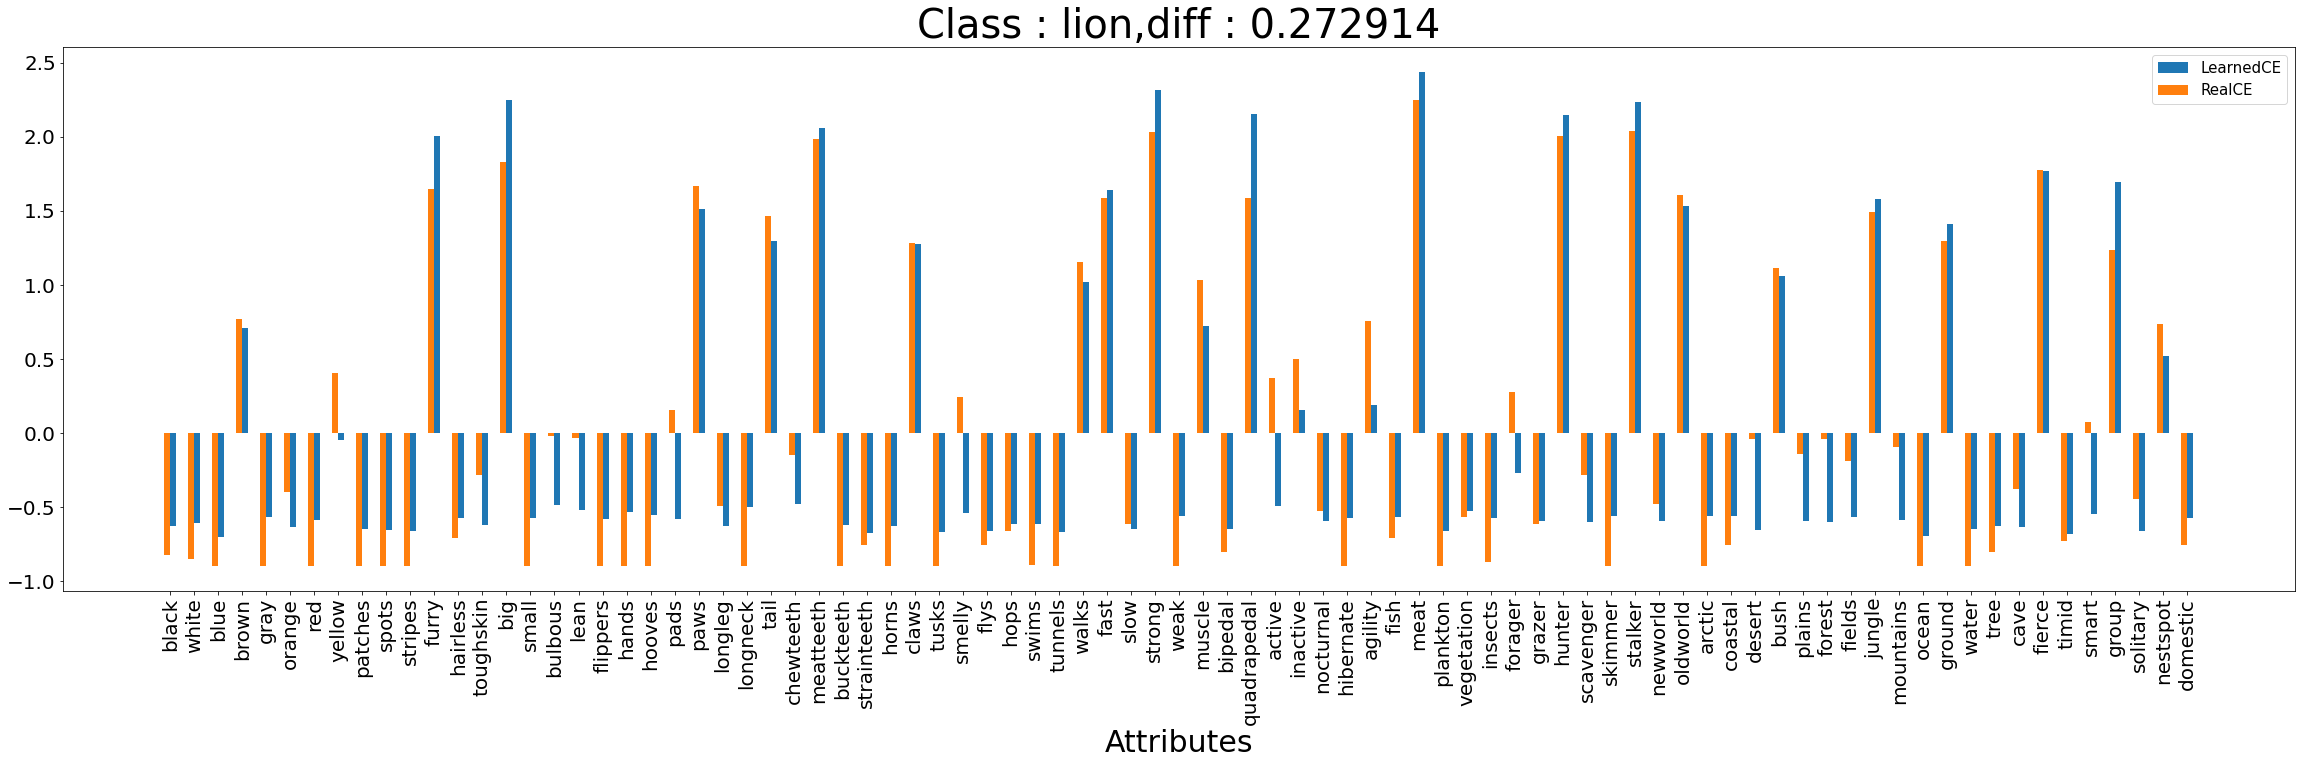

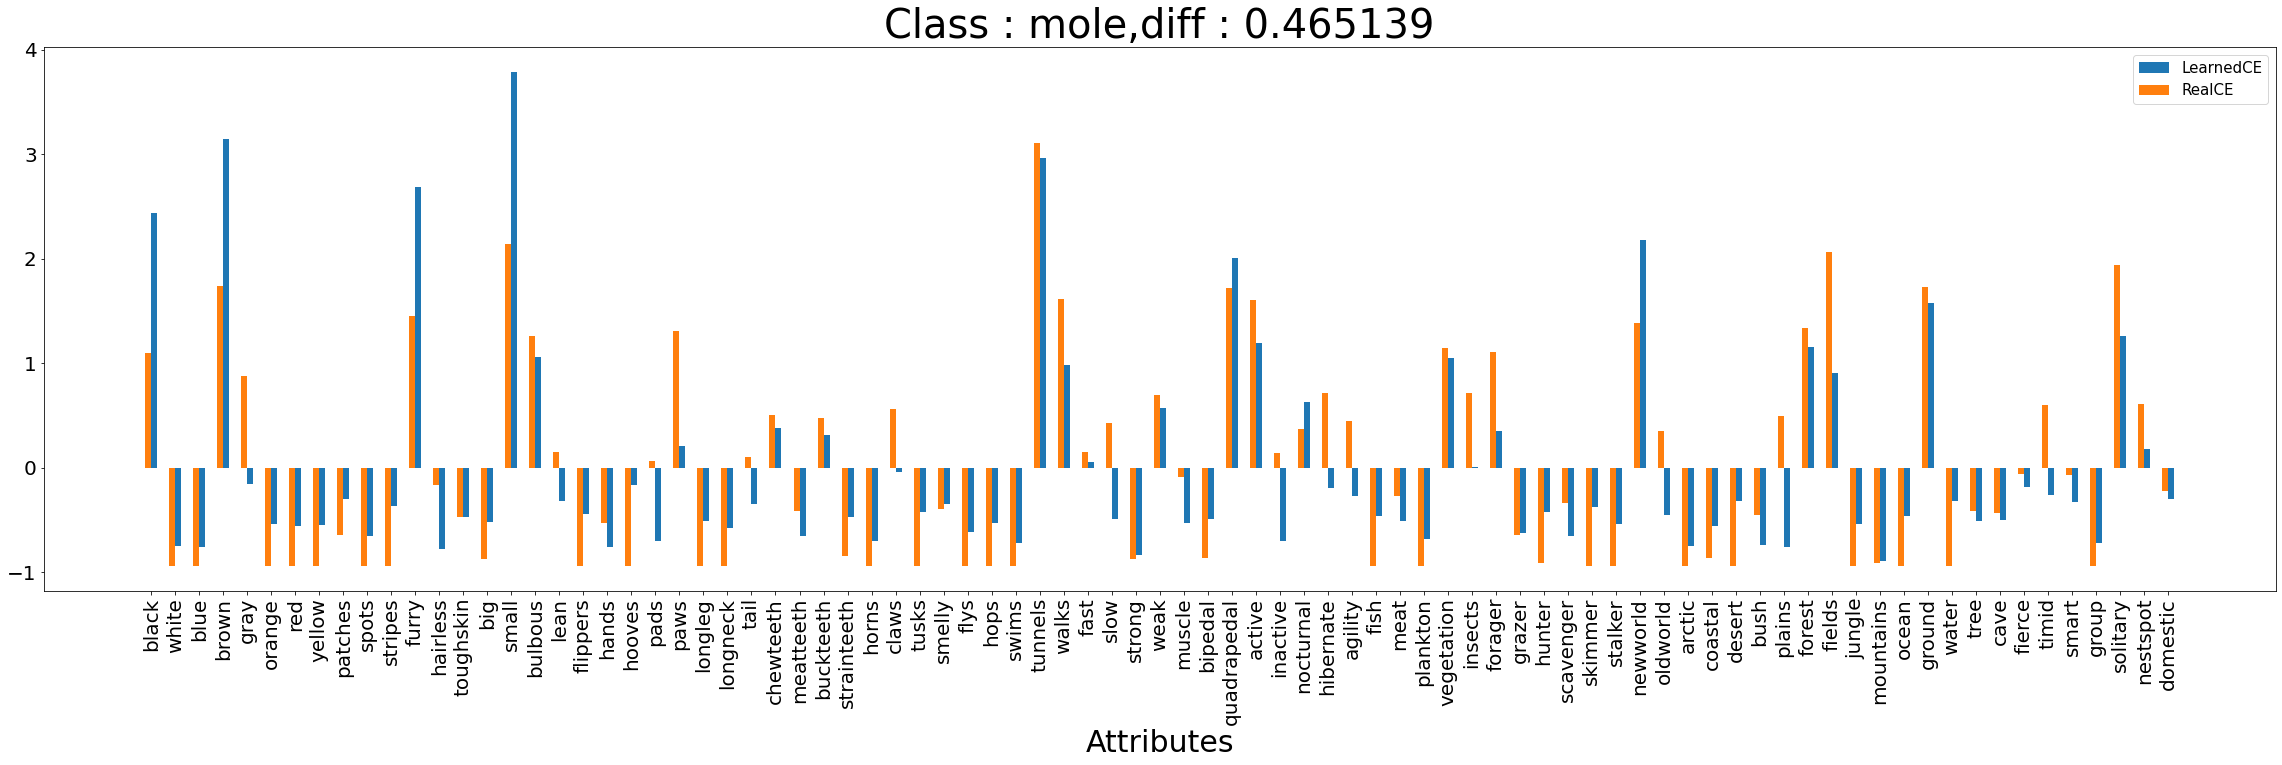

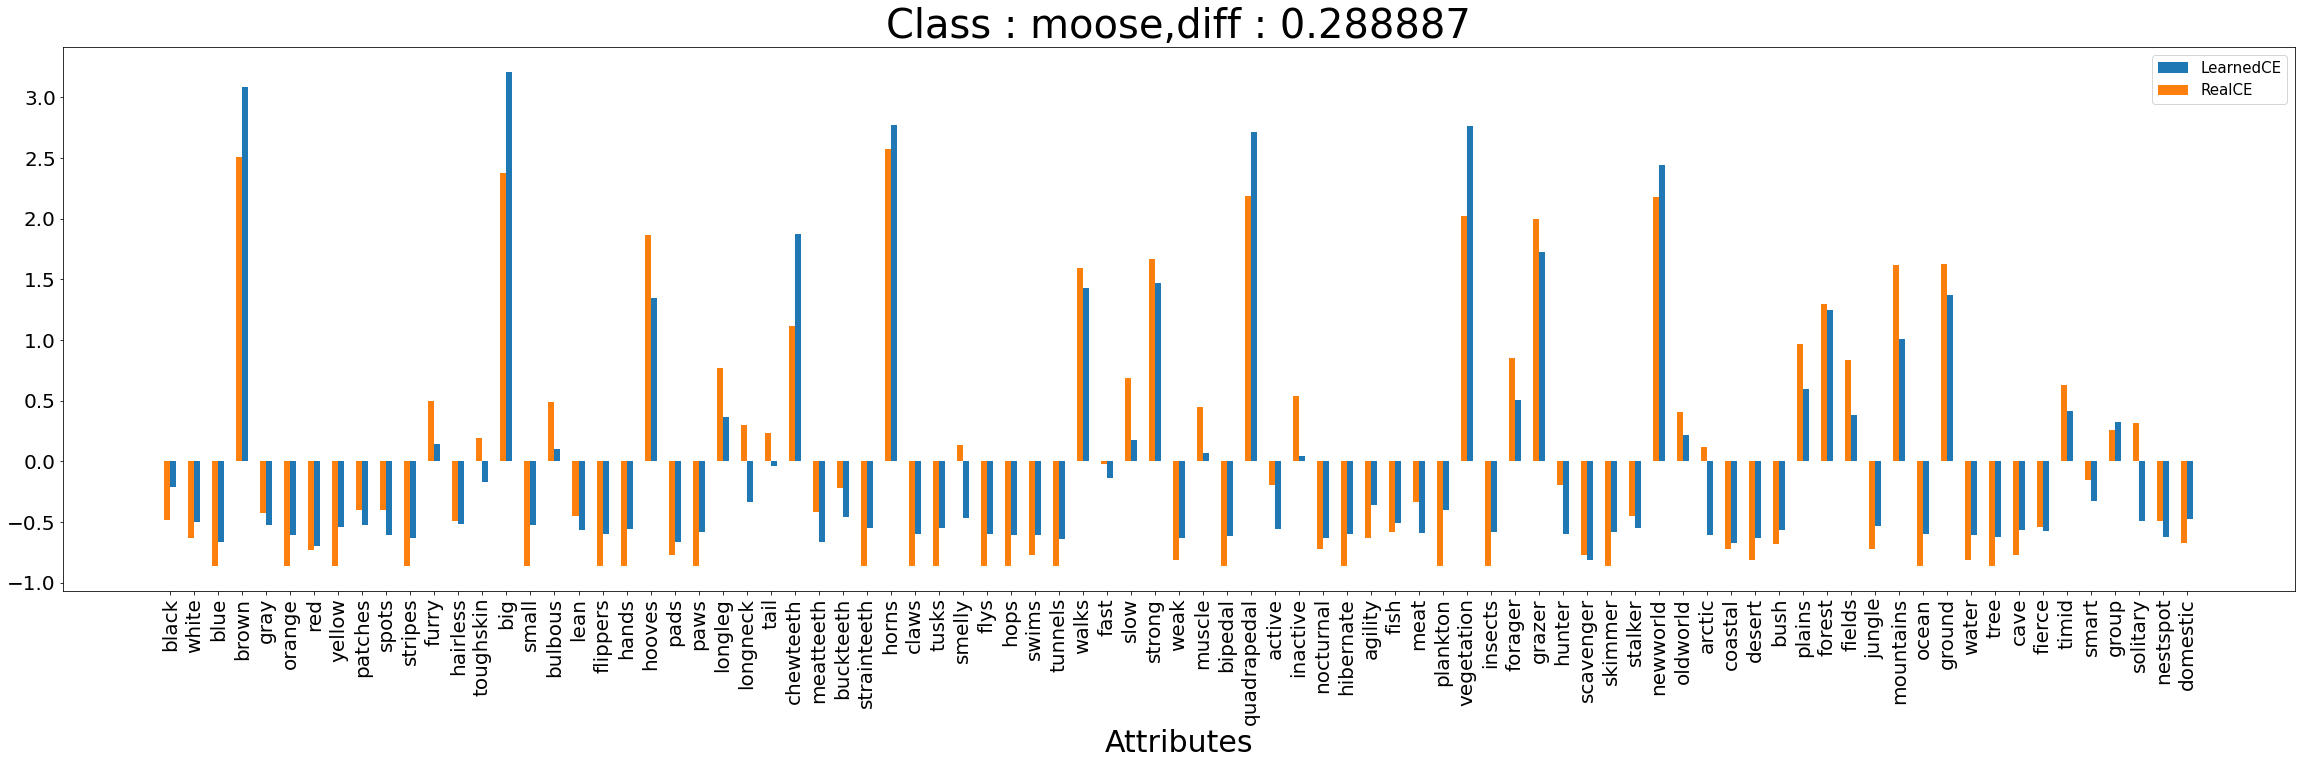

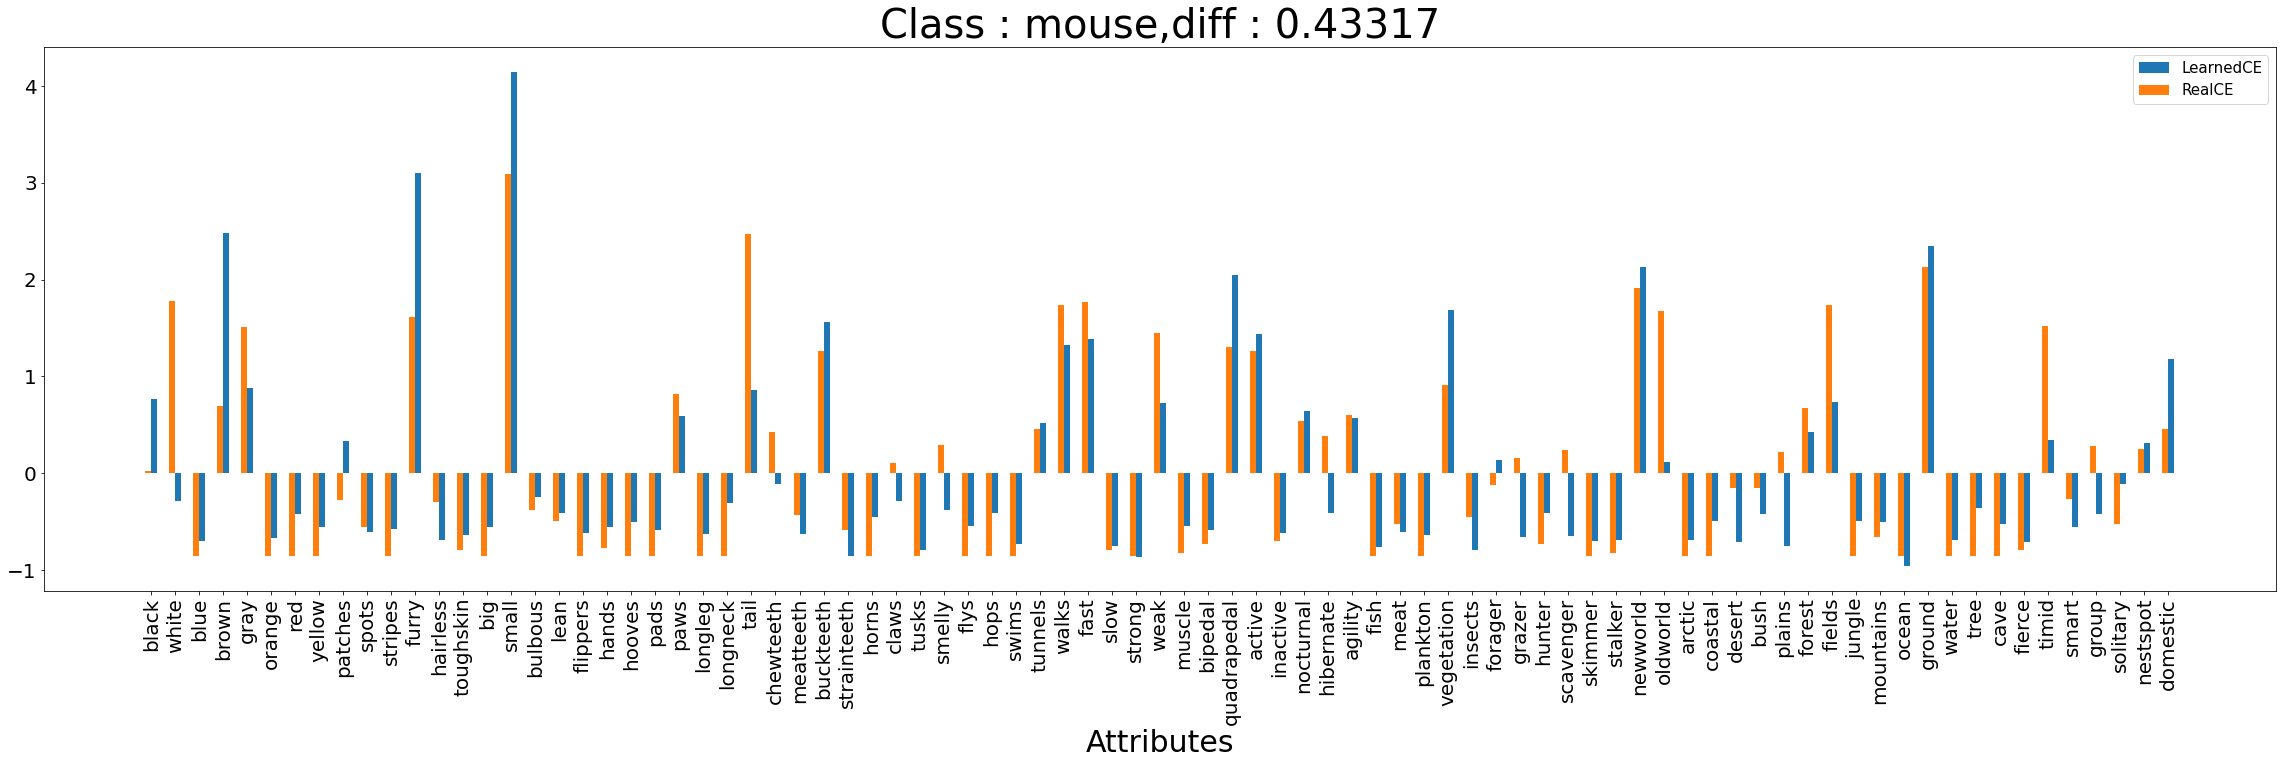

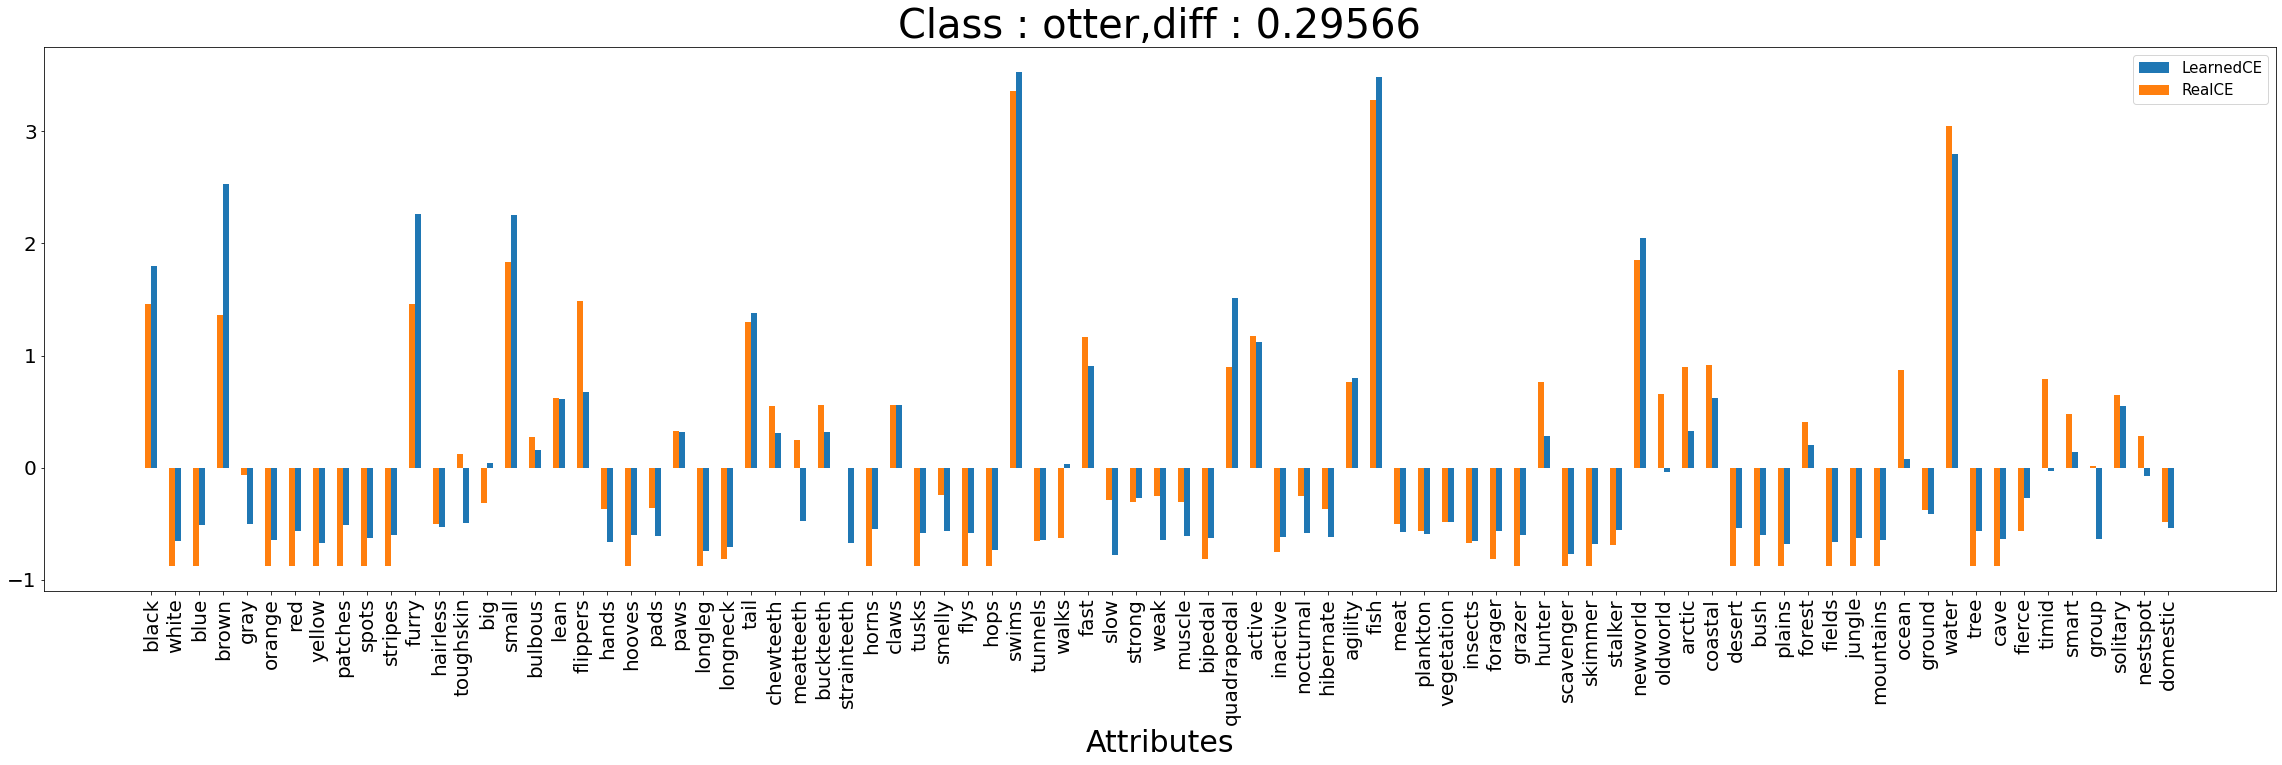

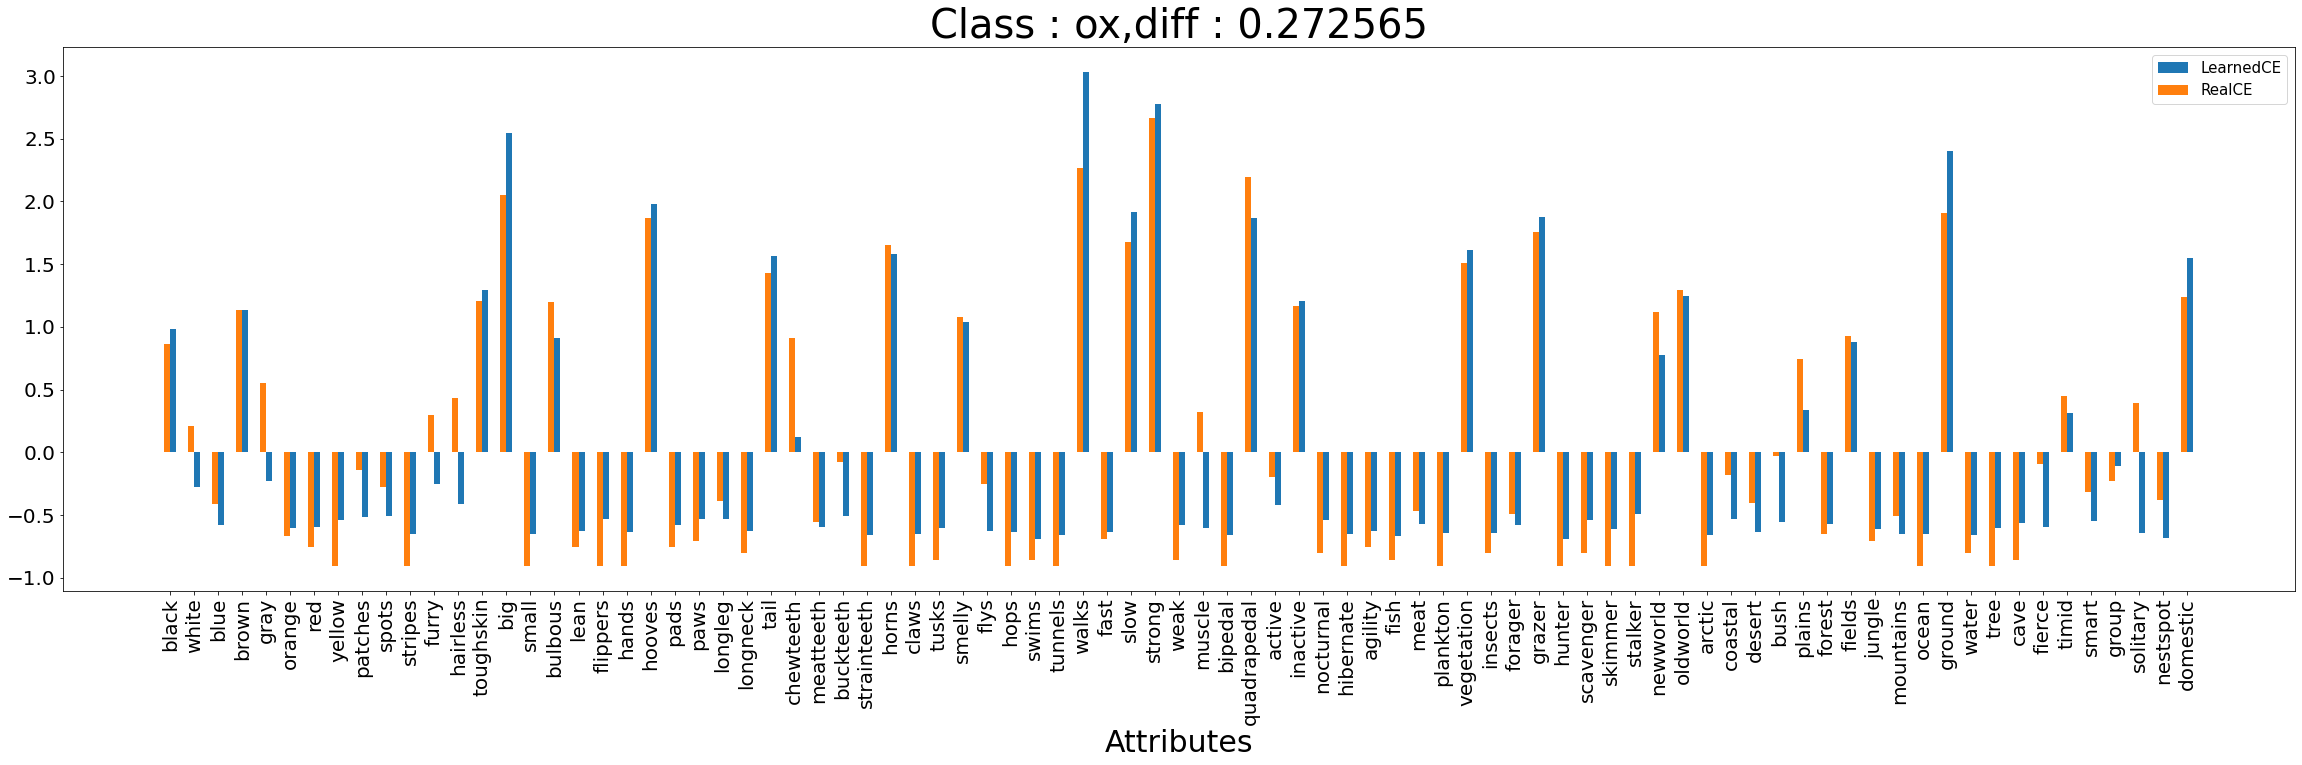

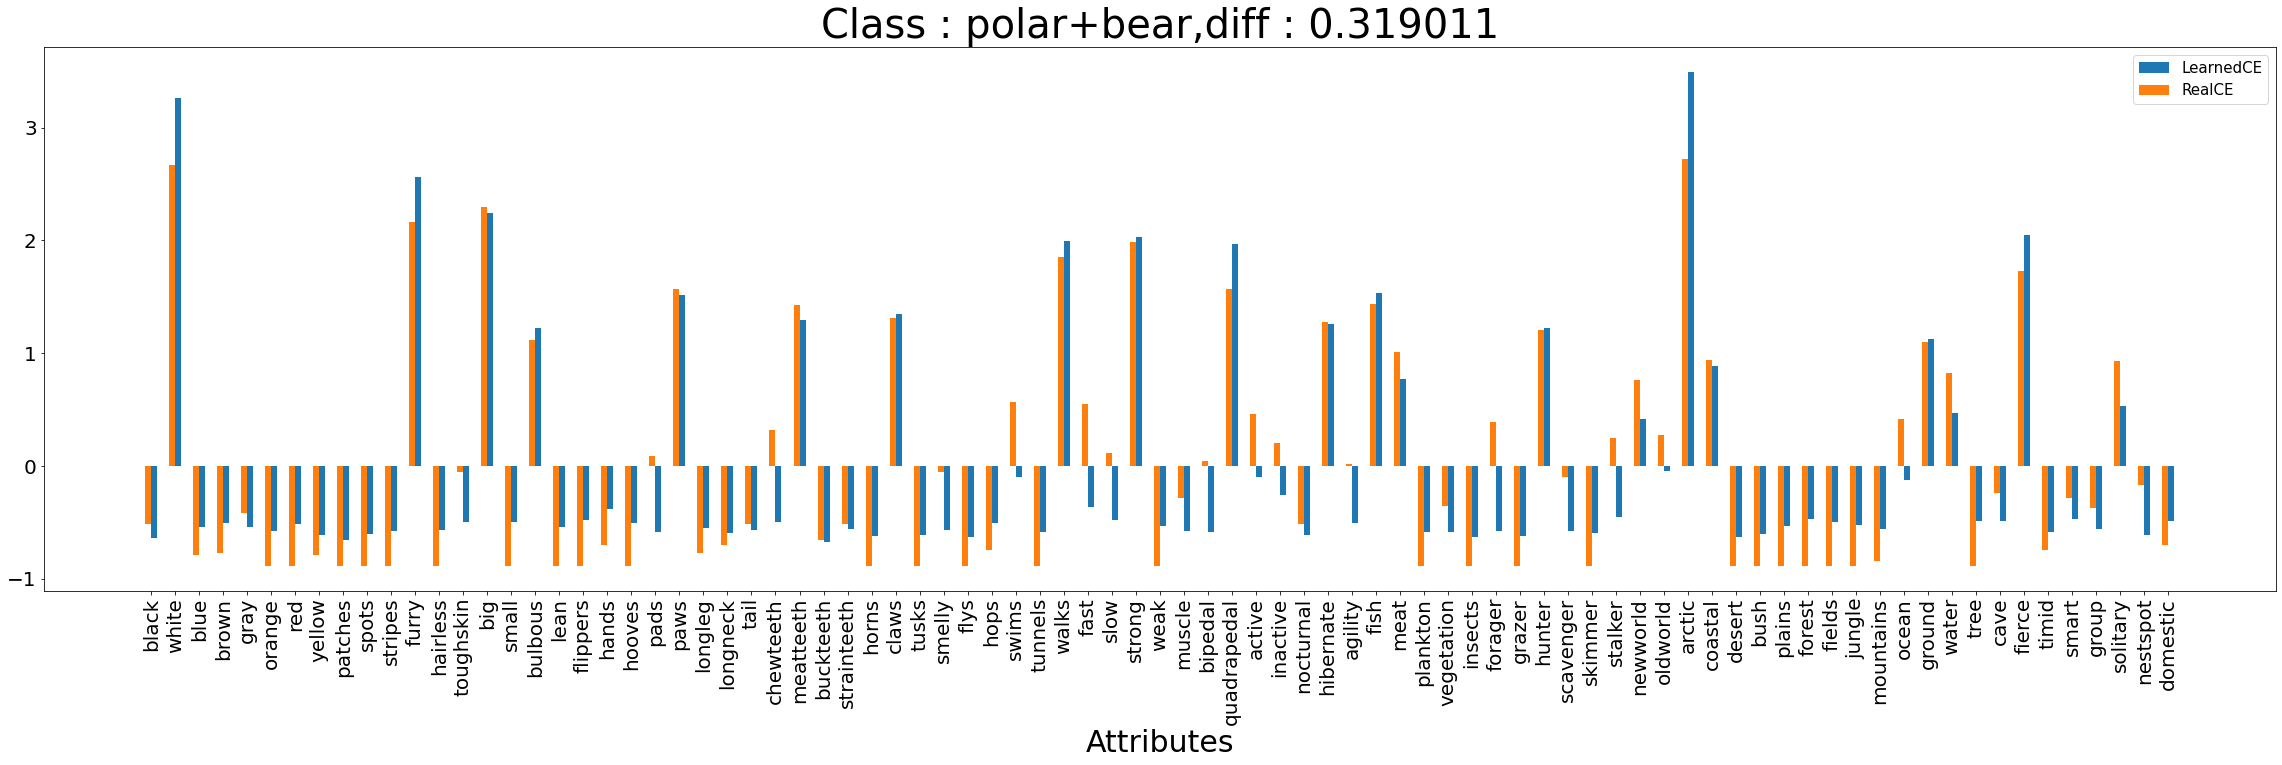

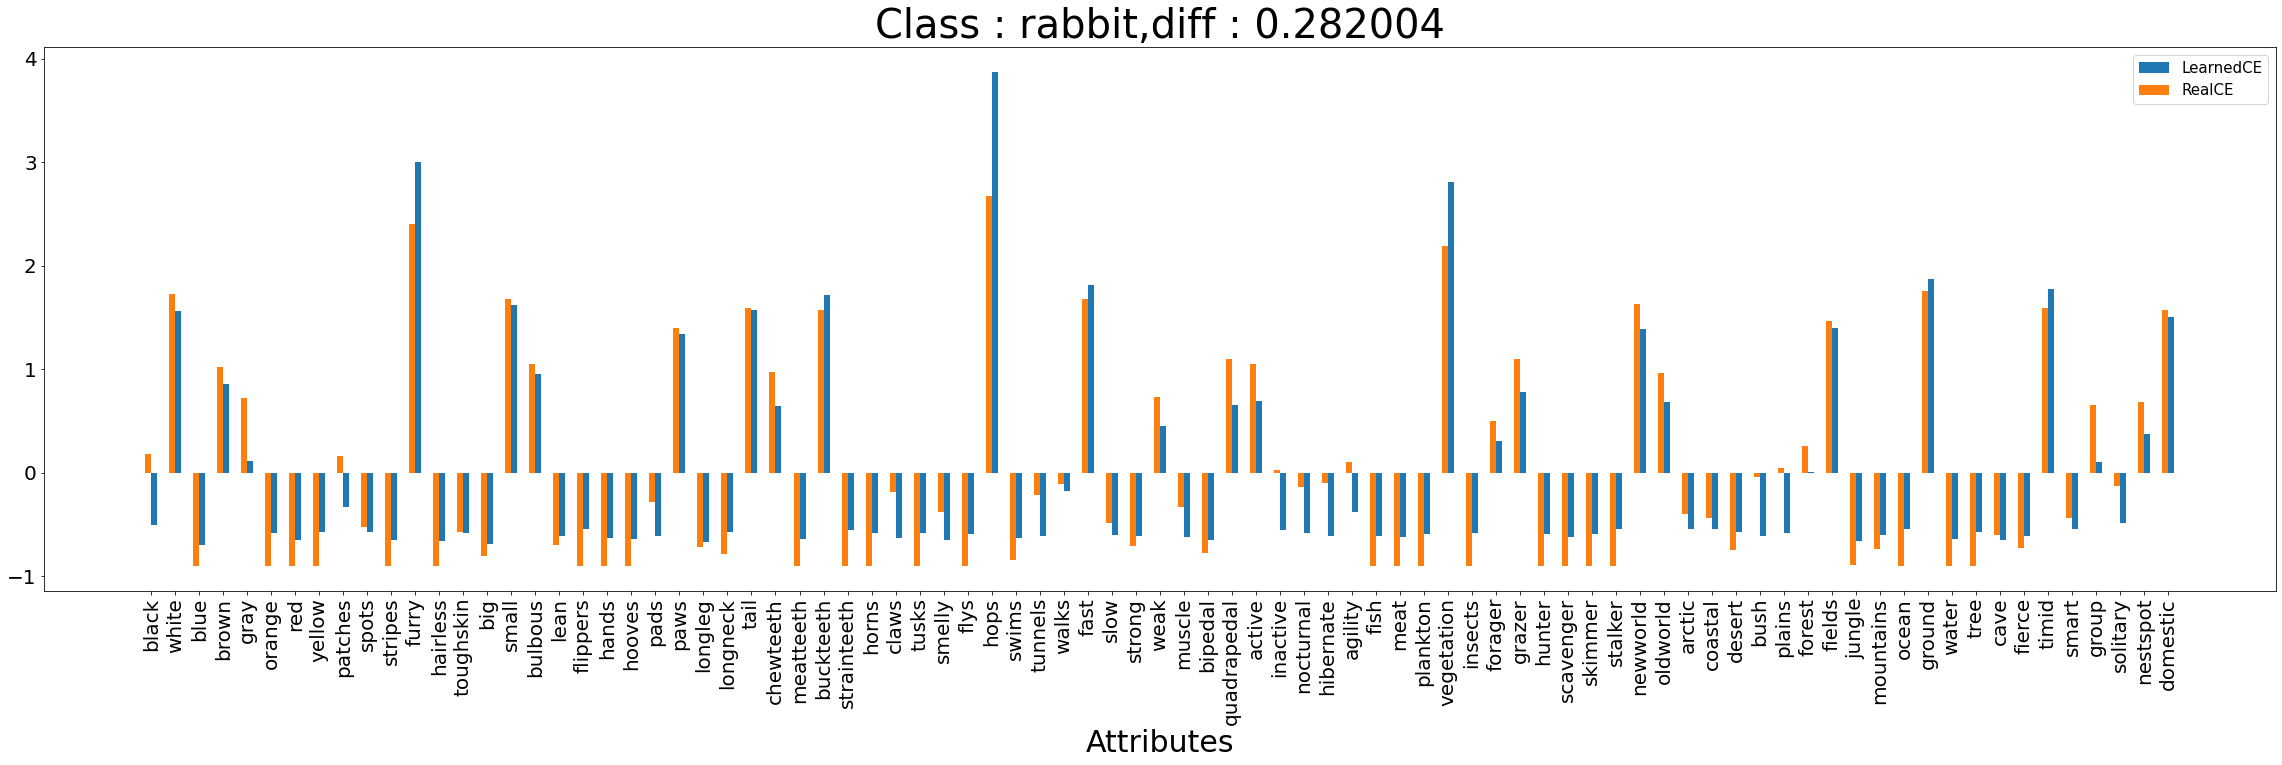

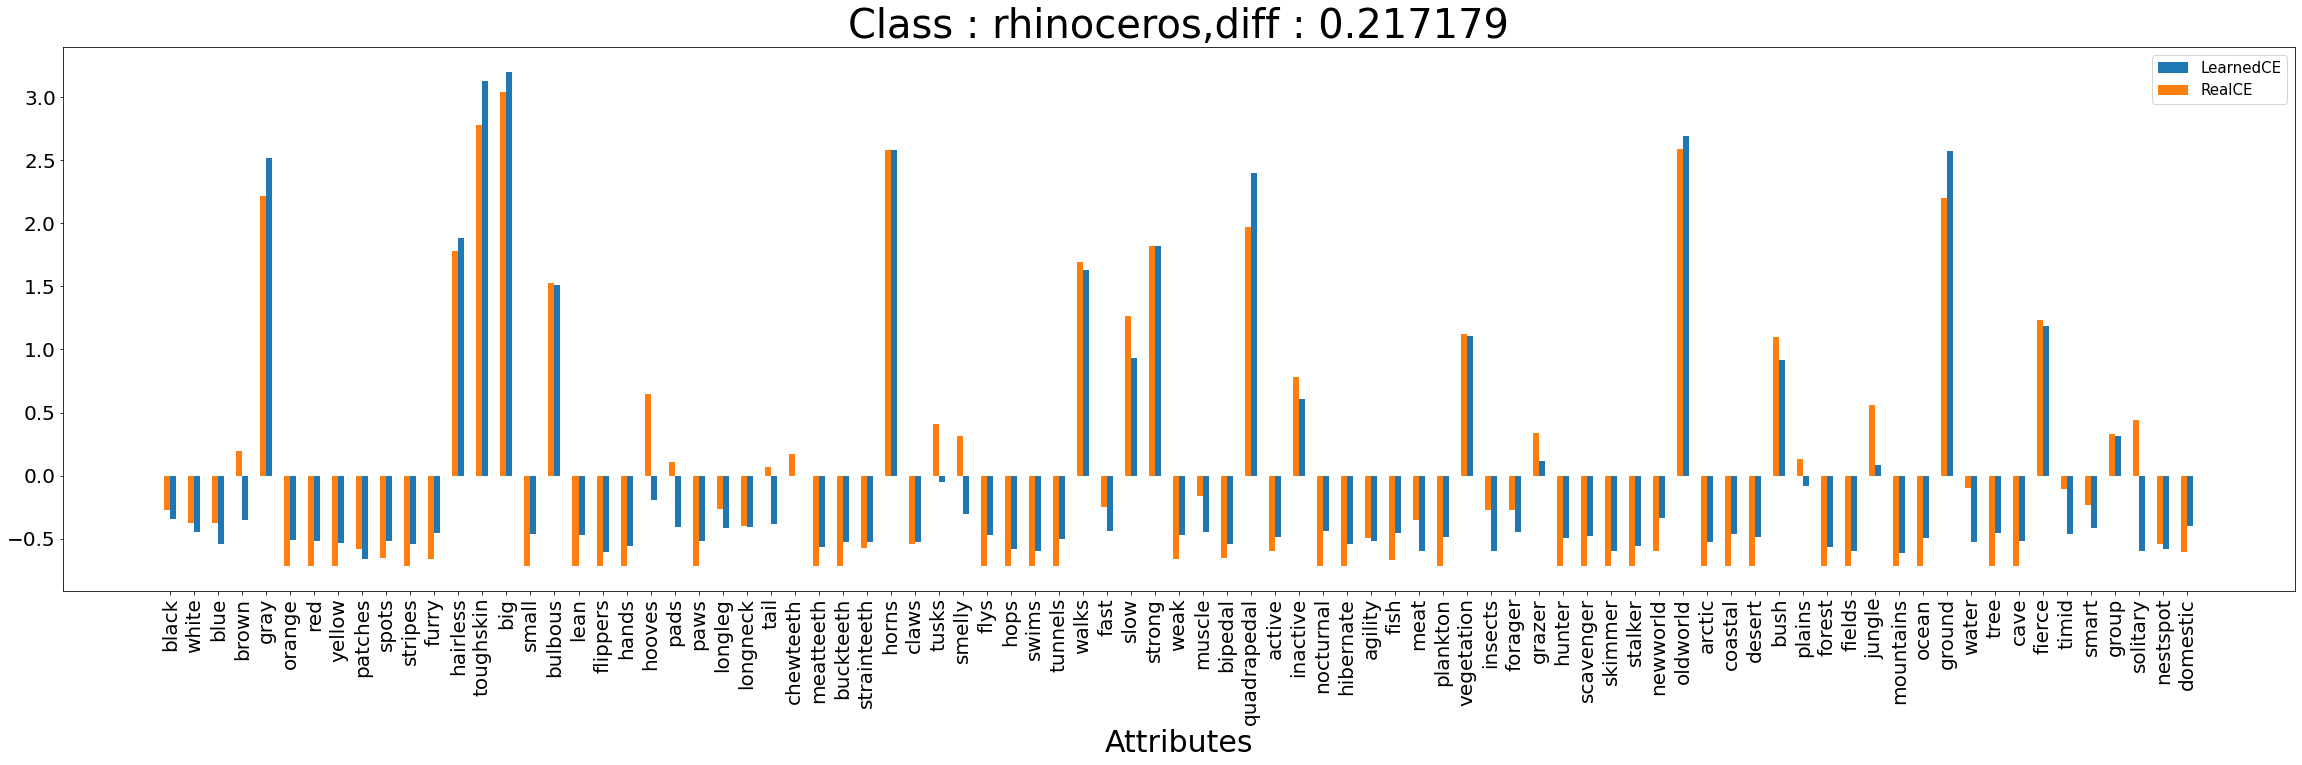

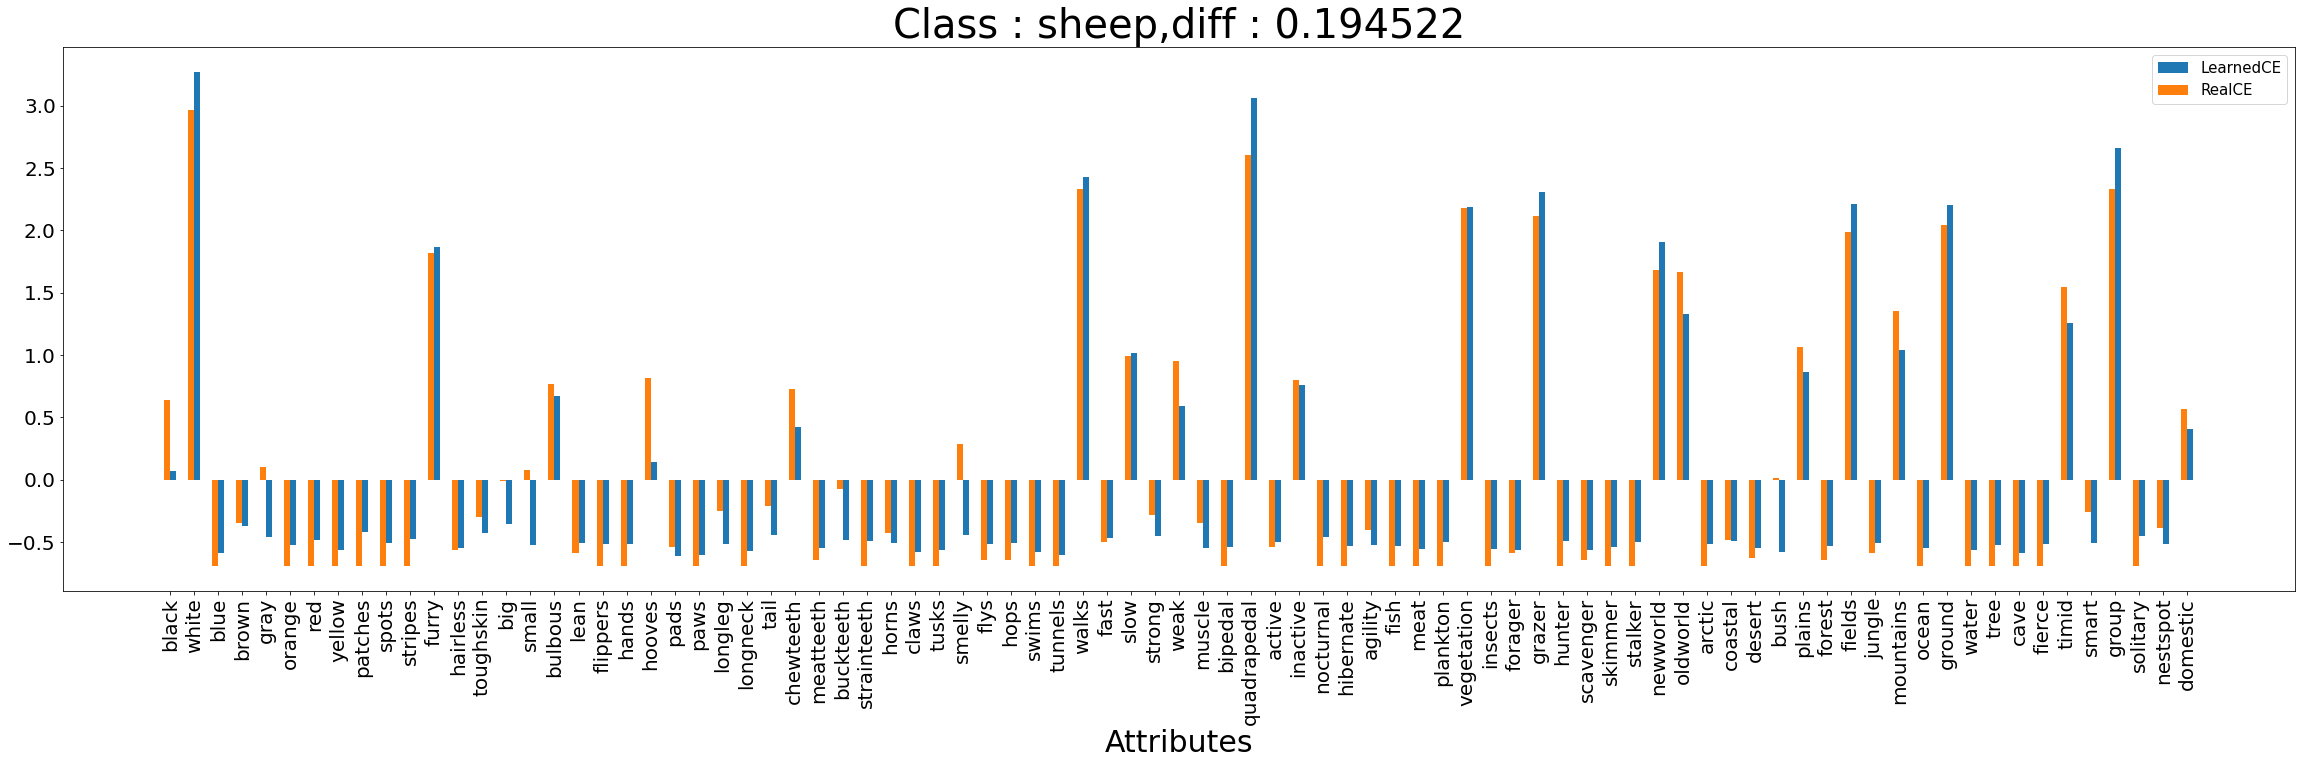

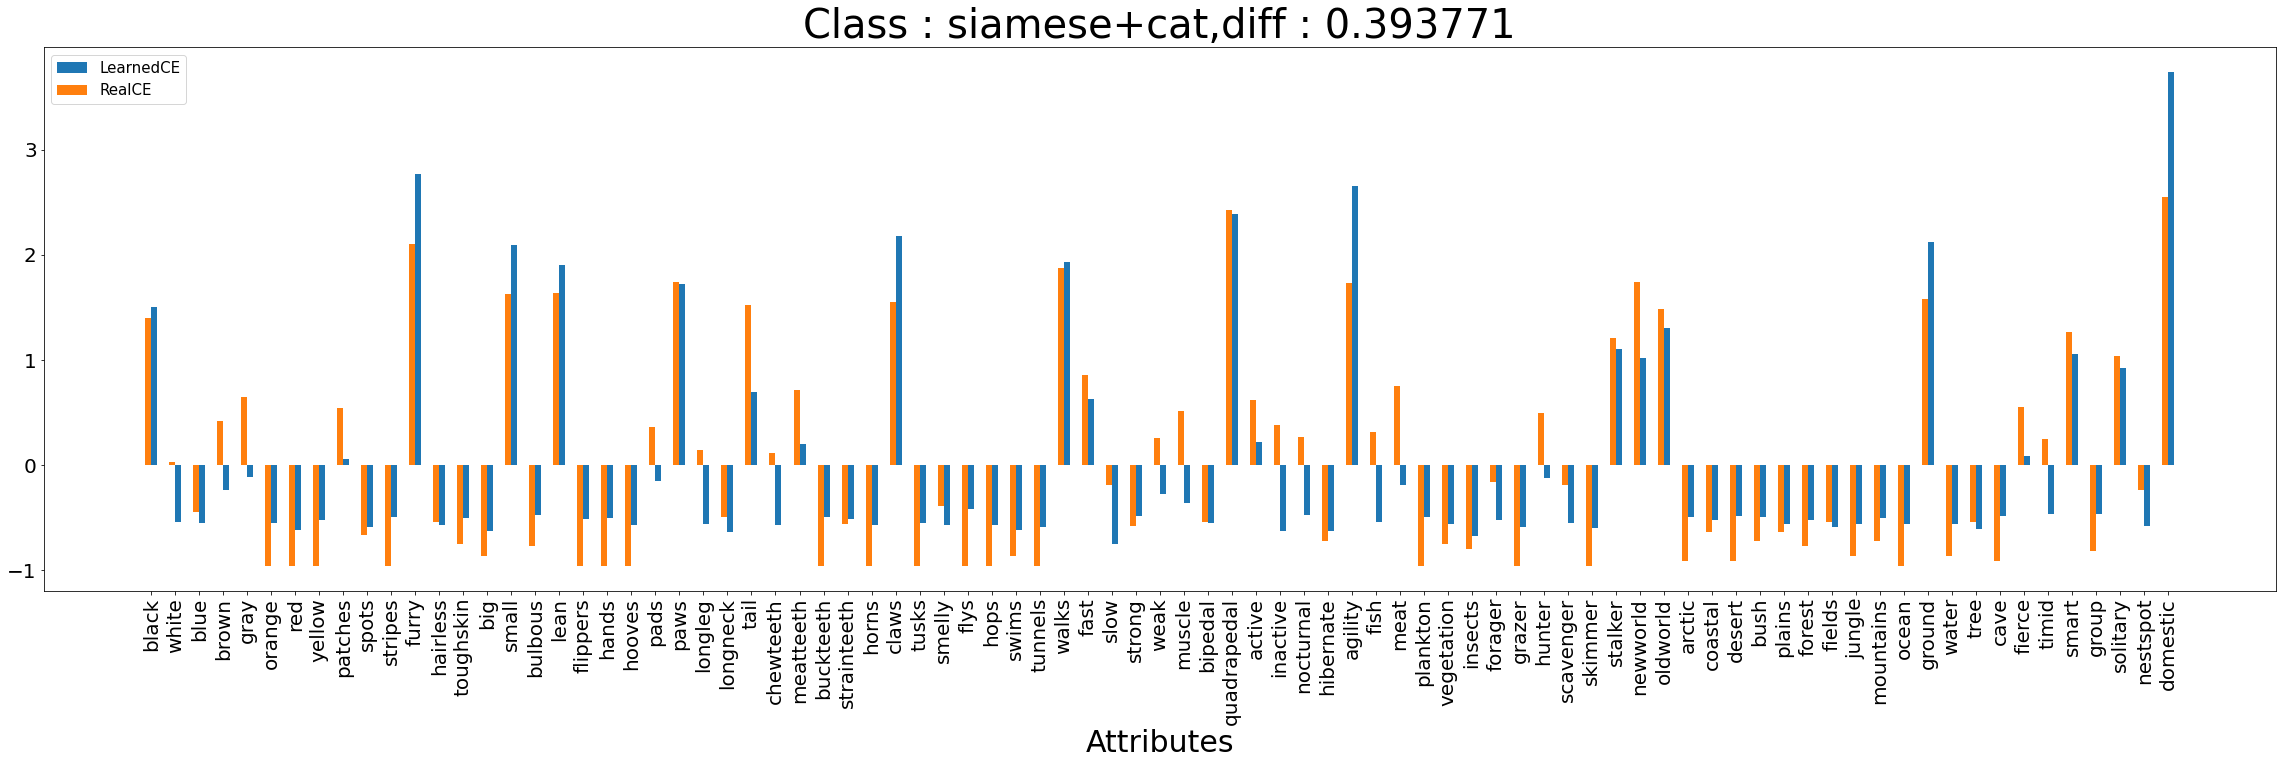

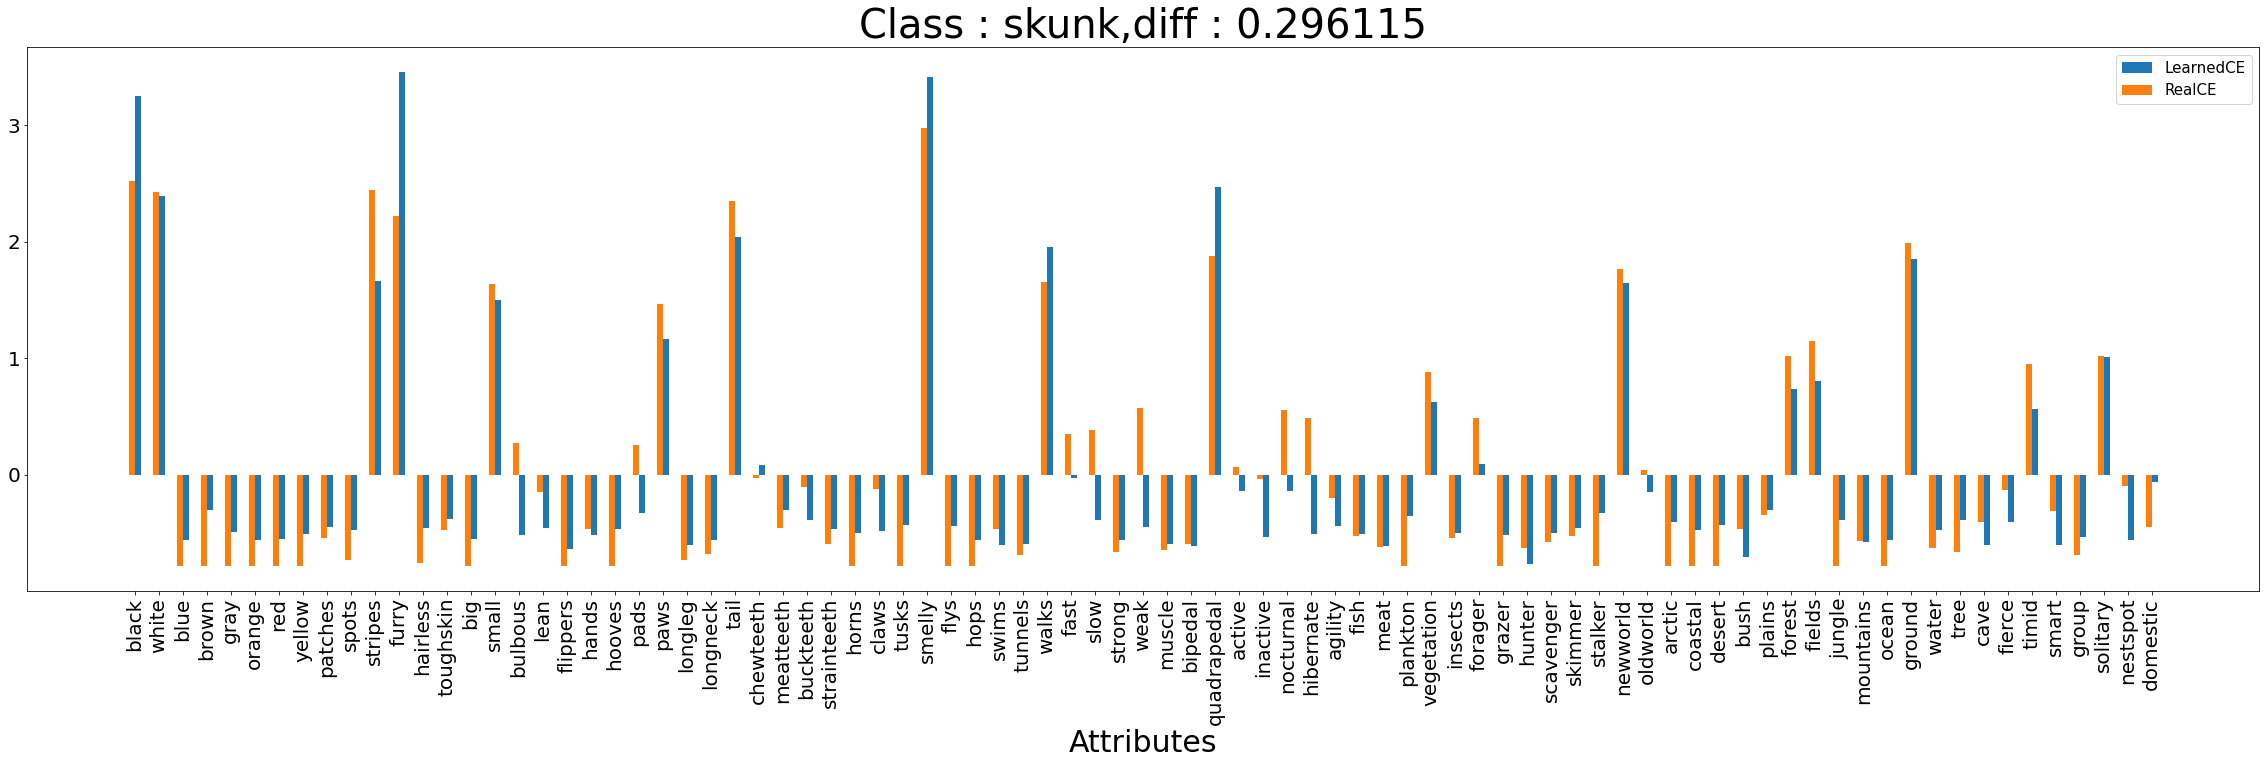

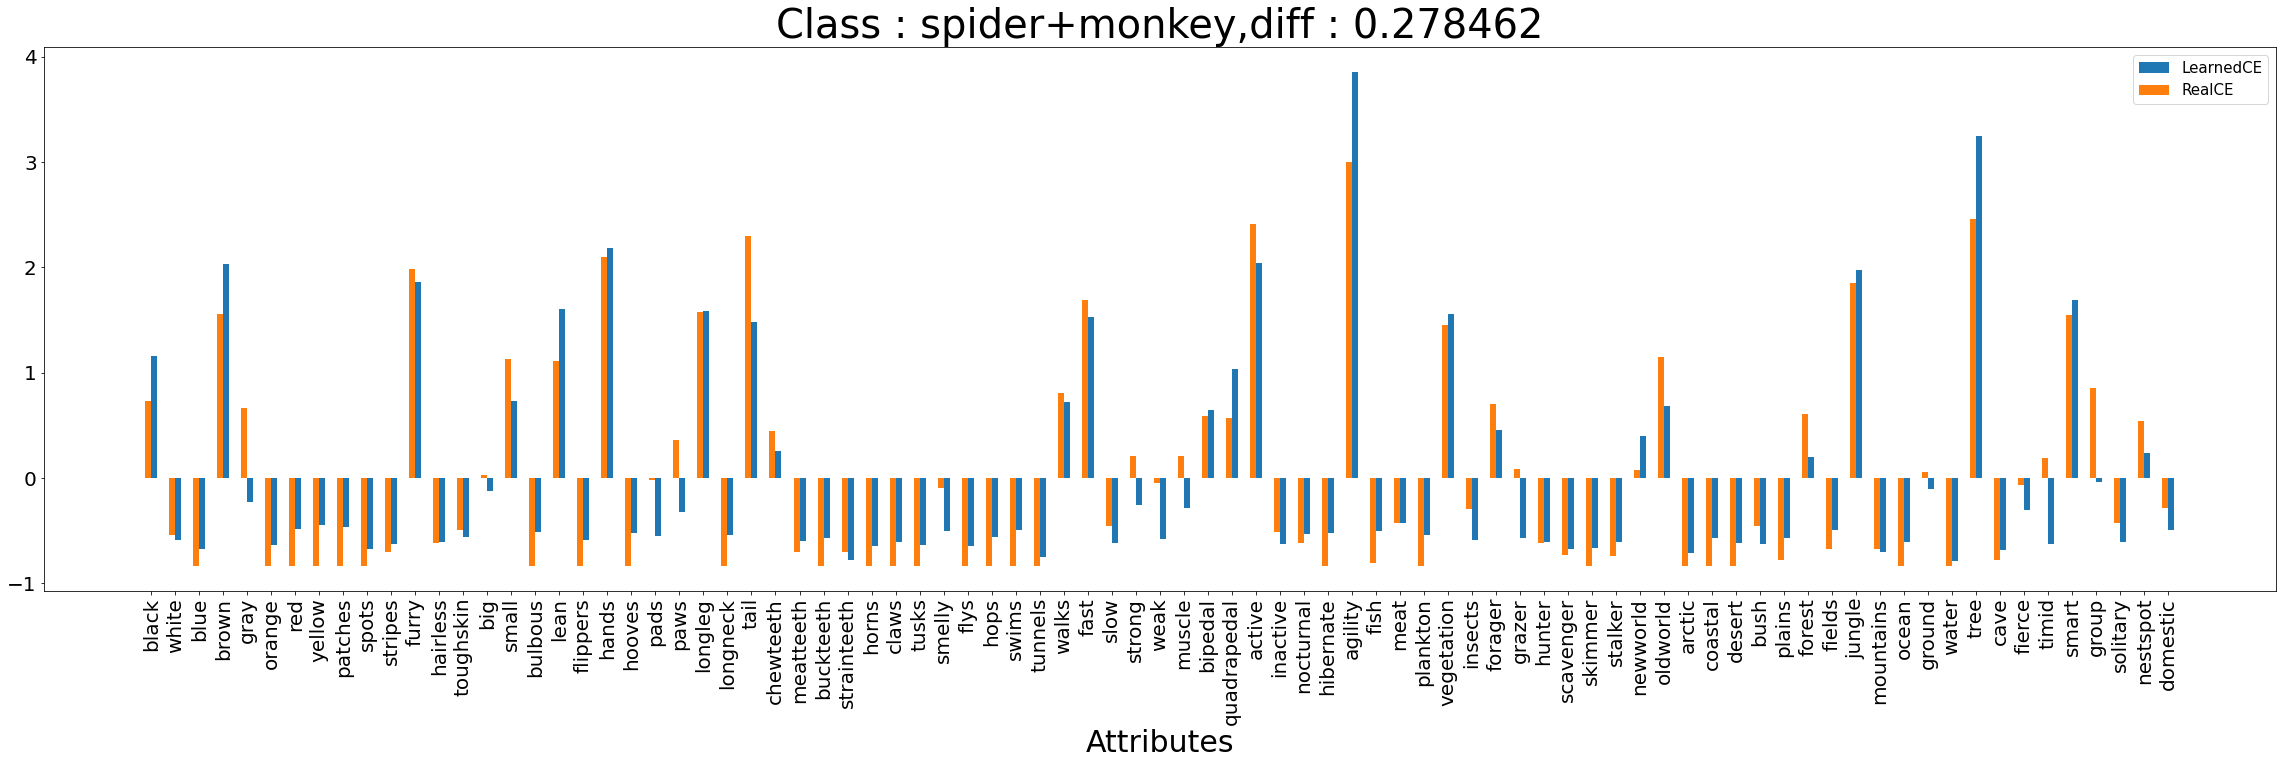

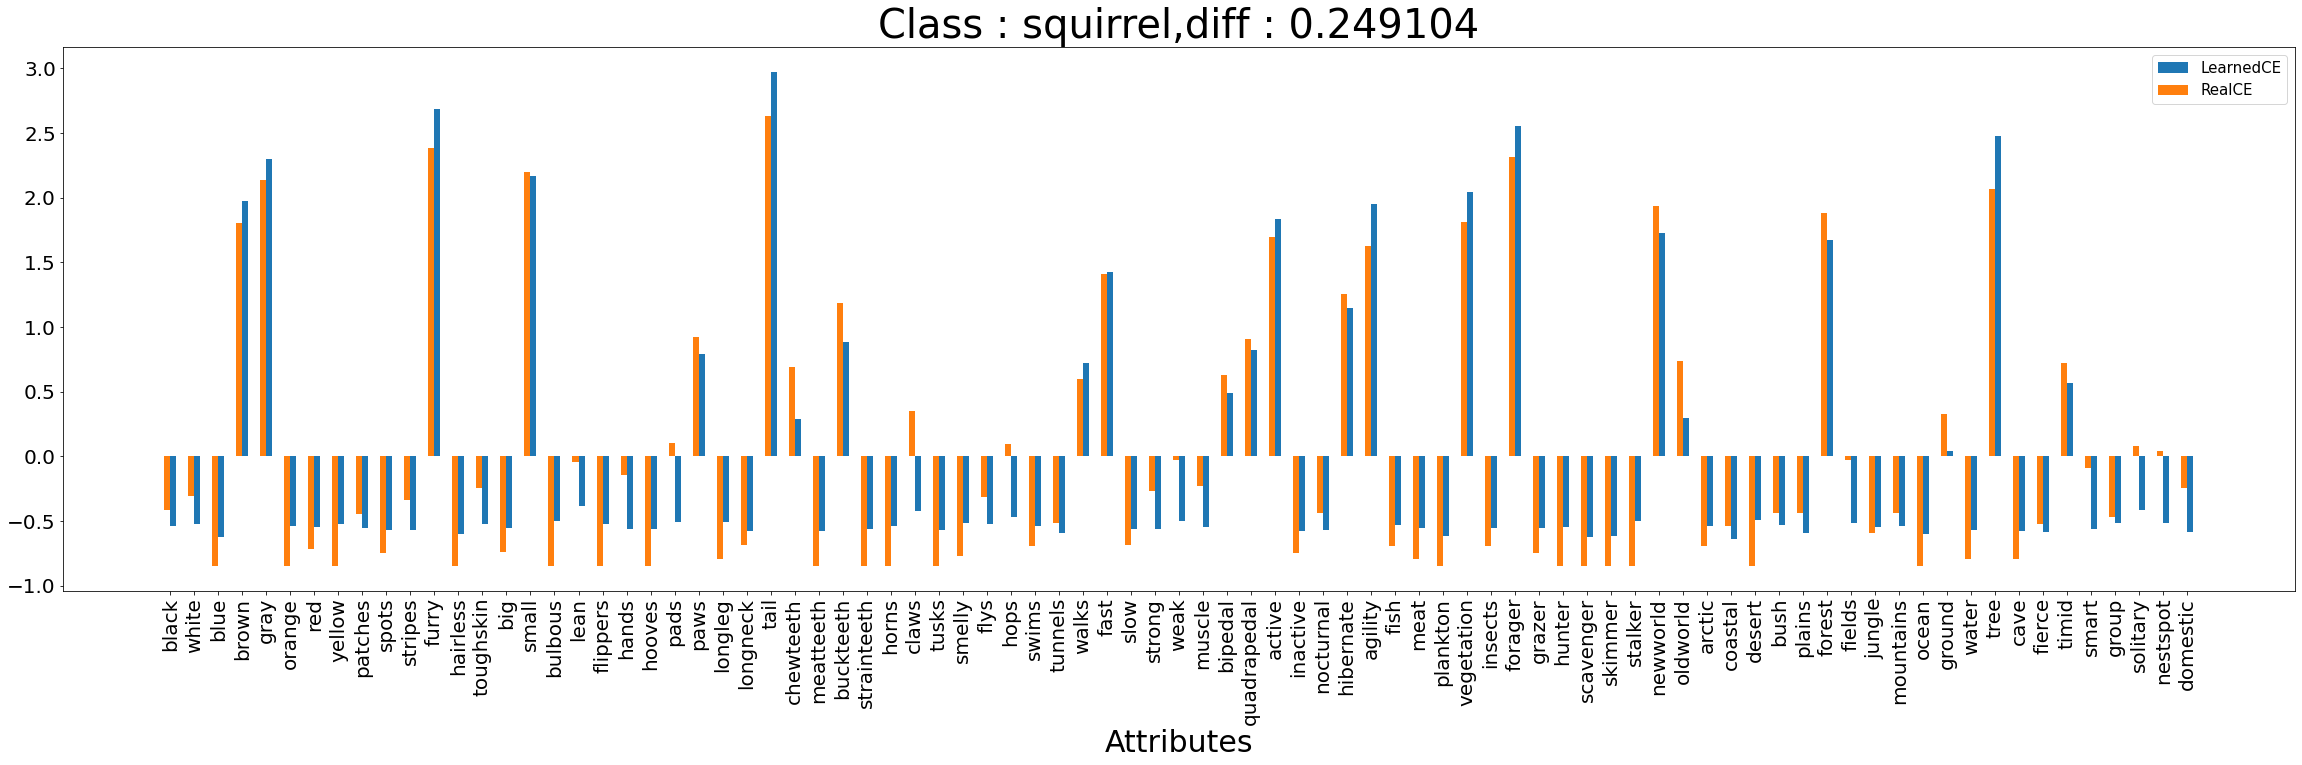

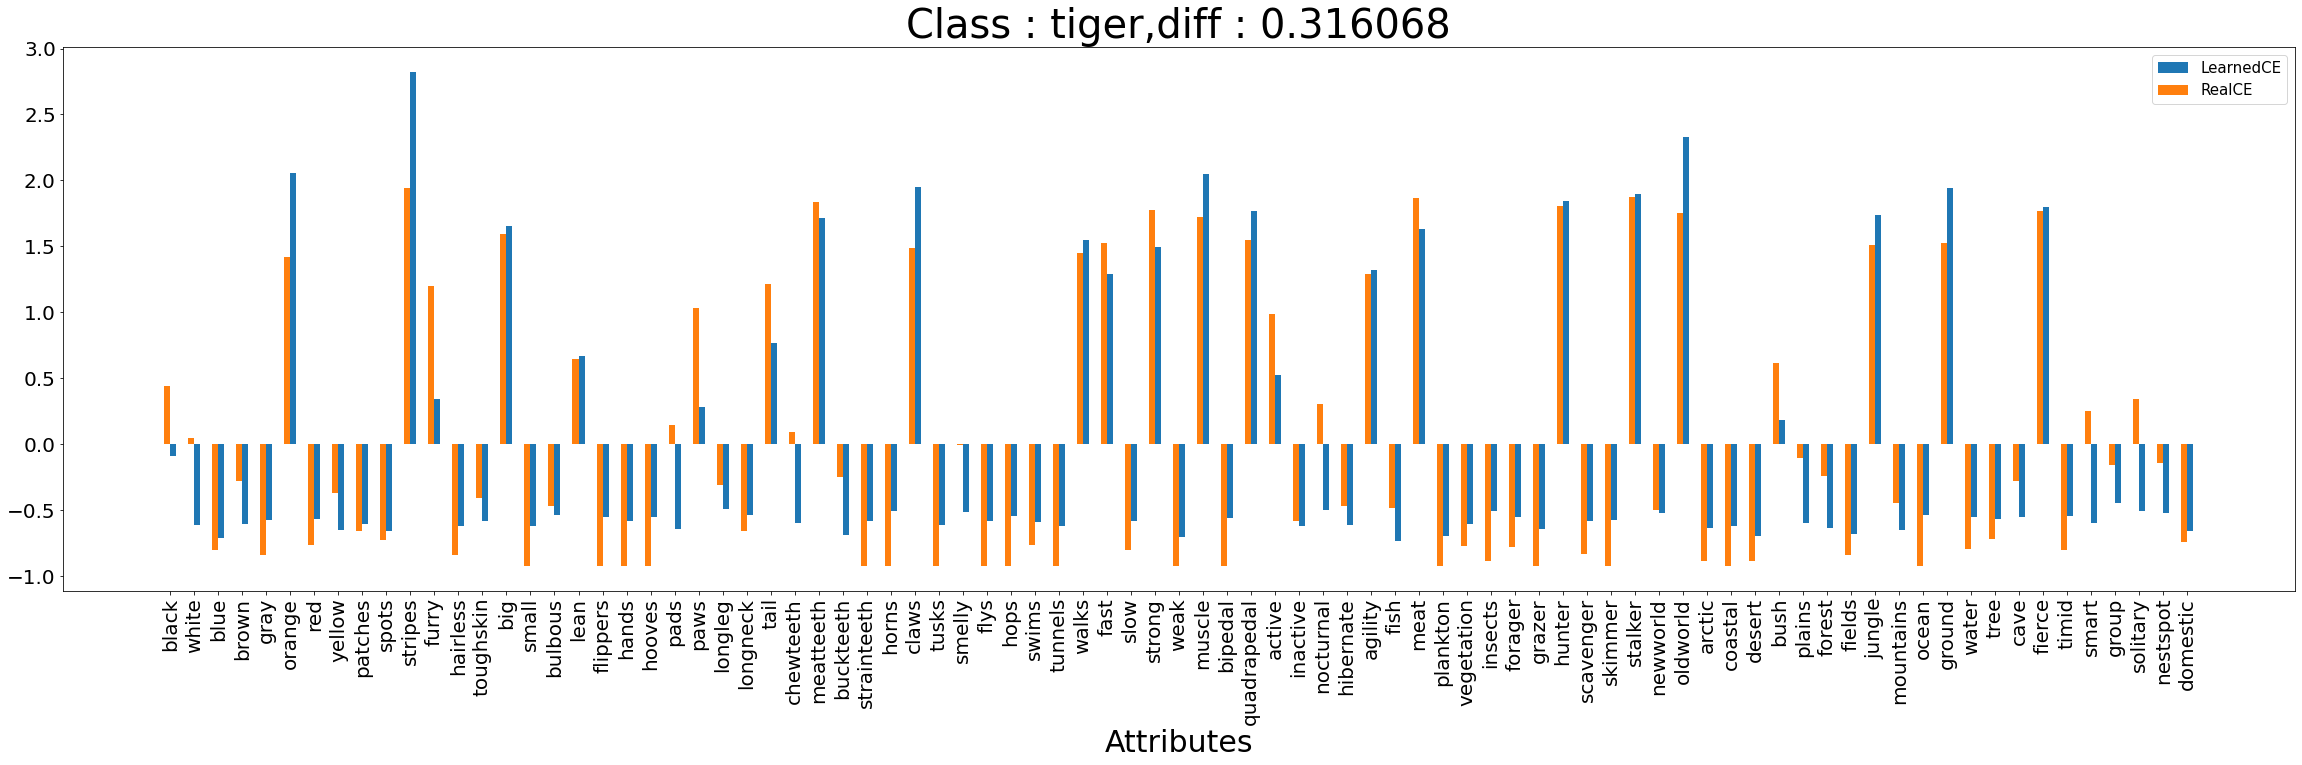

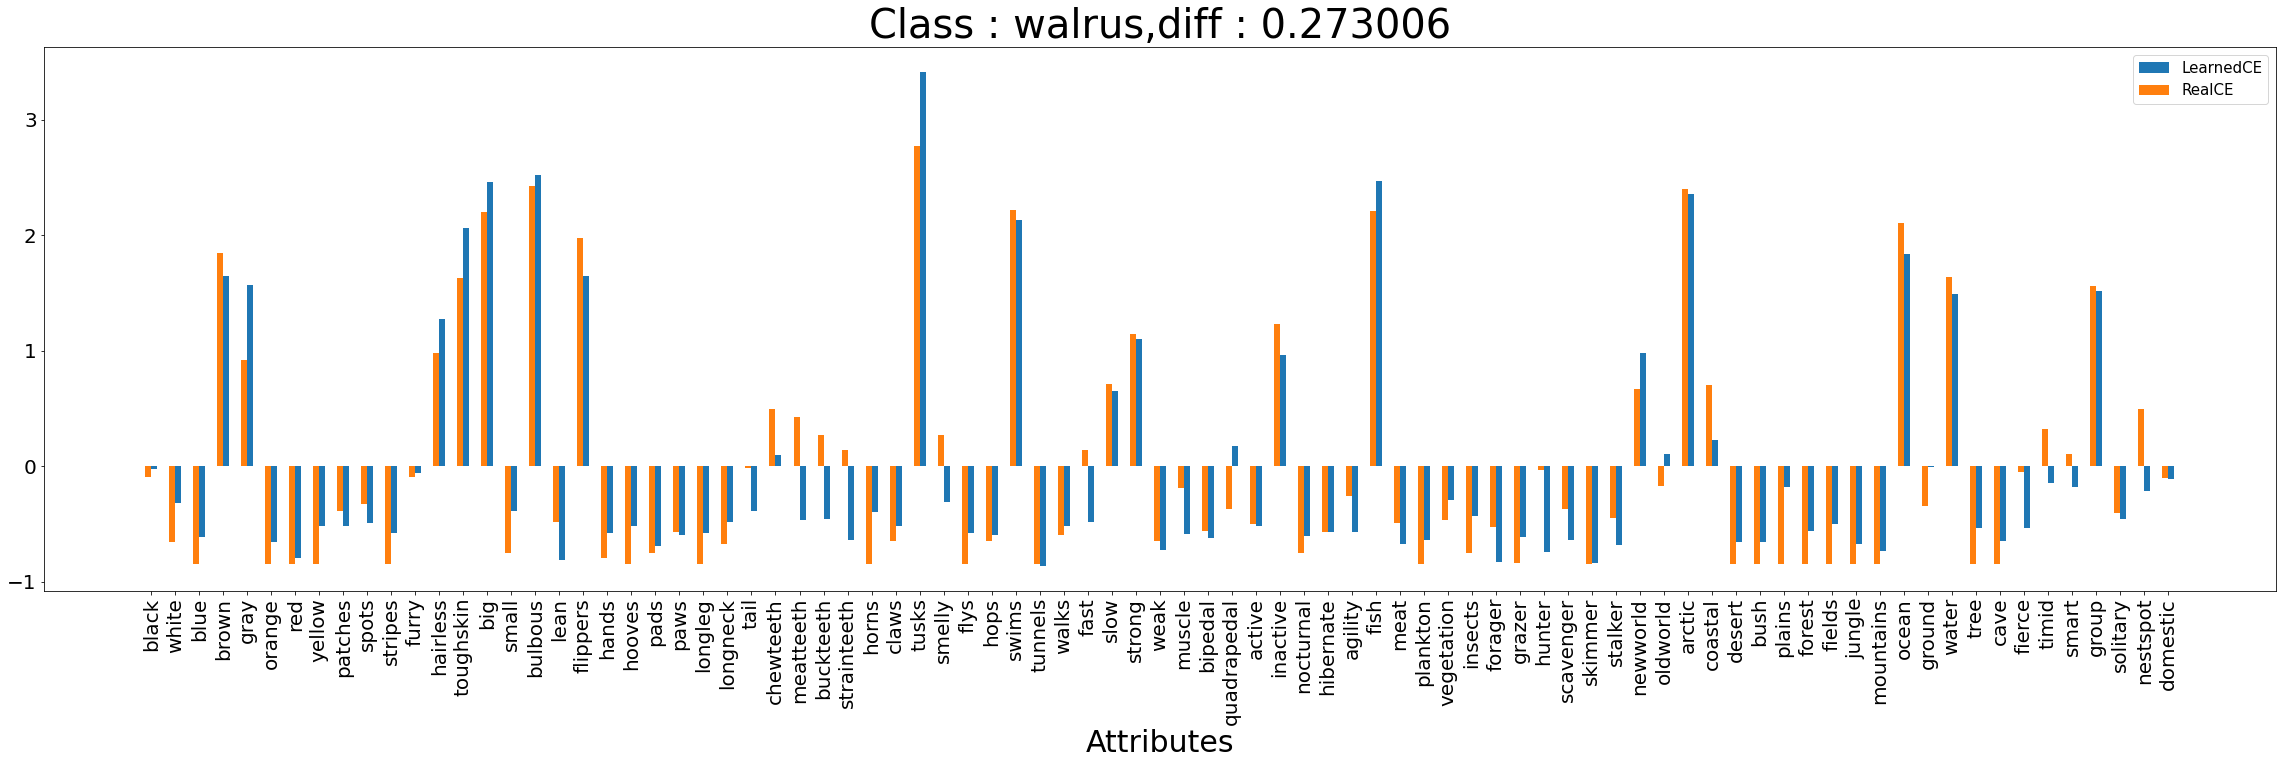

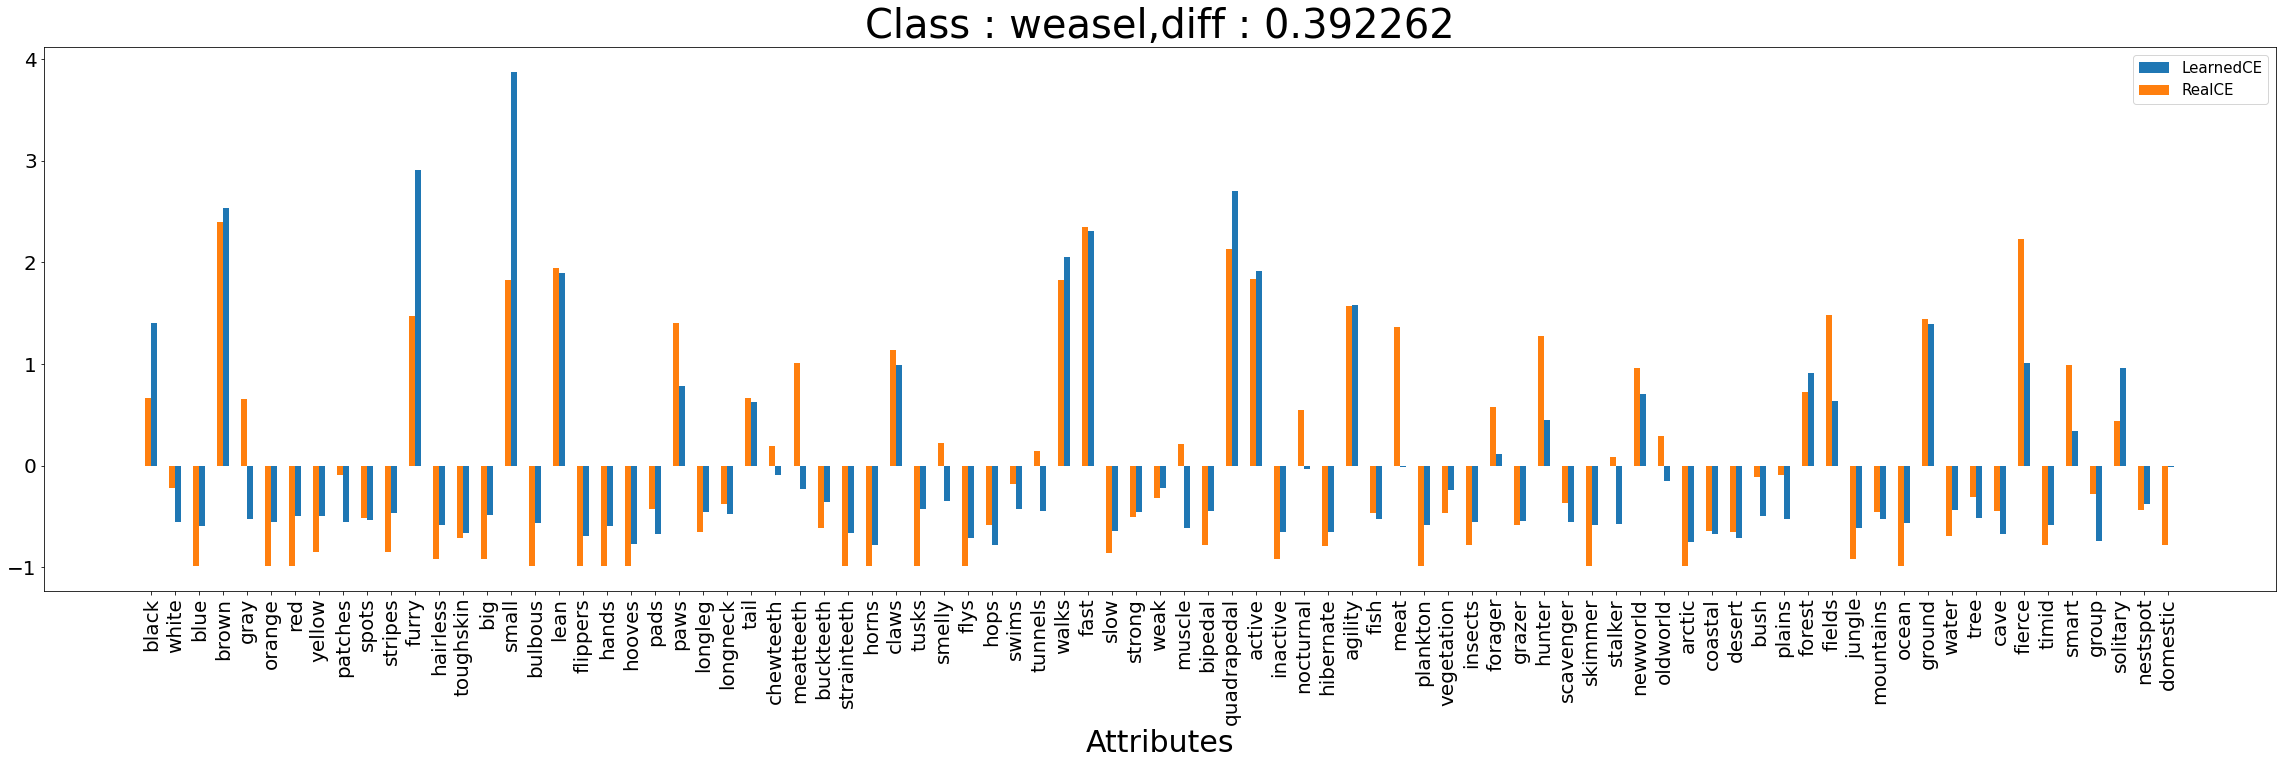

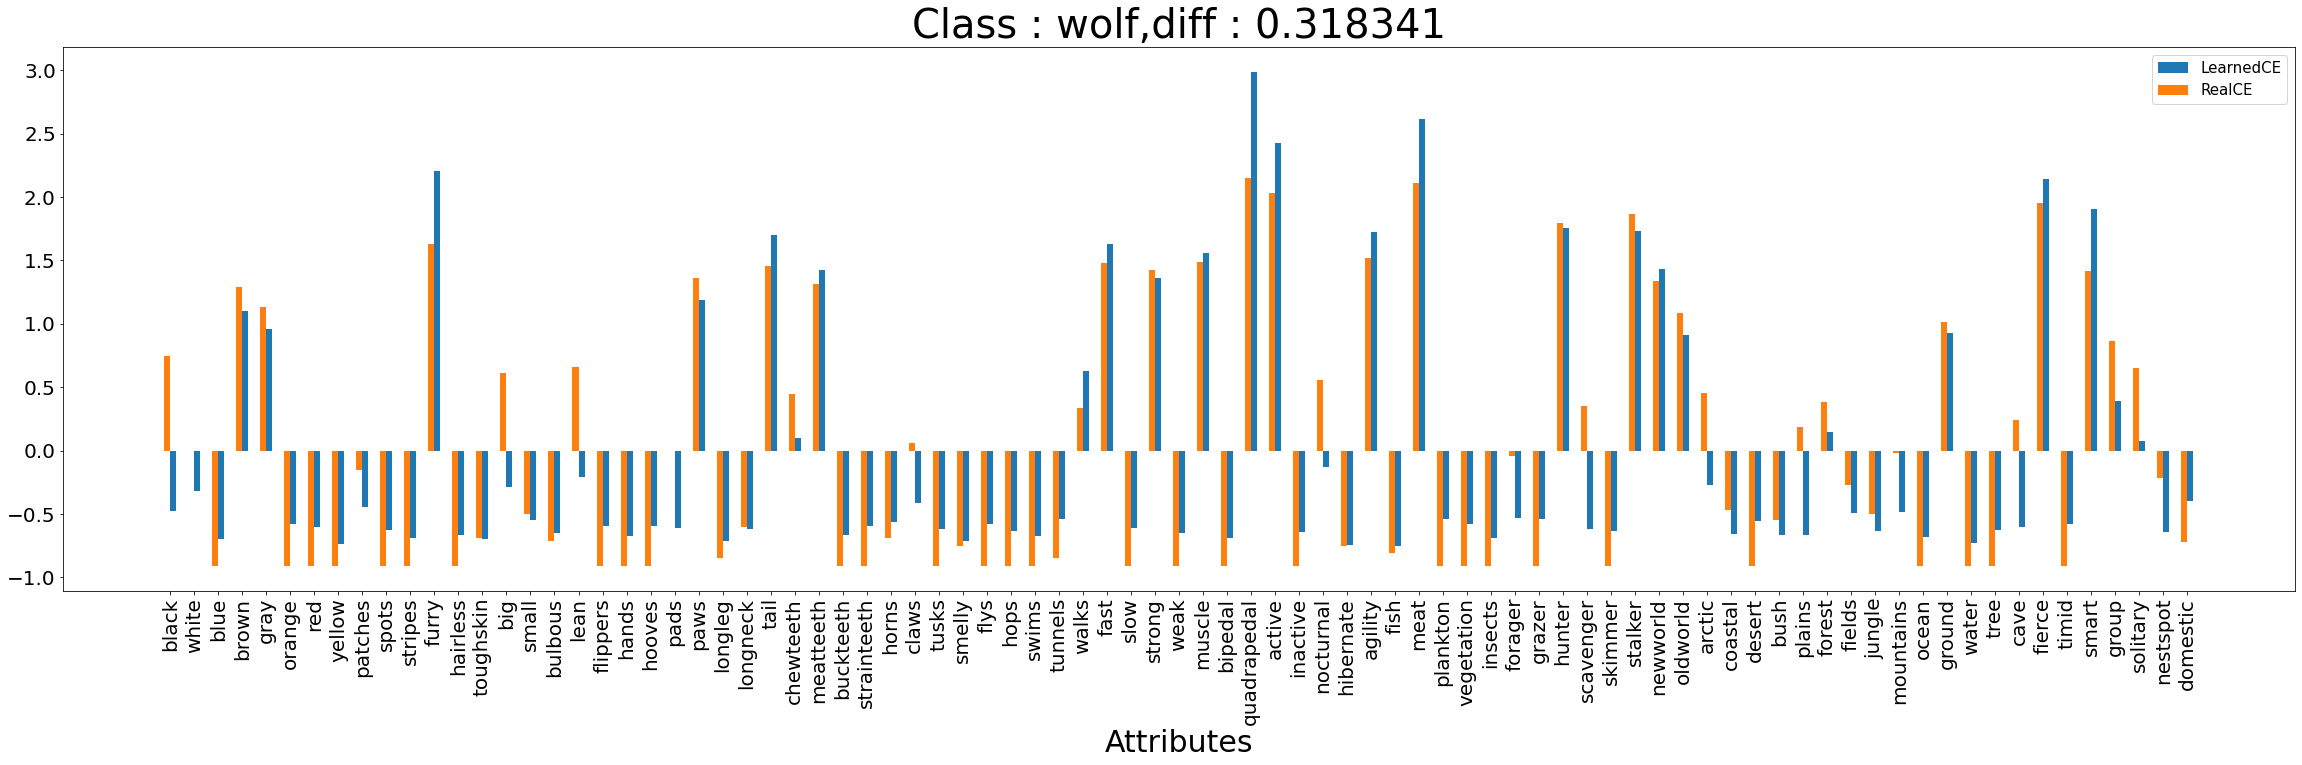

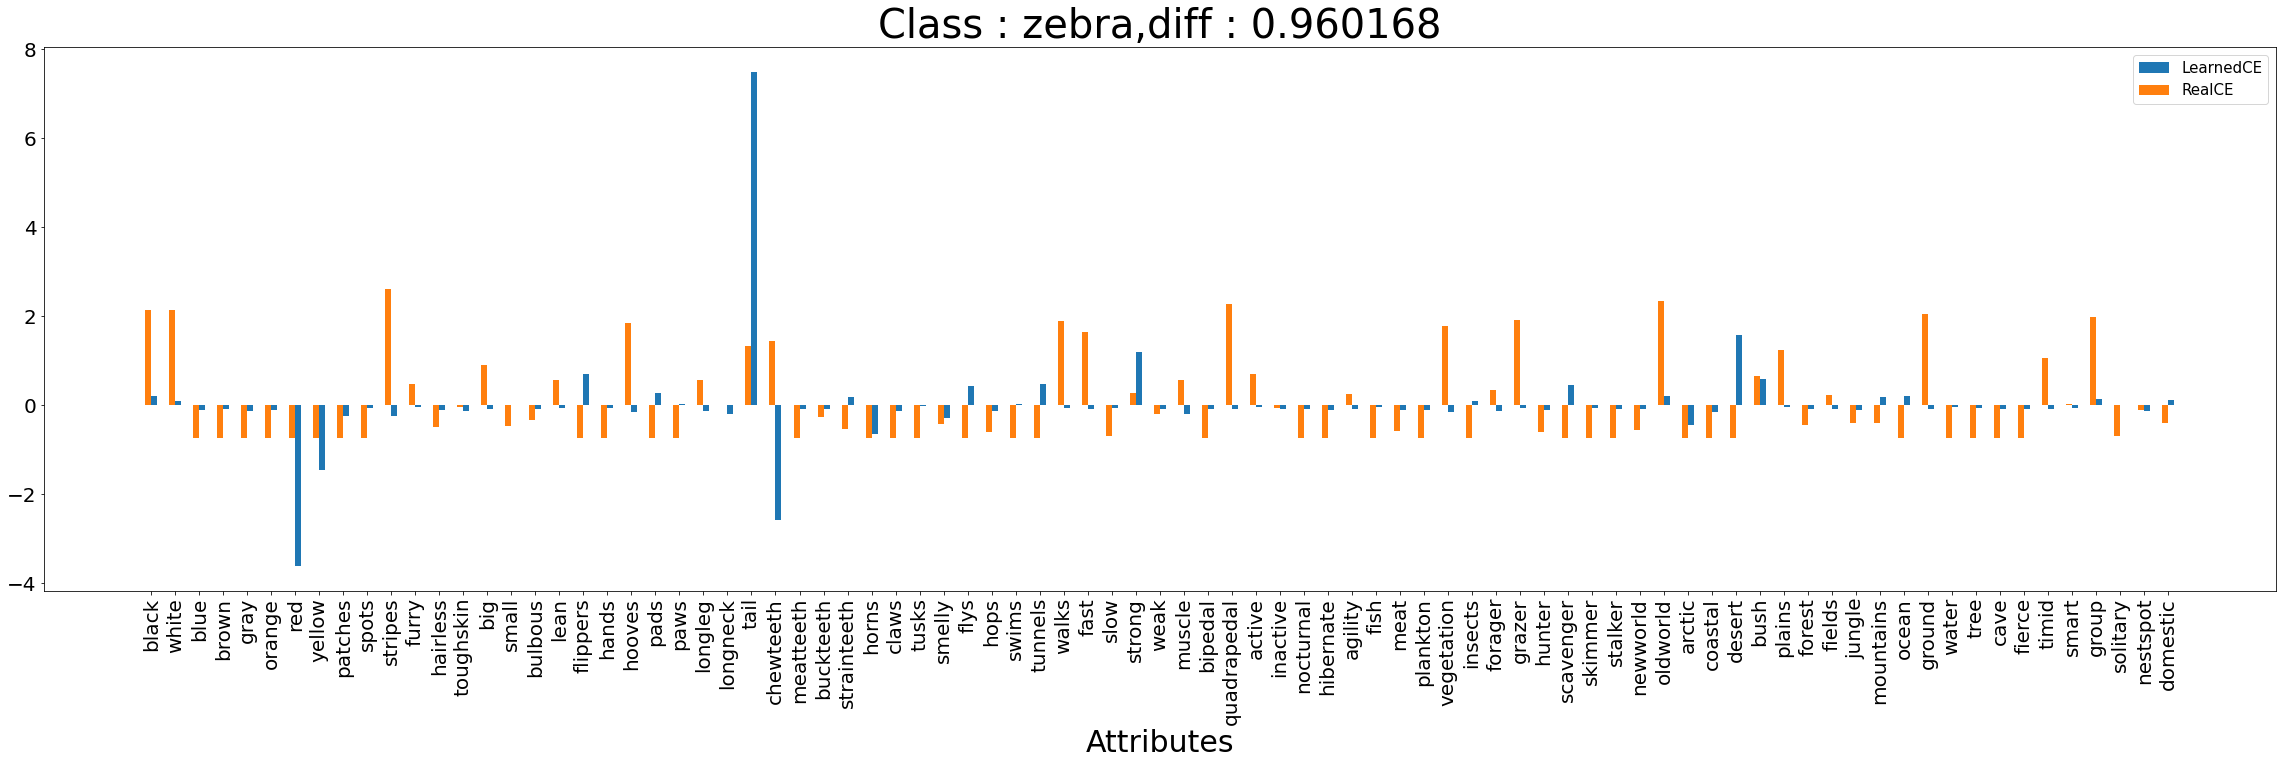

In [16]:
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format(dataset),header=None,sep='\t')


for i in range(seen_class_num):
    diff = round(np.sum(np.abs(sum_attr[i] - real_attr[i])) / len(real_attr[i]),6)
    plt.figure(figsize=(40,10))
    plt.bar(attributes_name[1],height=sum_attr[i],align='edge',label = 'LearnedCE',width = 0.25)
    plt.bar(attributes_name[1],height=real_attr[i],align='edge',label = 'RealCE',width=-0.25)
    plt.legend(fontsize=15) #要使用label要加這行
    plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
    plt.xticks(fontsize=20,rotation='vertical')
    plt.yticks(fontsize=20)
    plt.title('Class : ' + seen_class[i] +',diff : '+ str(diff),fontsize=40) # 設定圖表標題
#     plt.savefig('./data/{}/mat/{}_{}/seen/{}.jpg'.format(dataset,feature_type,attr_type,seen_class[i]))
    plt.show()


## Plot the attribute 2D graph

In [71]:
Spectral = SpectralClustering(n_clusters=40, eigen_solver='arpack', affinity="nearest_neighbors")

In [75]:
pred_attr = Spectral.fit_predict(predict_attr)

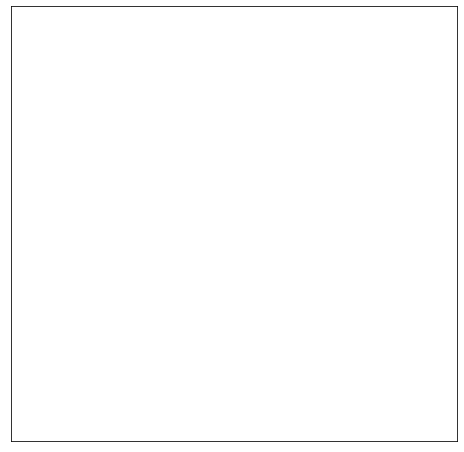

In [79]:
#Data Visualization
plt.figure(figsize=(8, 8))
for i in range(pred_attr.shape[0]):
    plt.plot(pred_attr[i])
plt.xticks([])
plt.yticks([])
plt.show()

## save the seen attr

In [30]:
seen_attr = sum_attr

## Test unseen

In [17]:
unseen_class = []
for k,v in test_gen.class_indices.items():
    unseen_class.append(k)

In [18]:
# load unseen data/ attr/ label
data_test = np.load('./data/{}/feature_label_attr/test/test_feature_{}.npy'.format(dataset,feature_type))
attr_test = np.load('./data/{}/feature_label_attr/test/test_attr_{}.npy'.format(dataset,attr_type))
label_test = np.load('./data/{}/feature_label_attr/test/test_label.npy'.format(dataset))

# calculate attr avg 
predict_attr = encoder.predict(data_test)

# sum 10 class attributes
sum_attr = [[] for i in range(unseen_class_num)]
real_attr = [[] for i in range(unseen_class_num)]
count_class = [0 for i in range(unseen_class_num)]
for idx in range(len(predict_attr)):
    l = label_test[idx]
    if sum_attr[l] == []:
        sum_attr[l] = predict_attr[idx]
        real_attr[l] = attr_test[idx]
    else:    
        sum_attr[l] += predict_attr[idx]
    
    count_class[l] += 1

# averge
for i in range(unseen_class_num):
    sum_attr[i] = sum_attr[i] / count_class[i]

sum_attr = np.array(sum_attr)

if attr_type == 'cmm':
    # normalized
    _min = np.min(sum_attr , axis=1)
    _mam = np.max(sum_attr , axis=1)
    for i in range(unseen_class_num):
        sum_attr[i] = (sum_attr[i] - _min[i]) / (_mam[i] - _min[i])
if attr_type == 'cms':
    # standerlized
    mean = np.mean(sum_attr , axis=1)
    std = np.std(sum_attr, axis=1)
    for i in range(unseen_class_num):
        sum_attr[i] = (sum_attr[i] - mean[i]) / std[i]

## Plot 

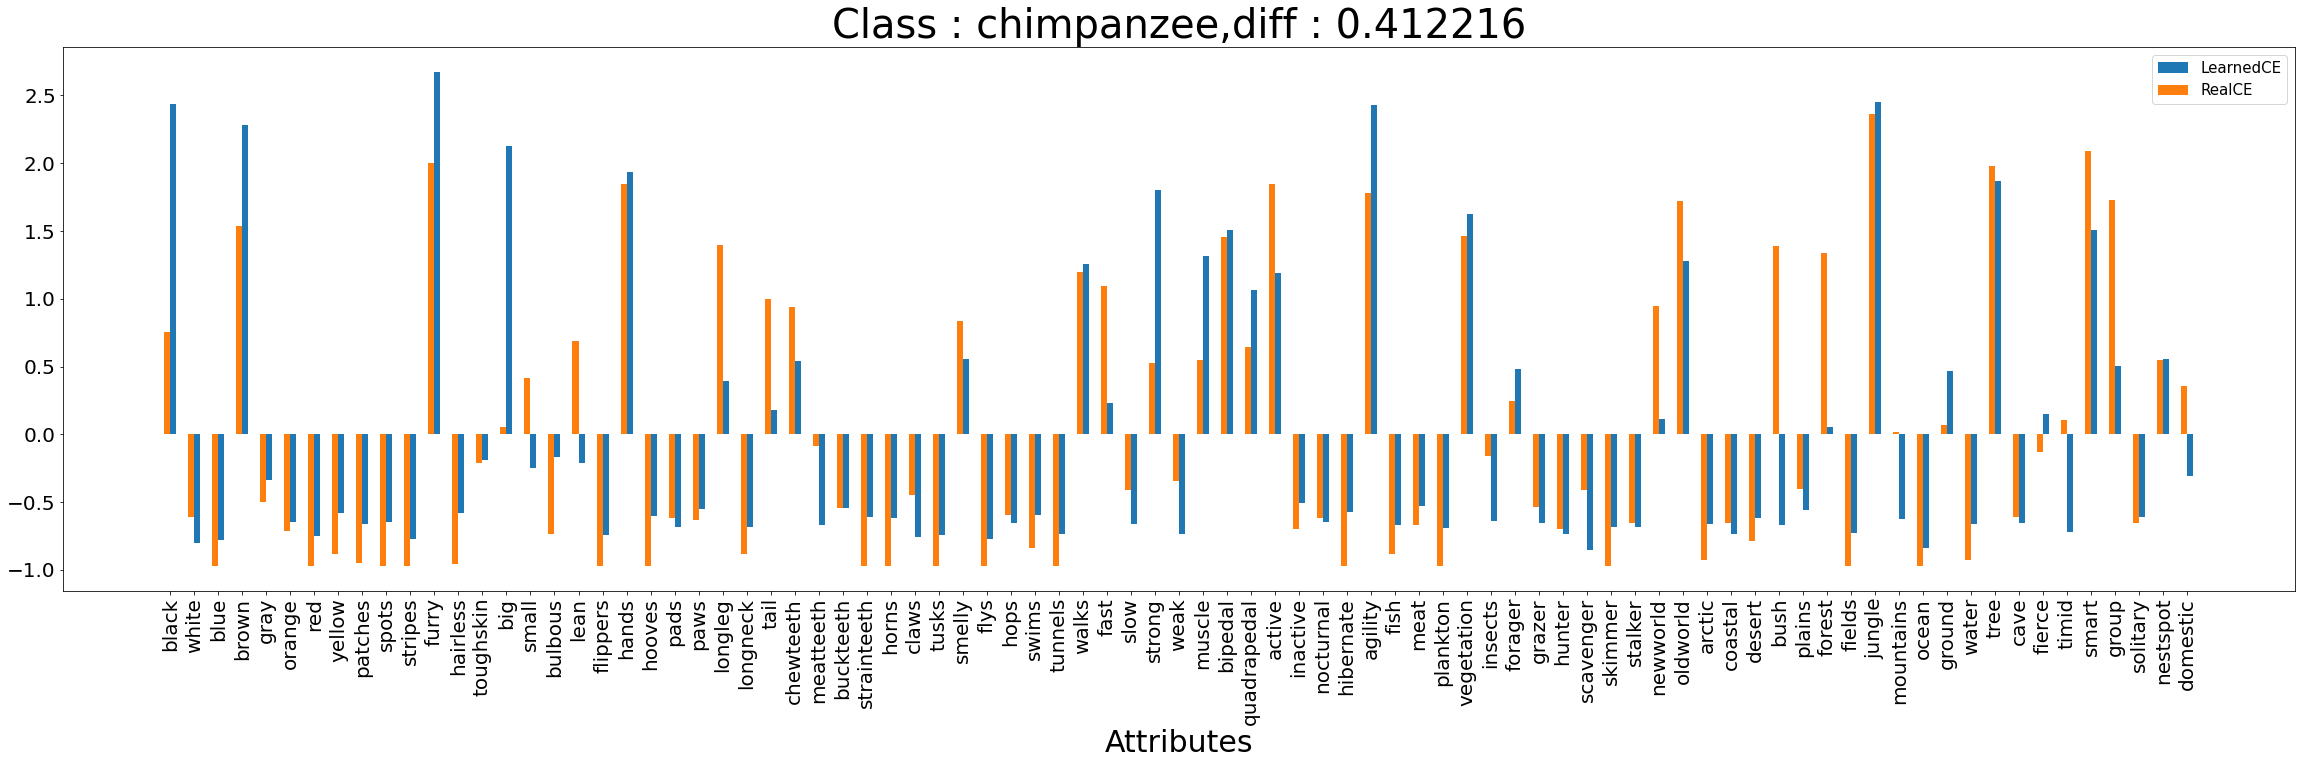

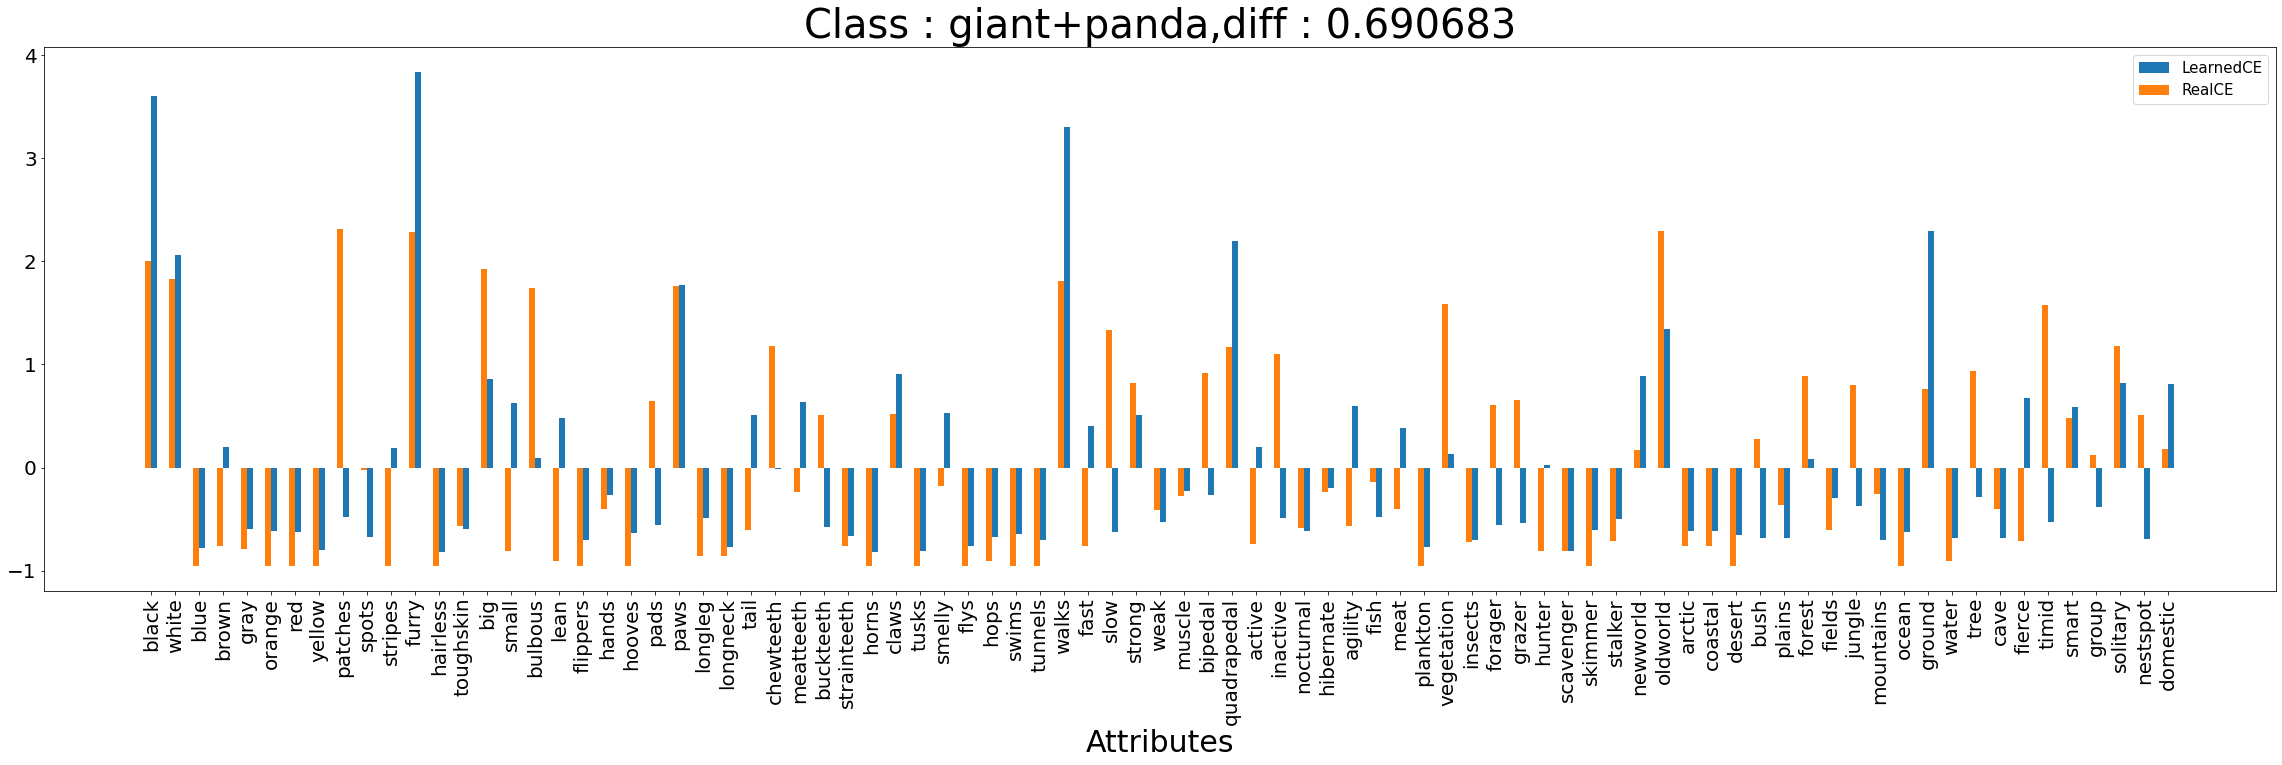

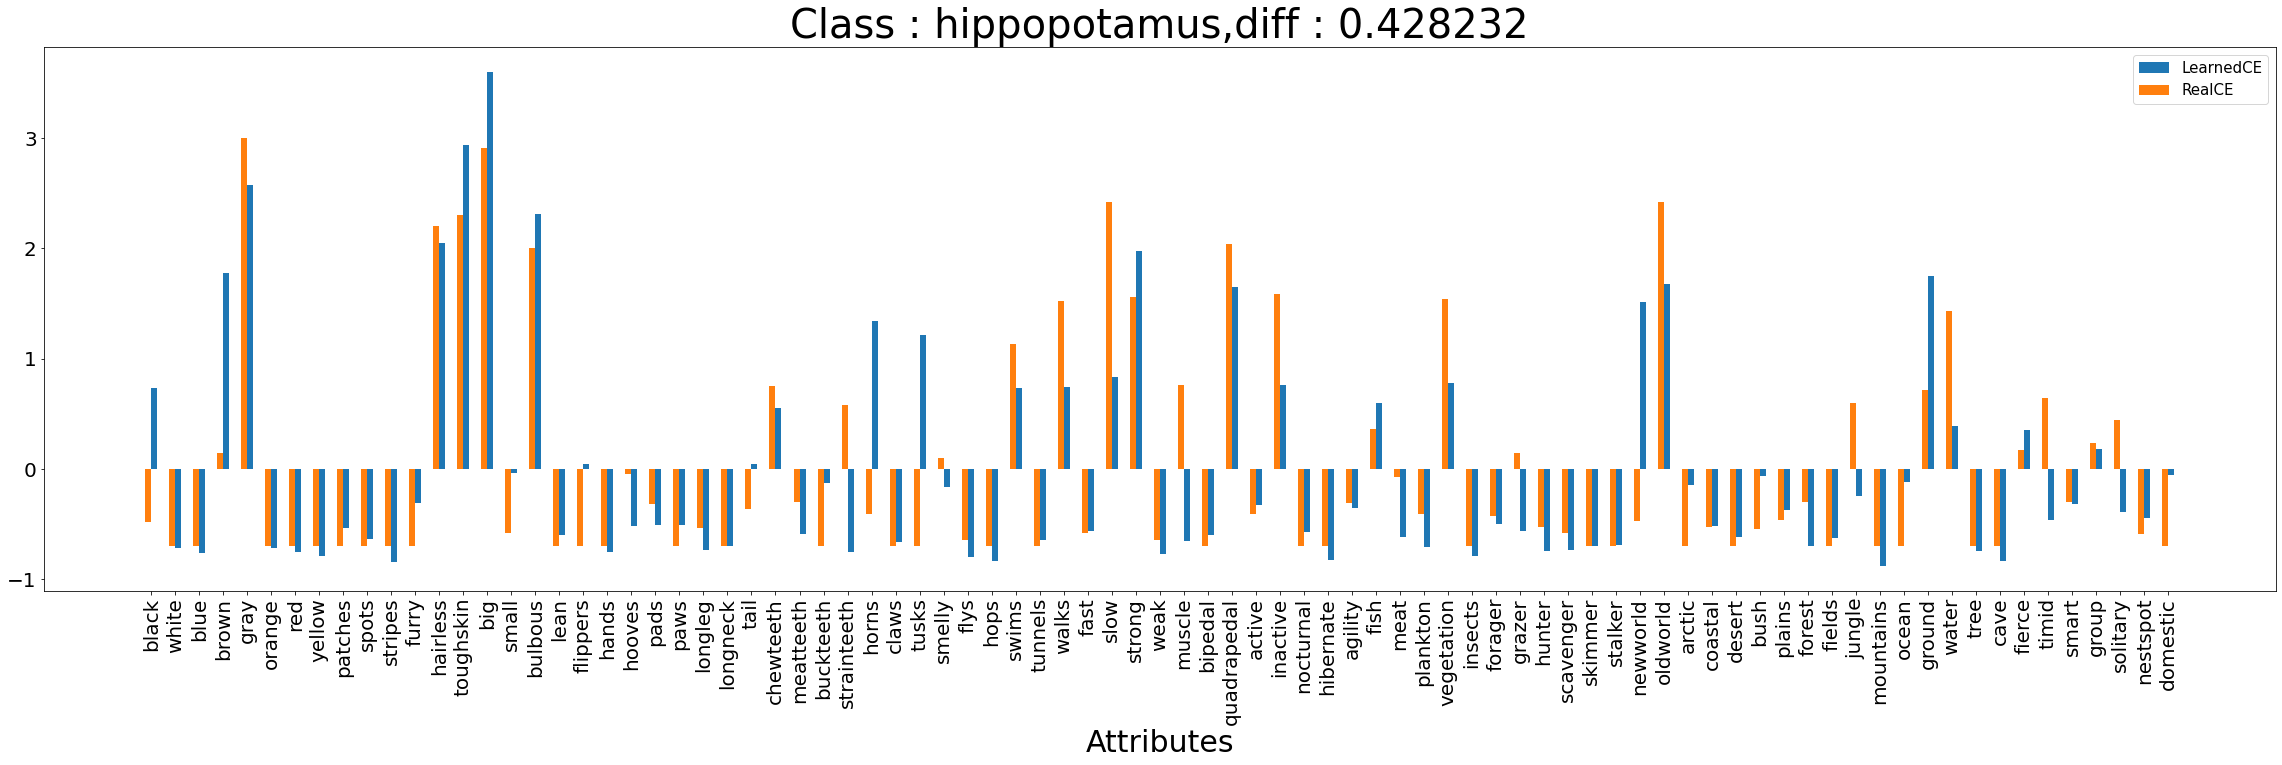

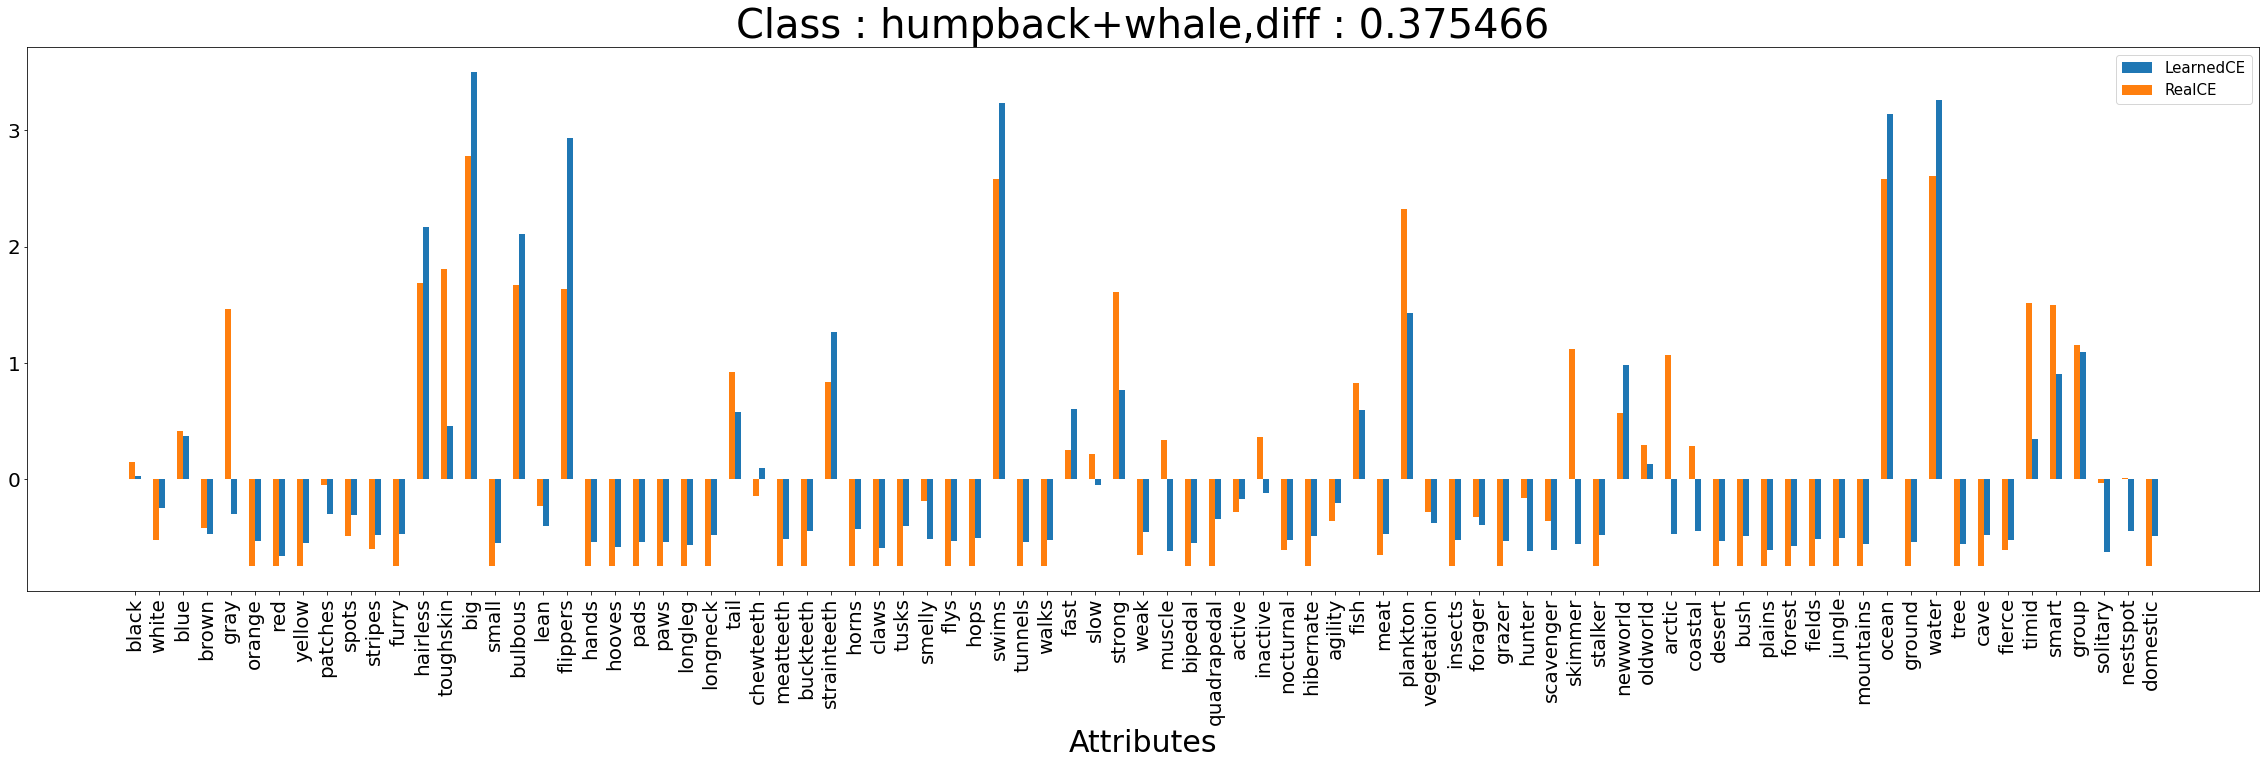

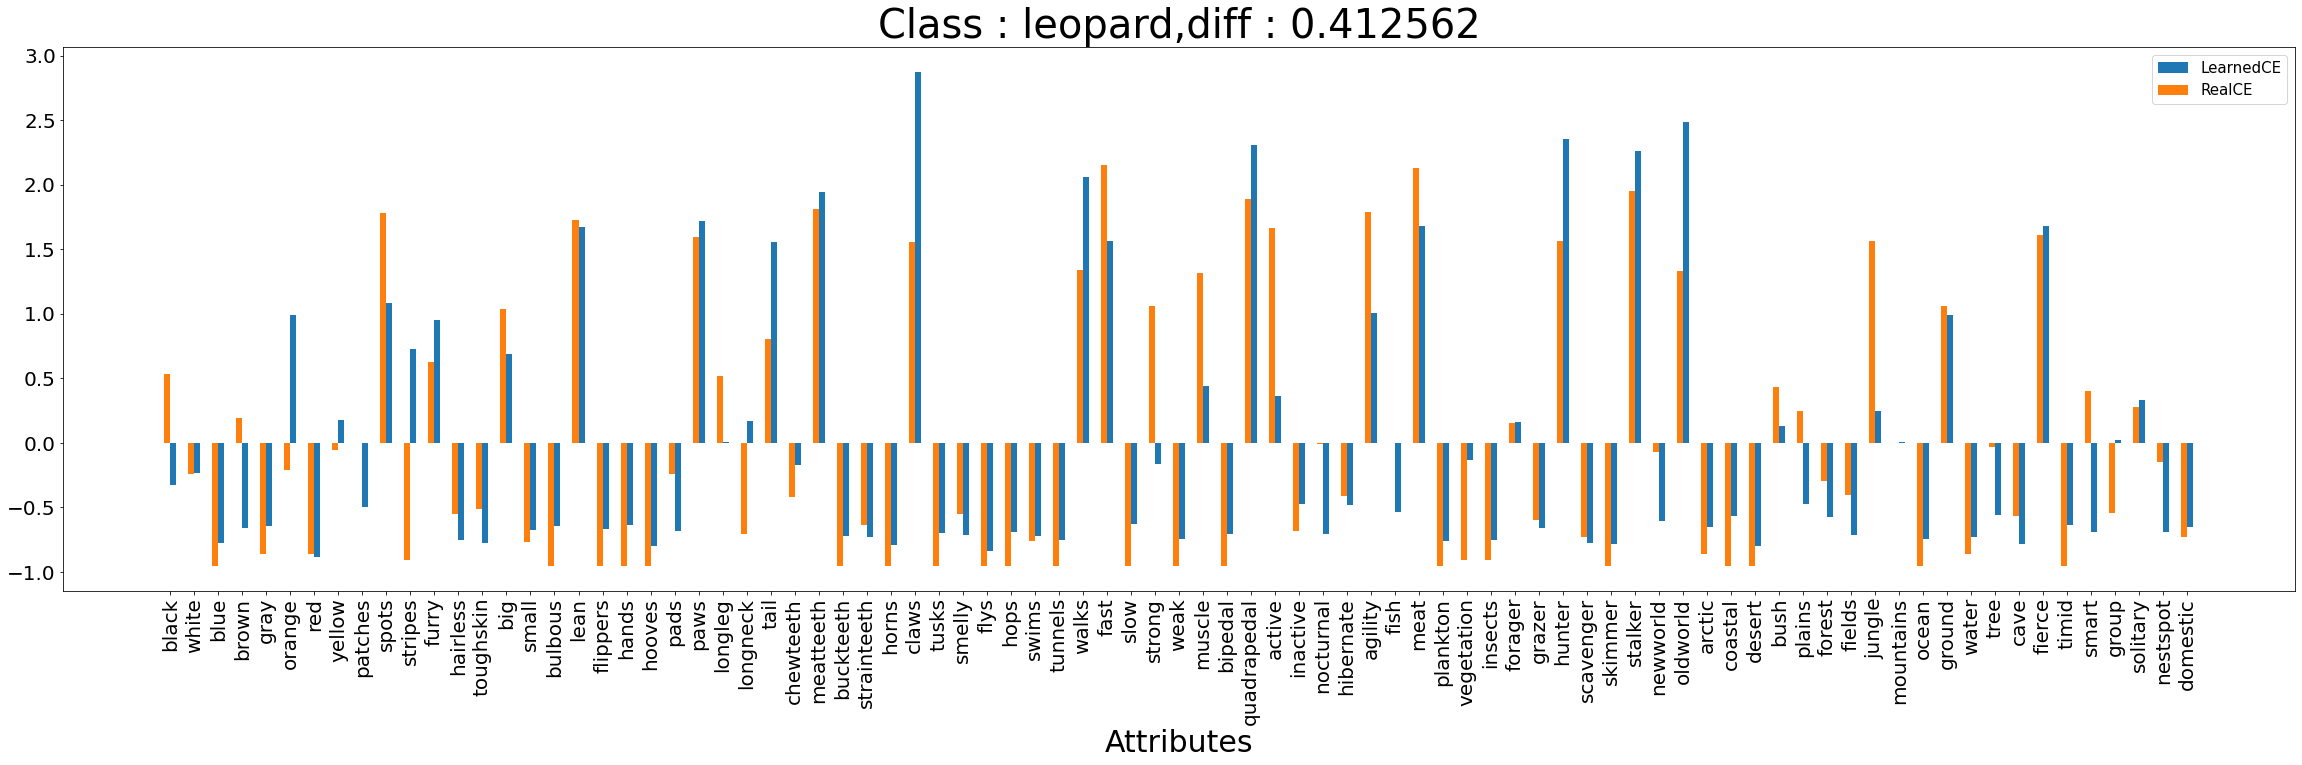

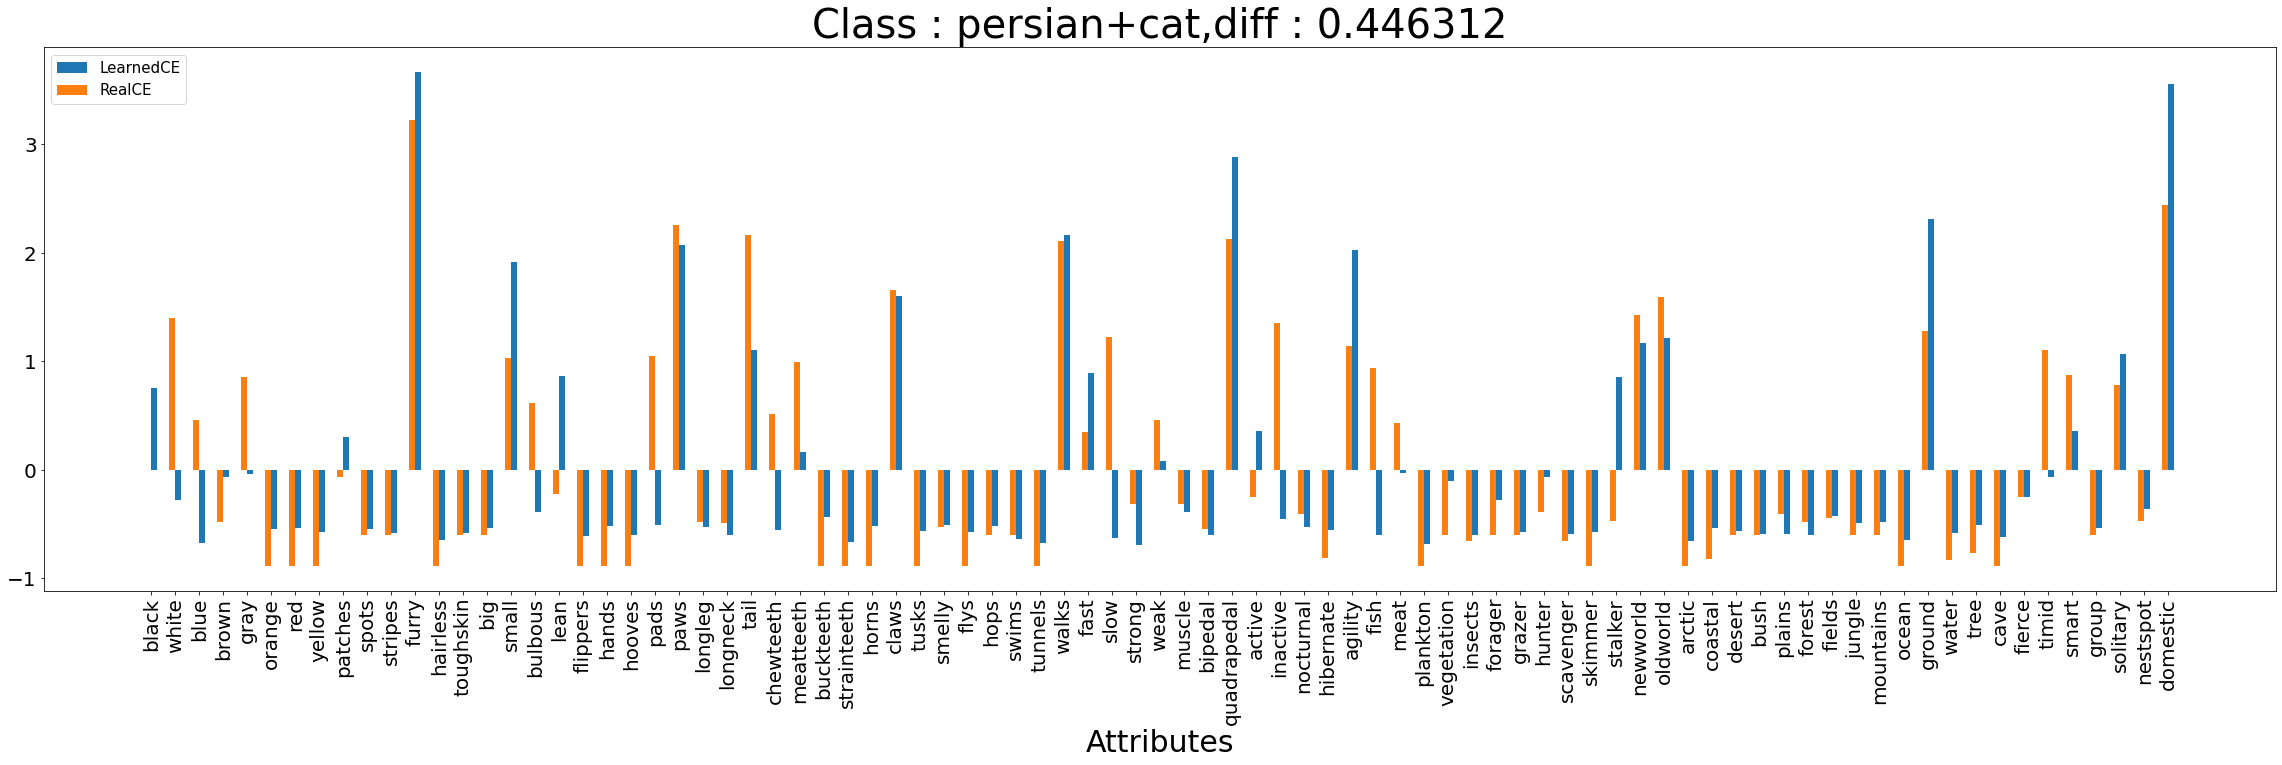

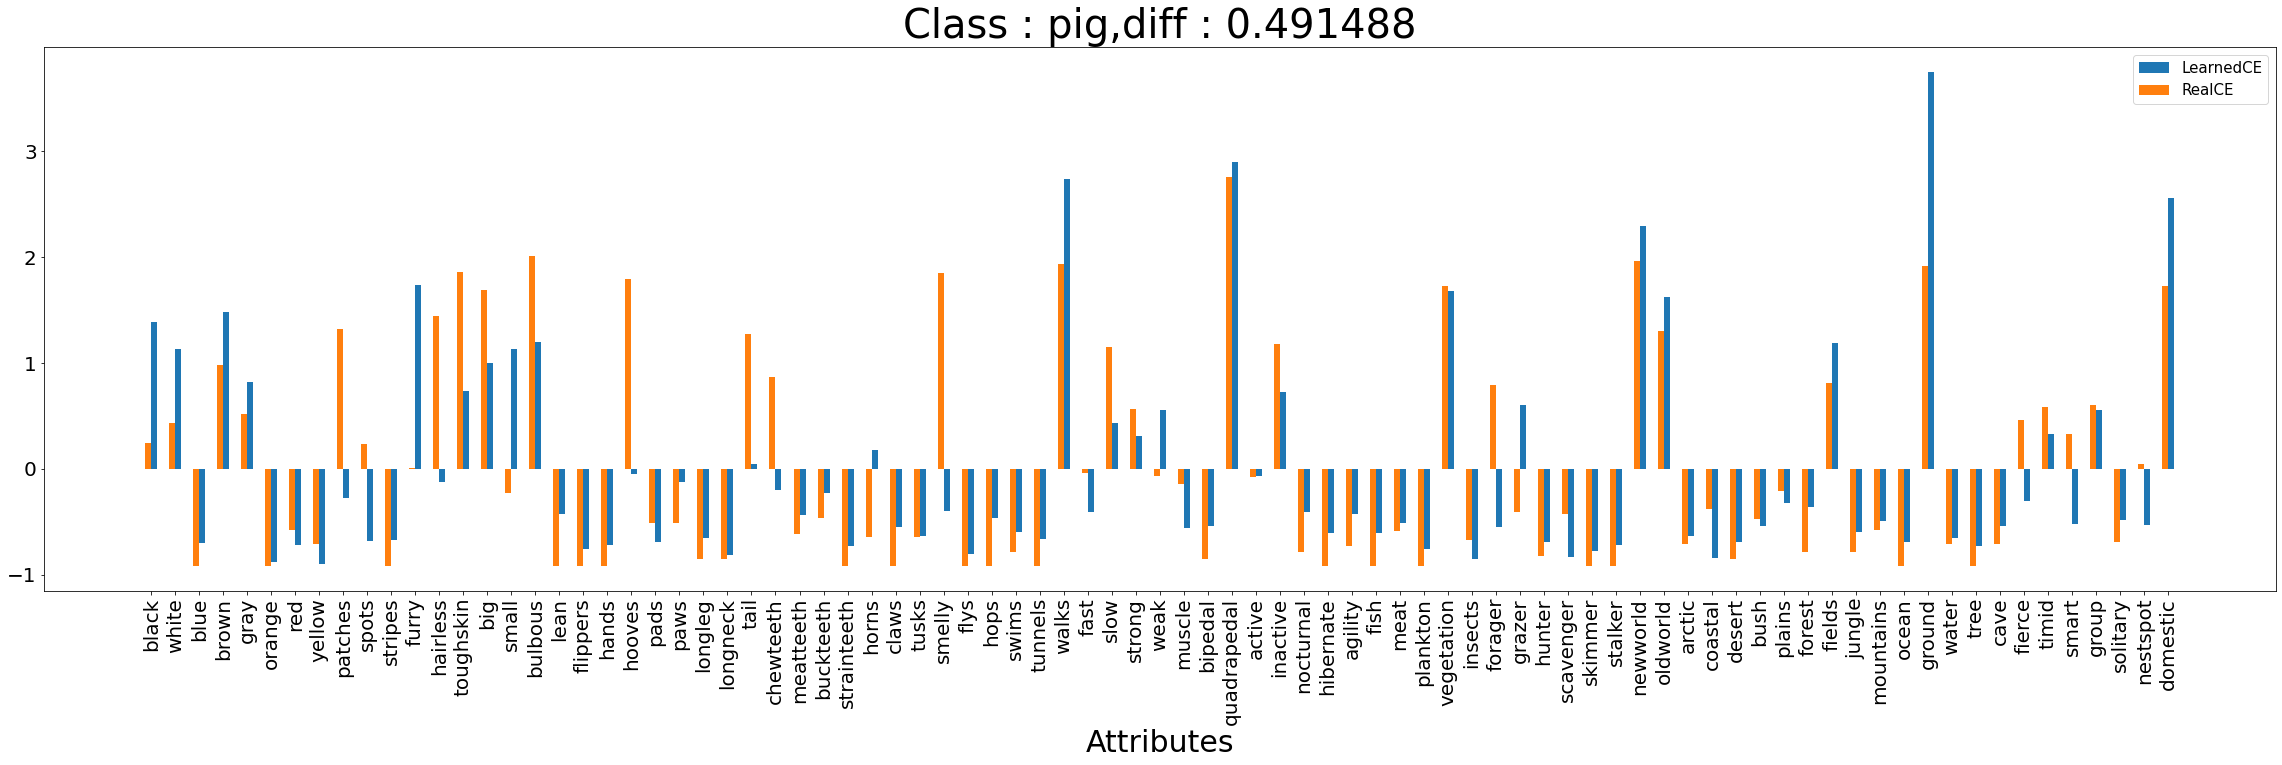

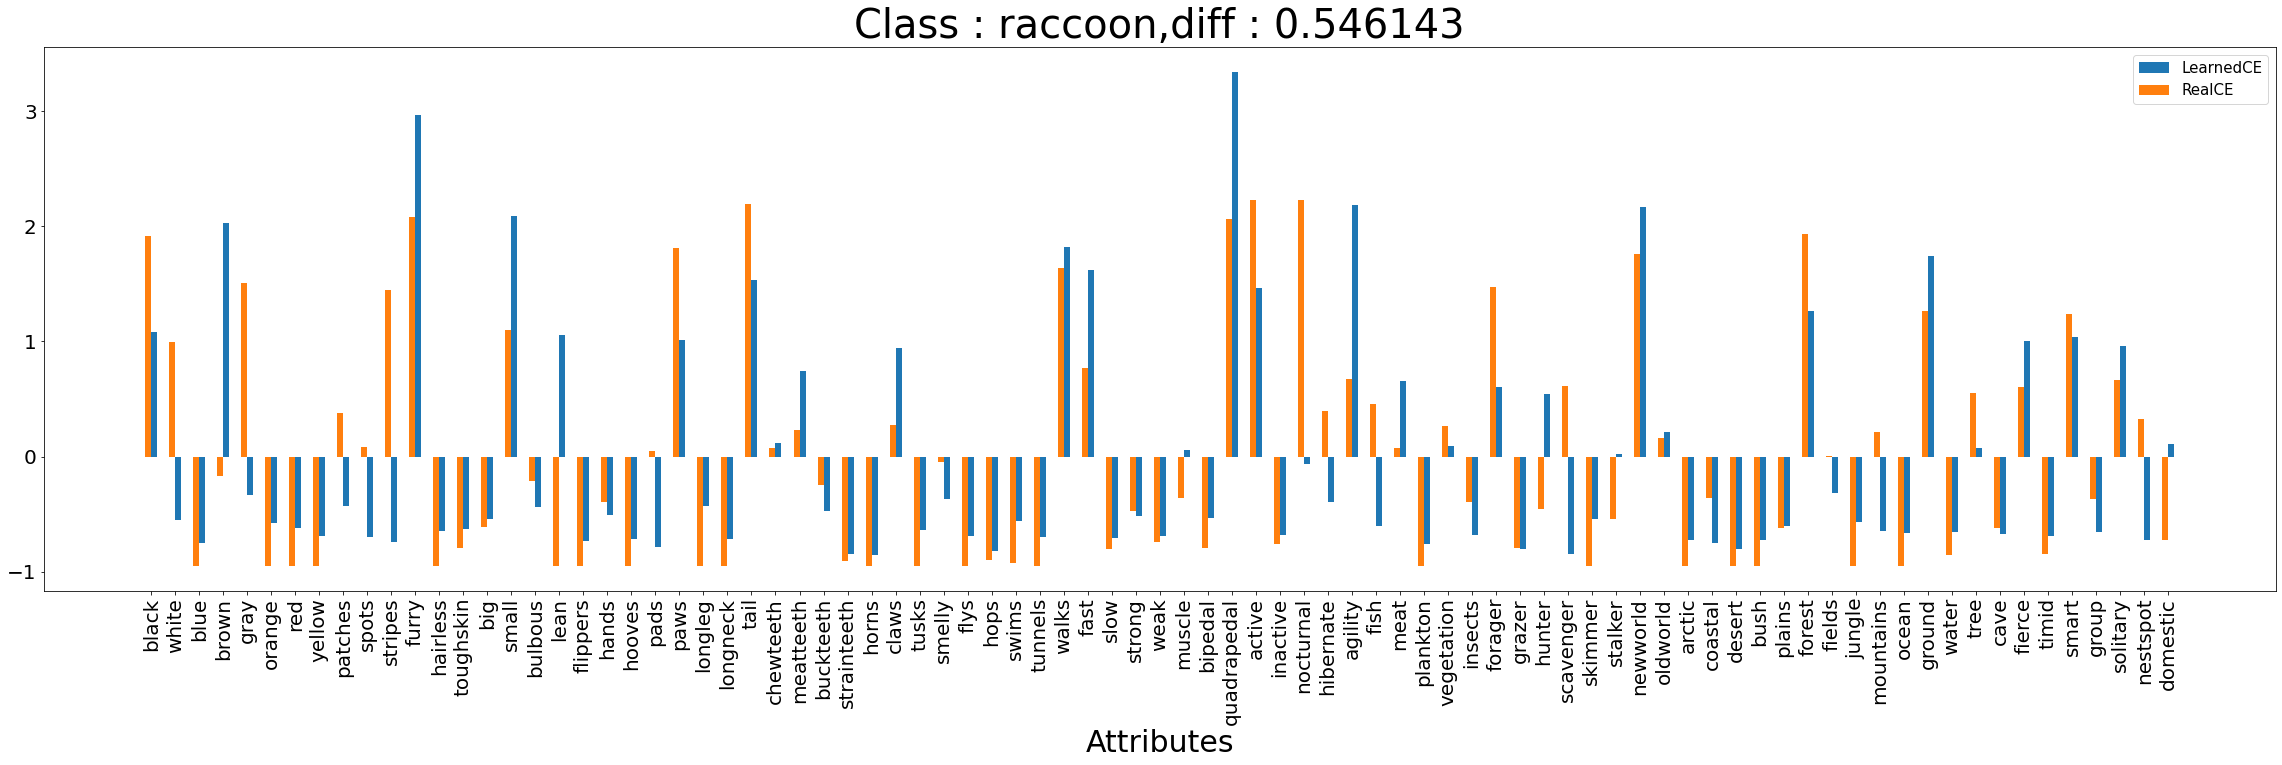

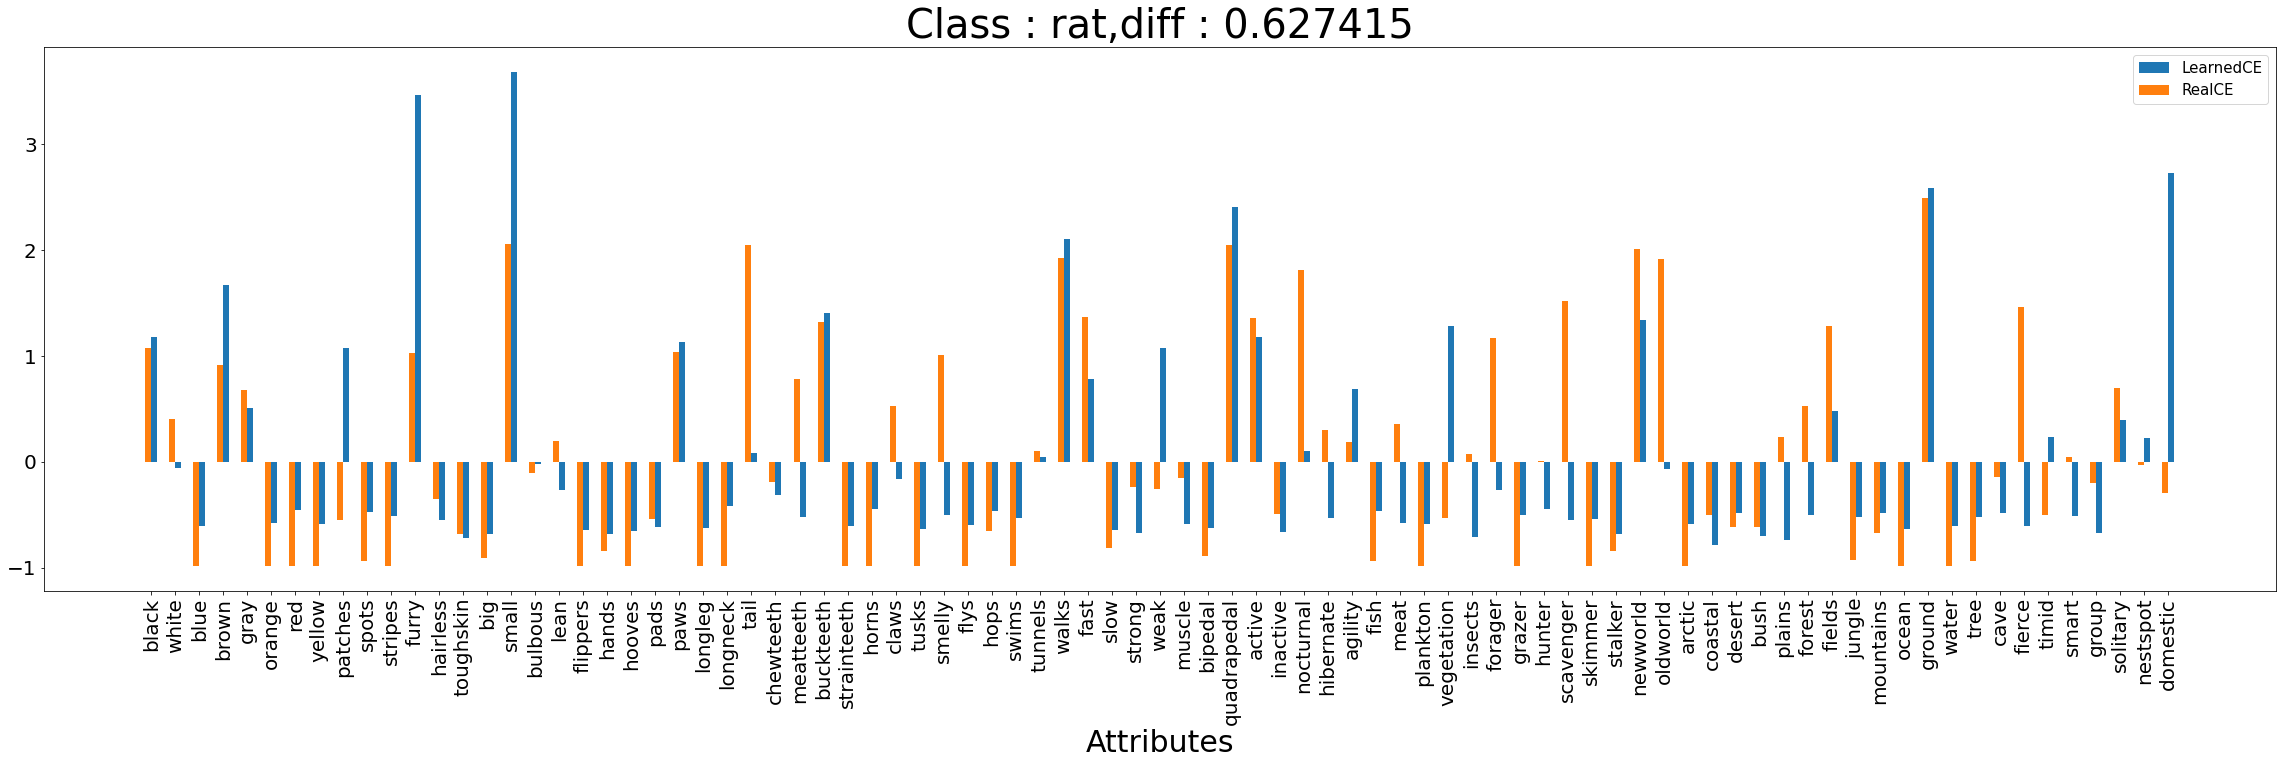

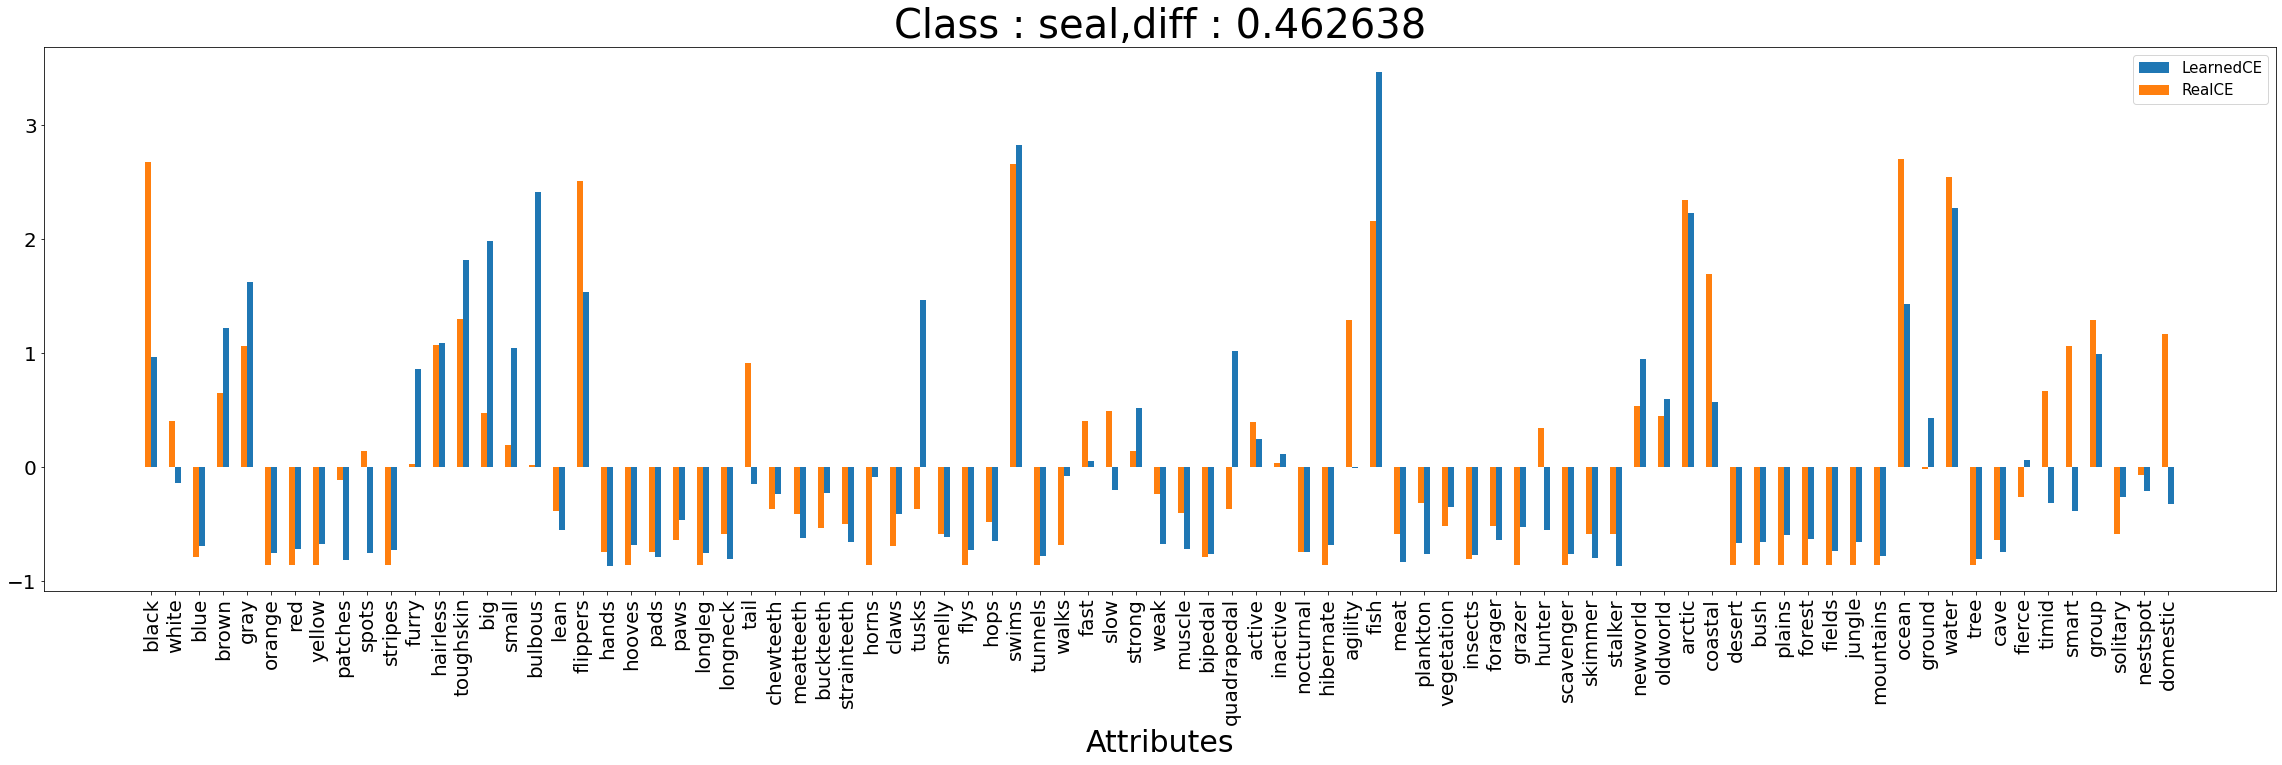

In [19]:
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format(dataset),header=None,sep='\t')


for i in range(unseen_class_num):
    diff = round(np.sum(np.abs(sum_attr[i] - real_attr[i])) / len(real_attr[i]),6)
    plt.figure(figsize=(40,10))
    plt.bar(attributes_name[1],height=sum_attr[i],align='edge',label = 'LearnedCE',width = 0.25)
    plt.bar(attributes_name[1],height=real_attr[i],align='edge',label = 'RealCE',width=-0.25)
    plt.legend(fontsize=15) #要使用label要加這行
    plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
    plt.xticks(fontsize=20,rotation='vertical')
    plt.yticks(fontsize=20)
    plt.title('Class : ' + unseen_class[i] +',diff : '+ str(diff),fontsize=40) # 設定圖表標題
#     plt.savefig('./data/{}/mat/{}_{}/unseen/{}.jpg'.format(dataset,feature_type,attr_type,unseen_class[i]))
    plt.show()


## Plot the attribute 2D graph

In [20]:
attr_tsne = manifold.TSNE(n_components=2, init='random', perplexity = 50,n_iter= 3000,verbose=1).fit_transform(predict_attr)

NameError: name 'manifold' is not defined

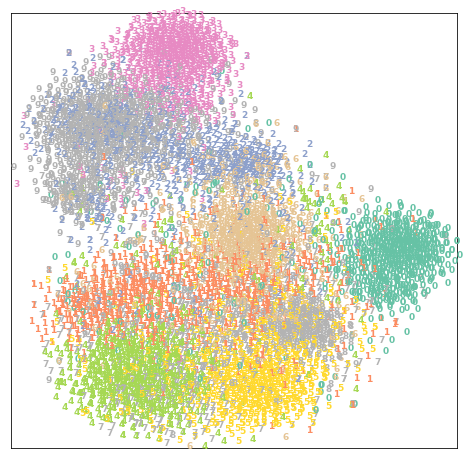

In [65]:
#Data Visualization
attr_min, attr_max = attr_tsne.min(0), attr_tsne.max(0)
attr_norm = (attr_tsne - attr_min) / (attr_max - attr_min)  #Normalize
plt.figure(figsize=(8, 8))
for i in range(attr_norm.shape[0]):
    plt.text(attr_norm[i, 0], attr_norm[i, 1],str(label_test[i]),color=plt.cm.Set2(label_test[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

## save the unseen attr

In [34]:
unseen_attr = sum_attr

## Assign the attr to the correct index

In [35]:
all_attr = [[] for _ in range(class_num)]

seen_idx = 0 
for k,v in train_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    all_attr[idx[0][0]] = seen_attr[seen_idx]
    seen_idx += 1
    
unseen_idx = 0
for k,v in test_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    all_attr[idx[0][0]] = unseen_attr[unseen_idx]
    unseen_idx += 1

all_attr = np.array(all_attr)

In [36]:
seen_convert_dict = {}
for k,v in train_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    seen_convert_dict[v] = idx[0][0]
    
unseen_convert_dict = {}
for k,v in test_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    unseen_convert_dict[v] = idx[0][0]

In [37]:
# correct the train label val lavel and test label
for idx in range(len(label_train)):
    l = label_train[idx]
    label_train[idx] = seen_convert_dict[l]

for idx in range(len(label_val)):
    l = label_val[idx]
    label_val[idx] = seen_convert_dict[l]

for idx in range(len(label_test)):
    l = label_test[idx]
    label_test[idx] = unseen_convert_dict[l]


In [38]:
# concatenate train val test
data = np.concatenate((data_train,data_val,data_test),axis = 0)
label = np.concatenate((label_train,label_val,label_test),axis = 0)

In [39]:
data_list = []
label_list = []
trainval_loc = []
test_seen_loc = []
test_unseen_loc = []

for i in range(len(data)):
    data_list.append(data[i])
    label_list.append(label[i]+1)
    if i < train_gen.n:
        trainval_loc.append(i+1)
    elif i < (train_gen.n + val_gen.n) and i >= train_gen.n:
        test_seen_loc.append(i+1)
    elif i < (train_gen.n + val_gen.n + test_gen.n) and i >= (train_gen.n + val_gen.n):
        test_unseen_loc.append(i+1)

data_list = np.row_stack(data_list)
label_list = np.row_stack(label_list)
trainval_loc = np.row_stack(trainval_loc)
test_seen_loc = np.row_stack(test_seen_loc)
test_unseen_loc = np.row_stack(test_unseen_loc)


path = './data/{}/mat/{}_{}/testres101.mat'.format(dataset,feature_type,attr_type)

sio.savemat(path, {
                   'features': data_list.transpose(),
                   'labels': label_list})

path = './data/{}/mat/{}_{}/testatt_splits.mat'.format(dataset,feature_type,attr_type)

sio.savemat(path, {
                   'trainval_loc': trainval_loc,
                   'test_seen_loc': test_seen_loc,
                   'test_unseen_loc': test_unseen_loc,
                   'att': all_attr.transpose(),
                   'train_loc': test_unseen_loc,  ##non used in code
                   'val_loc': test_unseen_loc})    ##non used in code